In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score

In [6]:
df = pd.read_csv('src\datasets\one_hot_encoded\combined-data.csv')

df.head()

Year  Temperature        Co2  Country_Albania  Country_Algeria  \
0  1970        0.248   8.952570                0                0   
1  1970        0.082   0.002168                0                0   
2  1970       -0.106   4.814516                1                0   
3  1970        0.422  19.437564                0                0   
4  1970        0.438  88.321009                0                0   

   Country_Angola  Country_Anguilla  Country_Antigua and Barbuda  \
0               1                 0                            0   
1               0                 1                            0   
2               0                 0                            0   
3               0                 0                            0   
4               0                 0                            0   

   Country_Argentina  Country_Australia  ...  Country_Uganda  \
0                  0                  0  ...               0   
1                  0                  0  ...               0   
2                  0                  0  ...               0   
3                  0                  0  ...               0   
4                  1                  0  ...               0   

   Country_United Arab Emirates  Country_United Kingdom  \
0                             0                       0   
1                             0                       0   
2                             0                       0   
3                             1                       0   
4                             0                       0   

   Country_United States  Country_Uruguay  Country_Vanuatu  Country_Vietnam  \
0                      0                0                0                0   
1                      0                0                0                0   
2                      0                0                0                0   
3                      0                0                0                0   
4                      0                0                0                0   

   Country_Western Sahara  Country_Zambia  Country_Zimbabwe  
0                       0               0                 0  
1                       0               0                 0  
2                       0               0                 0  
3                       0               0                 0  
4                       0               0                 0  

[5 rows x 135 columns]

In [7]:
avg_by_year = df.groupby('Year').mean()

X = avg_by_year[['Co2']].values
y = avg_by_year['Temperature'].values

split_index = int(len(X) * 0.8)

X_train, X_val_test = X[:split_index], X[split_index:]
y_train, y_val_test = y[:split_index], y[split_index:]


split_index_val = int(len(X_val_test) * 0.5)

X_val, X_test = X_val_test[:split_index_val], X_val_test[split_index_val:]
y_val, y_test = y_val_test[:split_index_val], y_val_test[split_index_val:]


seq_length = 3
tf.random.set_seed(42)

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    X_train,
    targets = y_train[seq_length:],
    sequence_length= seq_length,
    batch_size = 5,
    shuffle = True,
    seed = 42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    X_val,
    targets= y_val[seq_length:],
    sequence_length = seq_length,
    batch_size = 5
)
test_ds = tf.keras.utils.timeseries_dataset_from_array(
    X_test,
    targets= y_test[seq_length:],
    sequence_length = seq_length,
    batch_size = 5
)


In [8]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=100):
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(
      monitor = "val_mae", patience = 50, restore_best_weights=True)

  opt = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum=0.9)

  model.compile(loss = tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])

  history = model.fit(train_set, validation_data = valid_set, epochs = epochs,
                                    callbacks=[early_stopping_cb])

  valid_loss, valid_mae = model.evaluate(valid_set)

  return valid_mae * 1e6

In [9]:
tf.random.set_seed(42)

deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True ),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

model = fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/100
8/8 [==============================] - 4s 149ms/step - loss: 0.4882 - mae: 0.8839 - val_loss: 0.3764 - val_mae: 0.8646
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 0.1147 - mae: 0.3961 - val_loss: 0.0057 - val_mae: 0.0778
Epoch 3/100
8/8 [==============================] - 0s 43ms/step - loss: 0.2517 - mae: 0.6072 - val_loss: 0.7278 - val_mae: 1.2278
Epoch 4/100
8/8 [==============================] - 0s 33ms/step - loss: 0.1189 - mae: 0.3921 - val_loss: 0.1941 - val_mae: 0.6189
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0884 - mae: 0.3276 - val_loss: 0.1519 - val_mae: 0.5464
Epoch 6/100
8/8 [==============================] - 1s 72ms/step - loss: 0.0970 - mae: 0.3644 - val_loss: 0.6193 - val_mae: 1.1193
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 0.1418 - mae: 0.4412 - val_loss: 0.7807 - val_mae: 1.2807
Epoch 8/100
8/8 [==============================] - 0s 21ms/step - loss: 0.1096 - mae: 0.3

In [10]:
test_predictions = deep_model.predict(test_ds)

1/1 [==============================] - 16s 16s/step


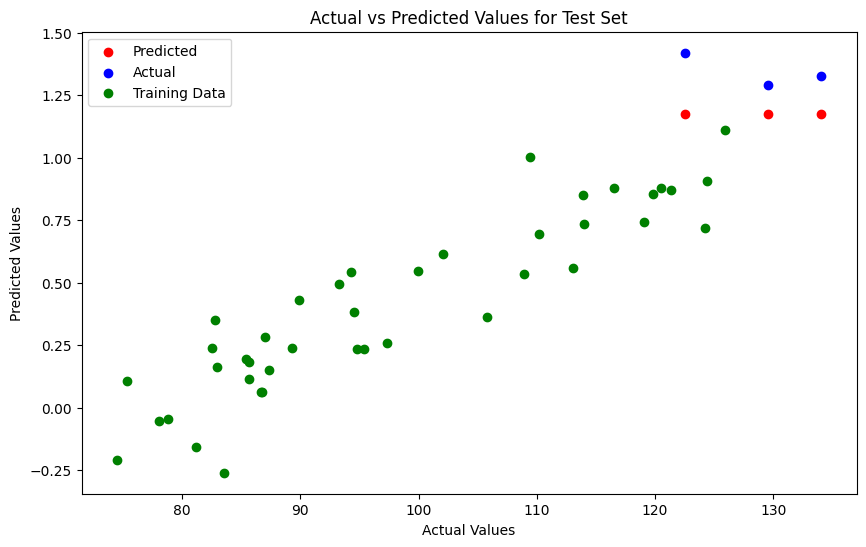

In [11]:

plt.figure(figsize=(10, 6))


plt.scatter(X_test[seq_length:], test_predictions, color='red', label='Predicted')


plt.scatter(X_test[seq_length:], y_test[seq_length:], color='blue', label='Actual')
plt.scatter(X_train, y_train, label='Training Data', color='green')

plt.title('Actual vs Predicted Values for Test Set')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

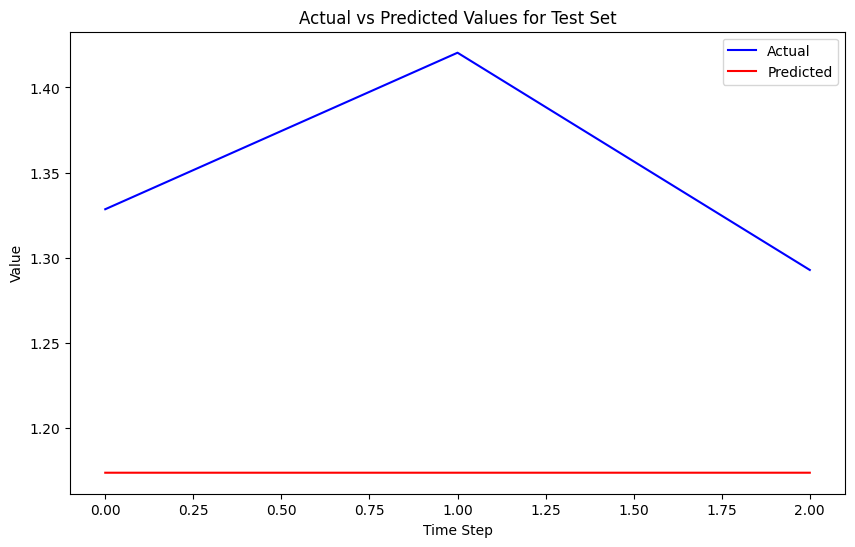

1/1 [==============================] - 0s 219ms/step - loss: 0.0165 - mae: 0.1735
Test MAE: 0.1735215187072754
Test loss: 0.016499733552336693


In [12]:

plt.figure(figsize=(10, 6))
plt.plot(y_test[seq_length:], label='Actual', color='blue')
plt.plot(test_predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted Values for Test Set')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


test_loss, test_mae = deep_model.evaluate(test_ds)
print("Test MAE:", test_mae)
print("Test loss:", test_loss)


model_results = {
    "Test Loss": test_loss,
    "Test MAE": test_mae,
}

In [11]:
from sklearn.metrics import r2_score

test_r2 = r2_score(y_test[seq_length:], test_predictions)

print("Test R^2:", test_r2)

Test R^2: -216.7160318215777


Epoch 1/50
8/8 [==============================] - 3s 71ms/step - loss: 0.1769 - mae: 0.5114 - val_loss: 0.0176 - val_mae: 0.1439
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.1247 - mae: 0.4012 - val_loss: 0.1289 - val_mae: 0.4935
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1133 - mae: 0.3890 - val_loss: 0.0435 - val_mae: 0.2695
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.1182 - mae: 0.4058 - val_loss: 0.3142 - val_mae: 0.7836
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.1291 - mae: 0.3862 - val_loss: 0.0670 - val_mae: 0.3458
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 0.1618 - mae: 0.4686 - val_loss: 0.1708 - val_mae: 0.5720
Epoch 7/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1221 - mae: 0.4181 - val_loss: 0.1593 - val_mae: 0.5515
Epoch 8/50
8/8 [==============================] - 0s 11ms/step - loss: 0.1203 - mae: 0.3944 - val

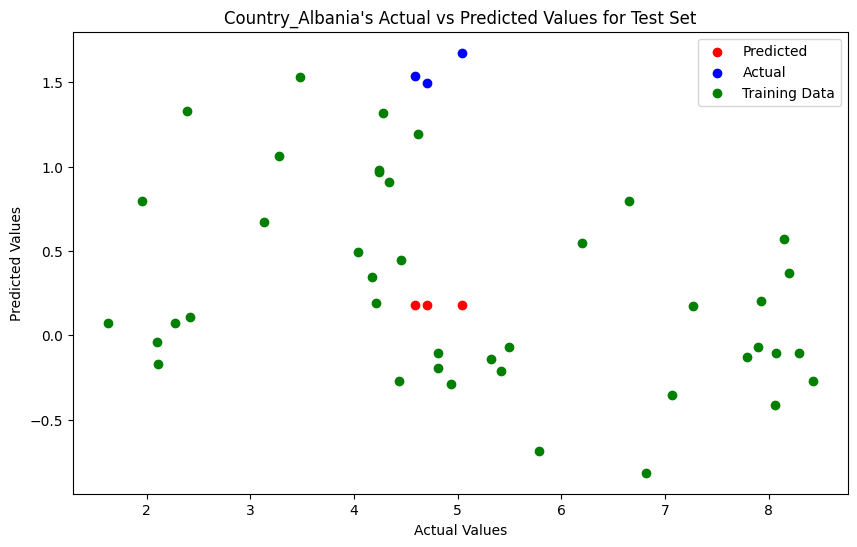

Epoch 1/50
8/8 [==============================] - 3s 71ms/step - loss: 0.2779 - mae: 0.6386 - val_loss: 0.2057 - val_mae: 0.5749
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.2473 - mae: 0.5901 - val_loss: 0.3658 - val_mae: 0.8094
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.2250 - mae: 0.5542 - val_loss: 0.2149 - val_mae: 0.5907
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.2110 - mae: 0.5358 - val_loss: 0.4642 - val_mae: 0.9334
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.2389 - mae: 0.5791 - val_loss: 0.2555 - val_mae: 0.6557
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 0.2188 - mae: 0.5485 - val_loss: 0.2849 - val_mae: 0.6992
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 0.2354 - mae: 0.5743 - val_loss: 0.2425 - val_mae: 0.6357
Epoch 8/50
8/8 [==============================] - 0s 11ms/step - loss: 0.2287 - mae: 0.5628 - val

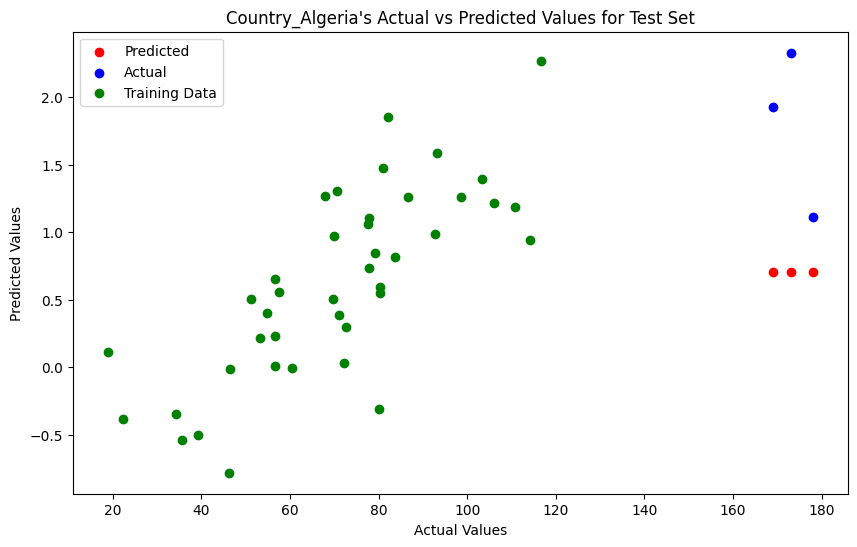

Epoch 1/50
8/8 [==============================] - 3s 73ms/step - loss: 0.0782 - mae: 0.3341 - val_loss: 0.3133 - val_mae: 0.7506
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0649 - mae: 0.2888 - val_loss: 0.2835 - val_mae: 0.7098
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0578 - mae: 0.2788 - val_loss: 0.2010 - val_mae: 0.5822
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0621 - mae: 0.2865 - val_loss: 0.2320 - val_mae: 0.6332
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0594 - mae: 0.2840 - val_loss: 0.2628 - val_mae: 0.6805
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0599 - mae: 0.2793 - val_loss: 0.2175 - val_mae: 0.6105
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0569 - mae: 0.2766 - val_loss: 0.2279 - val_mae: 0.6286
Epoch 8/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0593 - mae: 0.2882 - val

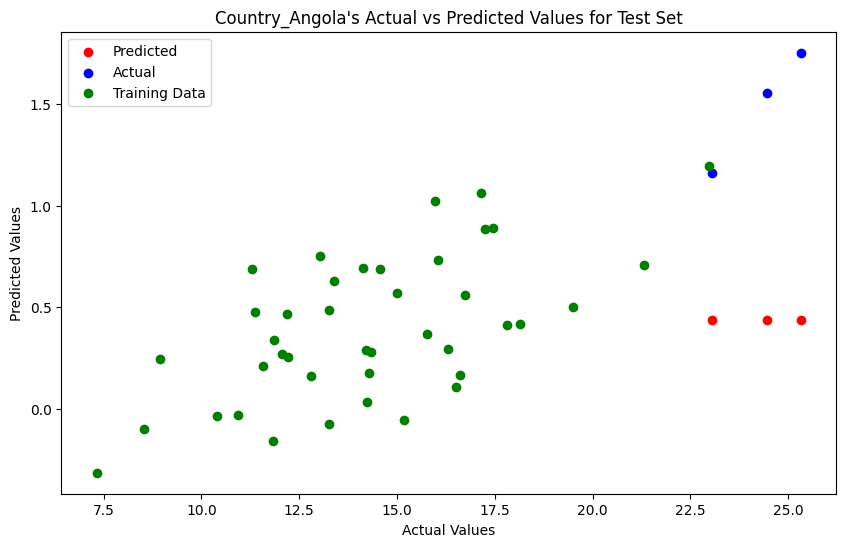

Epoch 1/50
8/8 [==============================] - 4s 70ms/step - loss: 0.0677 - mae: 0.2887 - val_loss: 0.1957 - val_mae: 0.6142
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0706 - mae: 0.3080 - val_loss: 0.1431 - val_mae: 0.5216
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0624 - mae: 0.2795 - val_loss: 0.0727 - val_mae: 0.3624
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0688 - mae: 0.2870 - val_loss: 0.1280 - val_mae: 0.4919
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0636 - mae: 0.2802 - val_loss: 0.1154 - val_mae: 0.4655
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0627 - mae: 0.2843 - val_loss: 0.0531 - val_mae: 0.3035
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0742 - mae: 0.3117 - val_loss: 0.2232 - val_mae: 0.6575
Epoch 8/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0898 - mae: 0.3274 - val

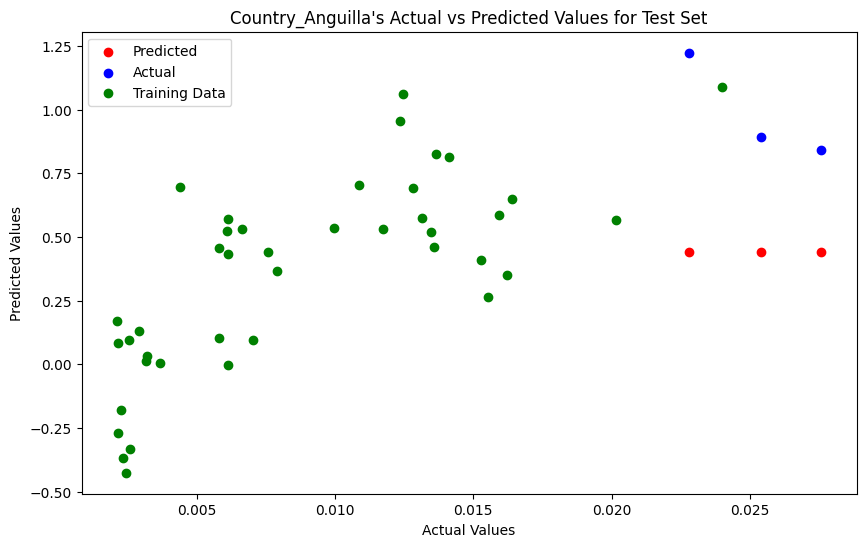

Epoch 1/50
8/8 [==============================] - 3s 72ms/step - loss: 0.0606 - mae: 0.2636 - val_loss: 0.0882 - val_mae: 0.3942
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0620 - mae: 0.2764 - val_loss: 0.0176 - val_mae: 0.1445
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0433 - mae: 0.2263 - val_loss: 0.0106 - val_mae: 0.1449
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0521 - mae: 0.2483 - val_loss: 0.0109 - val_mae: 0.1451
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0494 - mae: 0.2539 - val_loss: 0.0157 - val_mae: 0.1450
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0457 - mae: 0.2319 - val_loss: 0.0203 - val_mae: 0.1447
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0476 - mae: 0.2369 - val_loss: 0.0147 - val_mae: 0.1451
Epoch 8/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0389 - mae: 0.2201 - val

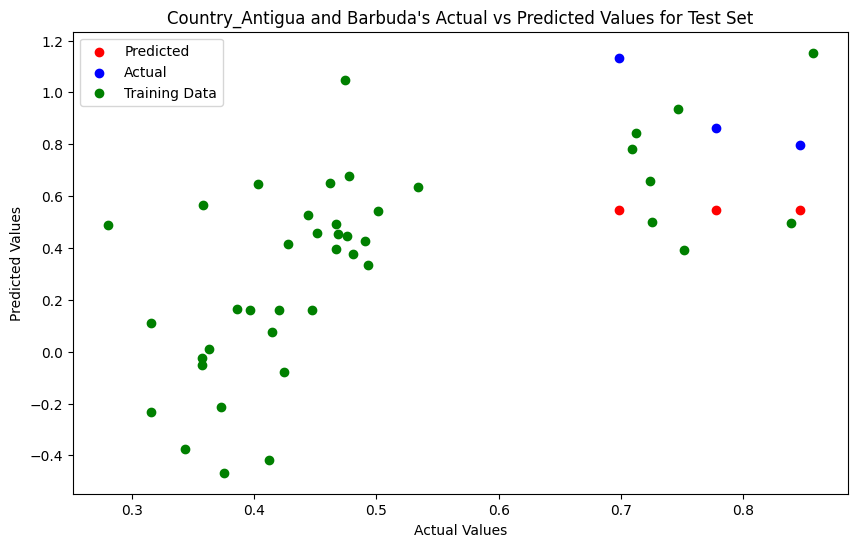

Epoch 1/50
8/8 [==============================] - 3s 81ms/step - loss: 0.0546 - mae: 0.2527 - val_loss: 0.3521 - val_mae: 0.8392
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0518 - mae: 0.2838 - val_loss: 0.2366 - val_mae: 0.6879
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0493 - mae: 0.2441 - val_loss: 0.1614 - val_mae: 0.5681
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0454 - mae: 0.2549 - val_loss: 0.3110 - val_mae: 0.7886
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0525 - mae: 0.2739 - val_loss: 0.2171 - val_mae: 0.6589
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0462 - mae: 0.2576 - val_loss: 0.2732 - val_mae: 0.7392
Epoch 7/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0436 - mae: 0.2475 - val_loss: 0.2161 - val_mae: 0.6575
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0447 - mae: 0.2385 - val

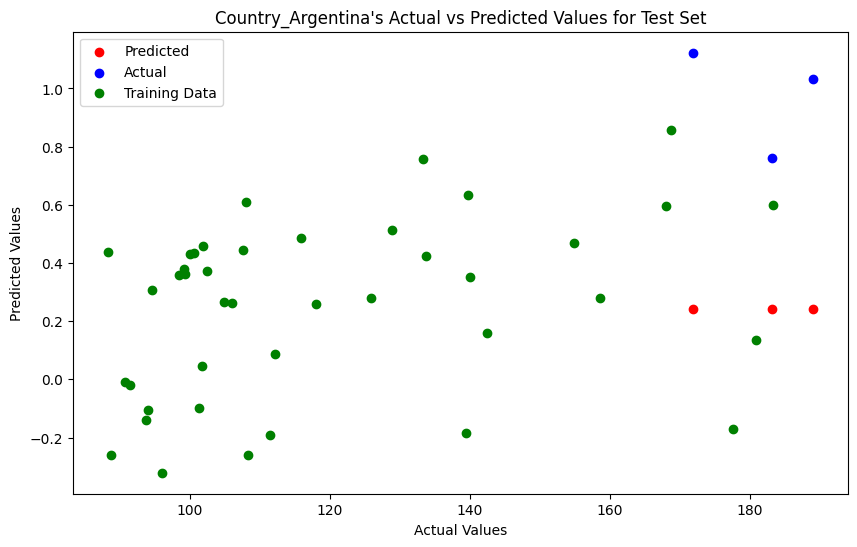

Epoch 1/50
8/8 [==============================] - 4s 69ms/step - loss: 0.0889 - mae: 0.3338 - val_loss: 0.2040 - val_mae: 0.6364
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0794 - mae: 0.3190 - val_loss: 0.1811 - val_mae: 0.5992
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0764 - mae: 0.3109 - val_loss: 0.2291 - val_mae: 0.6746
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0733 - mae: 0.3064 - val_loss: 0.2155 - val_mae: 0.6541
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0730 - mae: 0.3055 - val_loss: 0.2265 - val_mae: 0.6708
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0740 - mae: 0.3082 - val_loss: 0.2381 - val_mae: 0.6878
Epoch 7/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0745 - mae: 0.3127 - val_loss: 0.2048 - val_mae: 0.6376
Epoch 8/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0746 - mae: 0.3102 - val

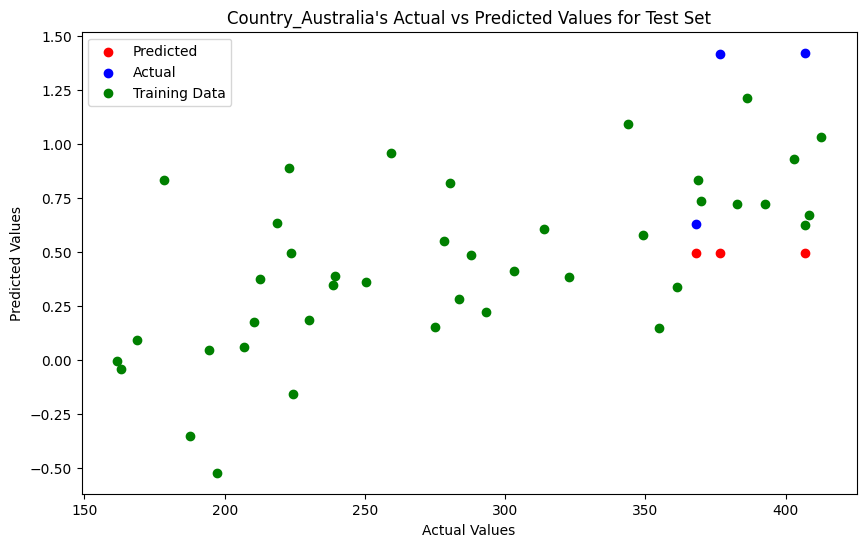

Epoch 1/50
8/8 [==============================] - 3s 71ms/step - loss: 0.2579 - mae: 0.6110 - val_loss: 1.0706 - val_mae: 1.5706
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.2445 - mae: 0.5976 - val_loss: 1.0429 - val_mae: 1.5429
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.2434 - mae: 0.5938 - val_loss: 1.0233 - val_mae: 1.5233
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.2525 - mae: 0.6035 - val_loss: 1.0195 - val_mae: 1.5195
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.2436 - mae: 0.5946 - val_loss: 1.1561 - val_mae: 1.6561
Epoch 6/50
8/8 [==============================] - 0s 13ms/step - loss: 0.2504 - mae: 0.6009 - val_loss: 1.1151 - val_mae: 1.6151
Epoch 7/50
8/8 [==============================] - 0s 13ms/step - loss: 0.2718 - mae: 0.6290 - val_loss: 0.9425 - val_mae: 1.4425
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.2514 - mae: 0.6096 - val

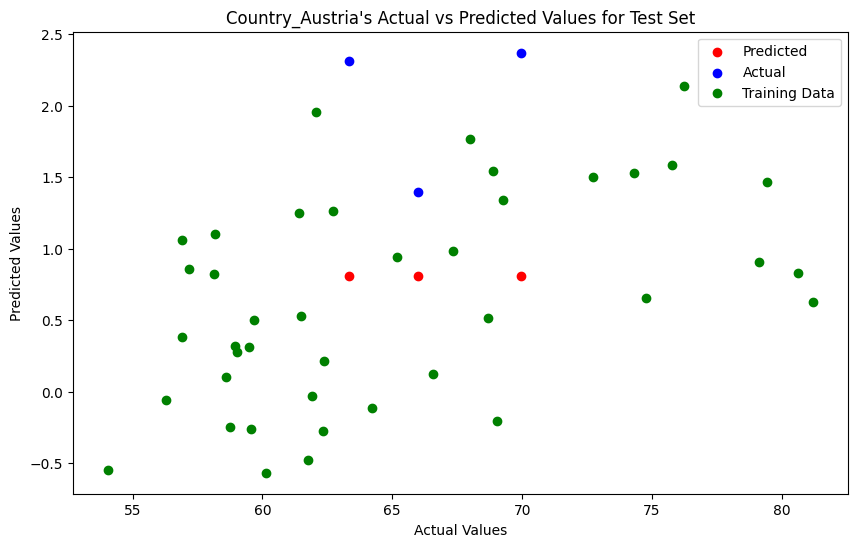

Epoch 1/50
8/8 [==============================] - 3s 79ms/step - loss: 0.0955 - mae: 0.3619 - val_loss: 0.2384 - val_mae: 0.6818
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0513 - mae: 0.2745 - val_loss: 0.2246 - val_mae: 0.6604
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0466 - mae: 0.2600 - val_loss: 0.2075 - val_mae: 0.6351
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0438 - mae: 0.2364 - val_loss: 0.1470 - val_mae: 0.5329
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0534 - mae: 0.2611 - val_loss: 0.3770 - val_mae: 0.8616
Epoch 6/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0480 - mae: 0.2588 - val_loss: 0.1315 - val_mae: 0.5017
Epoch 7/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0460 - mae: 0.2583 - val_loss: 0.3389 - val_mae: 0.8169
Epoch 8/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0443 - mae: 0.2440 - val

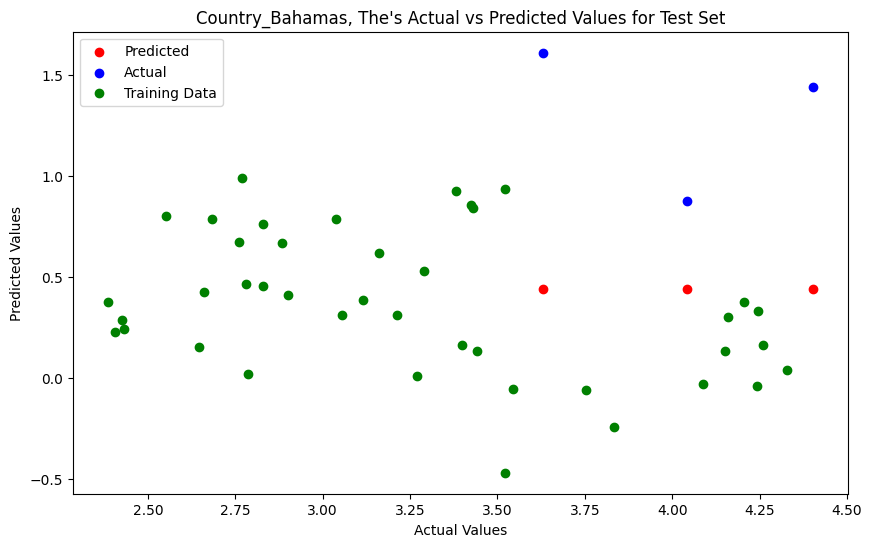

Epoch 1/50
8/8 [==============================] - 3s 75ms/step - loss: 0.0695 - mae: 0.2949 - val_loss: 0.1793 - val_mae: 0.5867
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0541 - mae: 0.2569 - val_loss: 0.0730 - val_mae: 0.3629
Epoch 3/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0506 - mae: 0.2484 - val_loss: 0.0801 - val_mae: 0.3819
Epoch 4/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0474 - mae: 0.2424 - val_loss: 0.0774 - val_mae: 0.3747
Epoch 5/50
8/8 [==============================] - 0s 26ms/step - loss: 0.0450 - mae: 0.2283 - val_loss: 0.0597 - val_mae: 0.3240
Epoch 6/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0427 - mae: 0.2272 - val_loss: 0.0489 - val_mae: 0.2886
Epoch 7/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0422 - mae: 0.2210 - val_loss: 0.0726 - val_mae: 0.3617
Epoch 8/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0381 - mae: 0.2000 - val

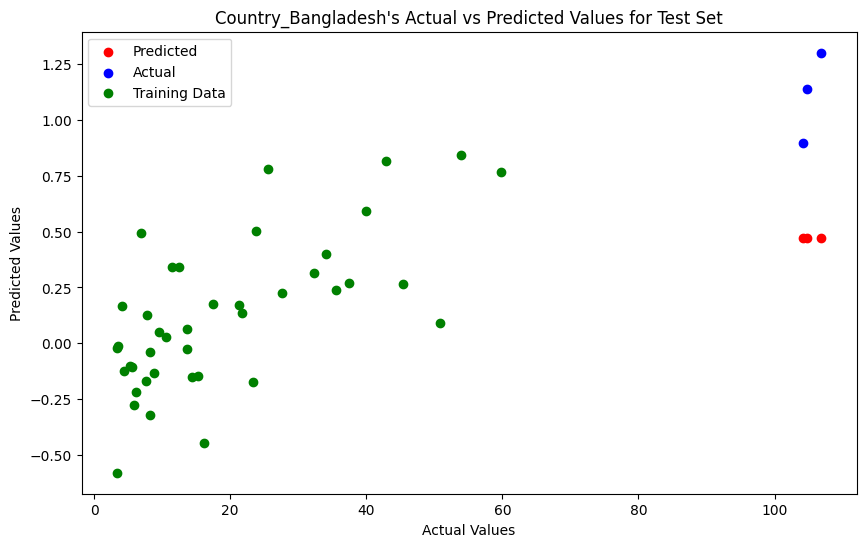

Epoch 1/50
8/8 [==============================] - 4s 73ms/step - loss: 0.0778 - mae: 0.2893 - val_loss: 0.1232 - val_mae: 0.4354
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0713 - mae: 0.2749 - val_loss: 0.0289 - val_mae: 0.2397
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0491 - mae: 0.2293 - val_loss: 0.0659 - val_mae: 0.2710
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0483 - mae: 0.2450 - val_loss: 0.0349 - val_mae: 0.2433
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0431 - mae: 0.2419 - val_loss: 0.0299 - val_mae: 0.2417
Epoch 6/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0620 - mae: 0.2818 - val_loss: 0.0450 - val_mae: 0.2381
Epoch 7/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0913 - mae: 0.3312 - val_loss: 0.0465 - val_mae: 0.2261
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0707 - mae: 0.2864 - val

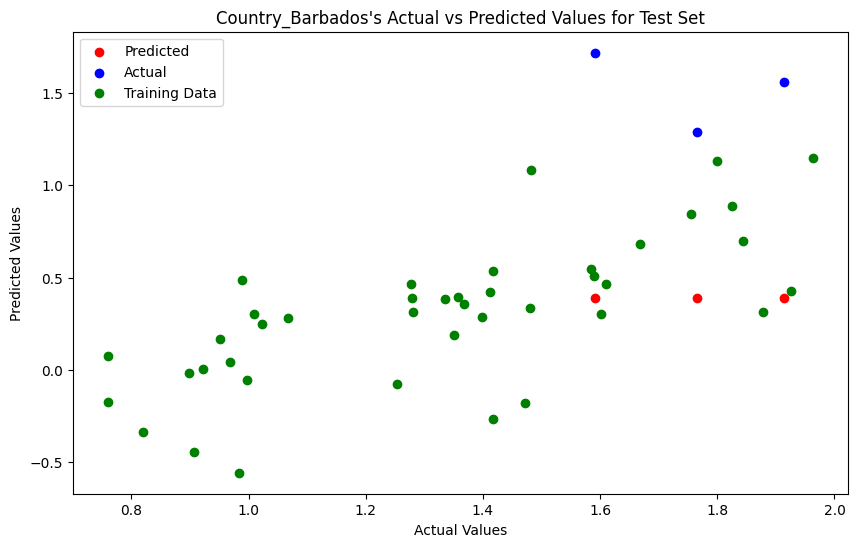

Epoch 1/50
8/8 [==============================] - 3s 78ms/step - loss: 0.0907 - mae: 0.3439 - val_loss: 0.2095 - val_mae: 0.4837
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0689 - mae: 0.3012 - val_loss: 0.1867 - val_mae: 0.4606
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0394 - mae: 0.2264 - val_loss: 0.1215 - val_mae: 0.4071
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0509 - mae: 0.2645 - val_loss: 0.1261 - val_mae: 0.4071
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0672 - mae: 0.2573 - val_loss: 0.3166 - val_mae: 0.6910
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0544 - mae: 0.2657 - val_loss: 0.1461 - val_mae: 0.4221
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0434 - mae: 0.2327 - val_loss: 0.2140 - val_mae: 0.5037
Epoch 8/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0332 - mae: 0.2051 - val

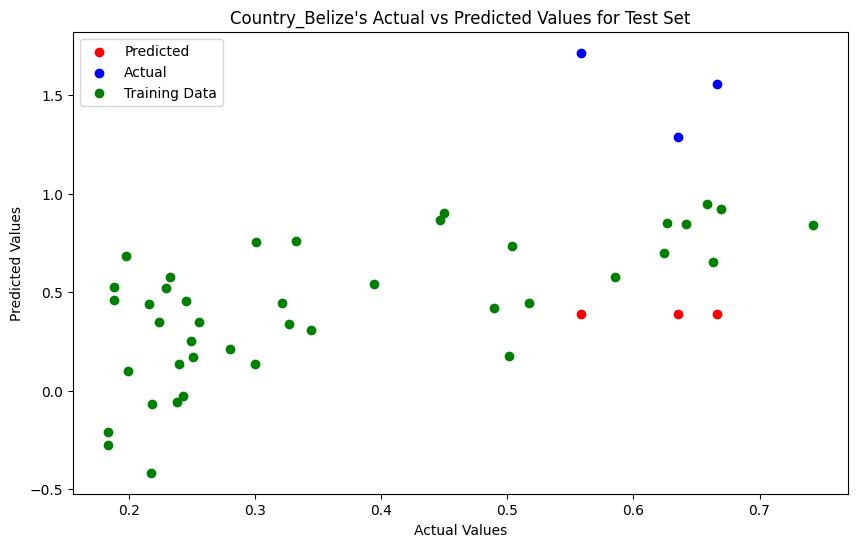

Epoch 1/50
8/8 [==============================] - 3s 75ms/step - loss: 0.0548 - mae: 0.2629 - val_loss: 0.0324 - val_mae: 0.2208
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0640 - mae: 0.2887 - val_loss: 0.0114 - val_mae: 0.1193
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0569 - mae: 0.2732 - val_loss: 0.0500 - val_mae: 0.2983
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0353 - mae: 0.2146 - val_loss: 0.0079 - val_mae: 0.1161
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0395 - mae: 0.2378 - val_loss: 0.0112 - val_mae: 0.1067
Epoch 6/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0311 - mae: 0.1967 - val_loss: 0.0203 - val_mae: 0.1780
Epoch 7/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0317 - mae: 0.1976 - val_loss: 0.0059 - val_mae: 0.0990
Epoch 8/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0363 - mae: 0.2043 - val

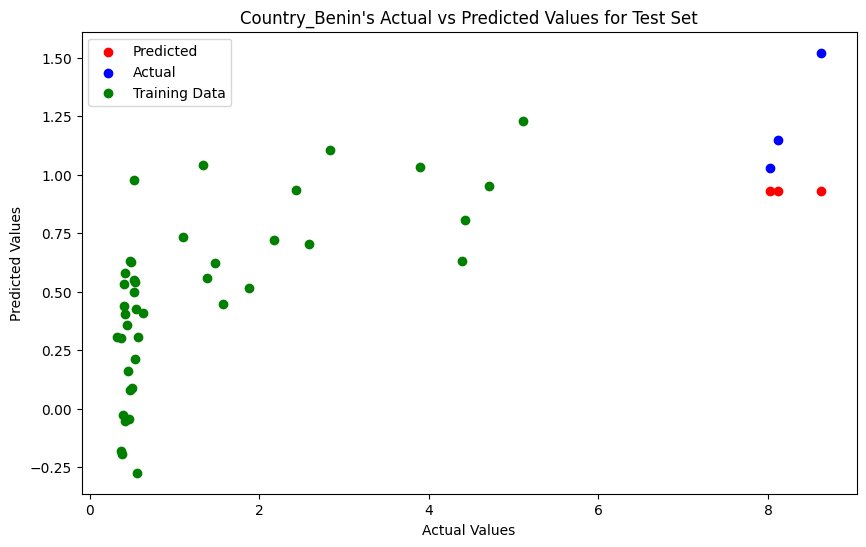

Epoch 1/50
8/8 [==============================] - 3s 74ms/step - loss: 0.0770 - mae: 0.3143 - val_loss: 0.0509 - val_mae: 0.3039
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0606 - mae: 0.2711 - val_loss: 0.0782 - val_mae: 0.3822
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0762 - mae: 0.3162 - val_loss: 0.0661 - val_mae: 0.3488
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0516 - mae: 0.2610 - val_loss: 0.0139 - val_mae: 0.1327
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0519 - mae: 0.2688 - val_loss: 0.0319 - val_mae: 0.2323
Epoch 6/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0373 - mae: 0.2239 - val_loss: 0.0133 - val_mae: 0.1293
Epoch 7/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0545 - mae: 0.2713 - val_loss: 0.0181 - val_mae: 0.1627
Epoch 8/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0360 - mae: 0.2218 - val

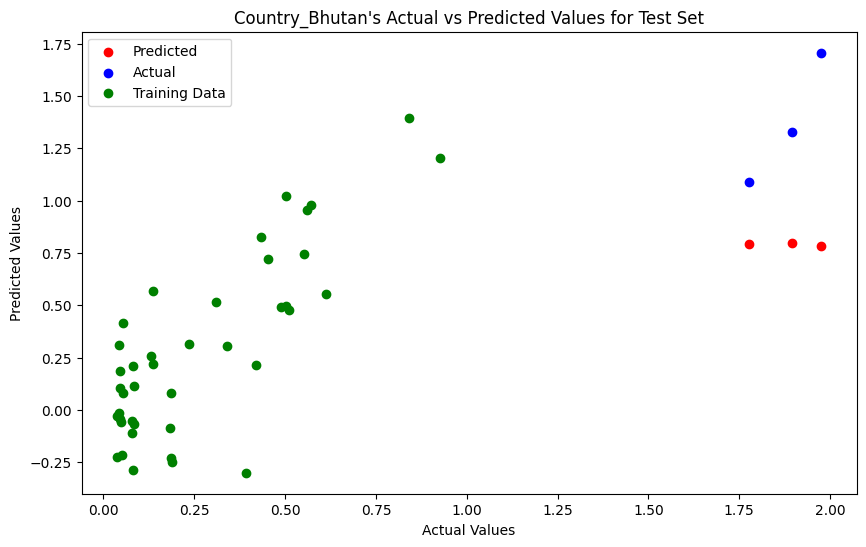

Epoch 1/50
8/8 [==============================] - 3s 73ms/step - loss: 0.0948 - mae: 0.3636 - val_loss: 0.4304 - val_mae: 0.8908
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0439 - mae: 0.2437 - val_loss: 0.2579 - val_mae: 0.6576
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0289 - mae: 0.2052 - val_loss: 0.1920 - val_mae: 0.5482
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0273 - mae: 0.1907 - val_loss: 0.2014 - val_mae: 0.5651
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0245 - mae: 0.1824 - val_loss: 0.2785 - val_mae: 0.6882
Epoch 6/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0347 - mae: 0.2284 - val_loss: 0.1662 - val_mae: 0.4989
Epoch 7/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0303 - mae: 0.1899 - val_loss: 0.1668 - val_mae: 0.5001
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0288 - mae: 0.1934 - val

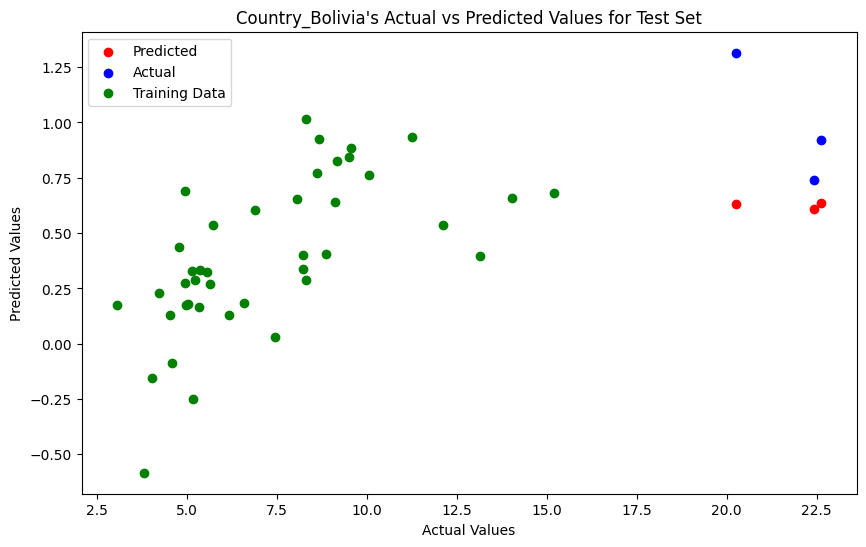

Epoch 1/50
8/8 [==============================] - 3s 69ms/step - loss: 0.2040 - mae: 0.5394 - val_loss: 0.3783 - val_mae: 0.7403
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1448 - mae: 0.4456 - val_loss: 0.4760 - val_mae: 0.8675
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.1333 - mae: 0.4231 - val_loss: 0.4684 - val_mae: 0.8060
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.1689 - mae: 0.4606 - val_loss: 0.5392 - val_mae: 0.9089
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.1283 - mae: 0.4115 - val_loss: 0.4507 - val_mae: 0.7084
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 0.1297 - mae: 0.4272 - val_loss: 0.5913 - val_mae: 0.9795
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 0.1626 - mae: 0.4461 - val_loss: 0.4118 - val_mae: 0.6801
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1339 - mae: 0.4275 - val

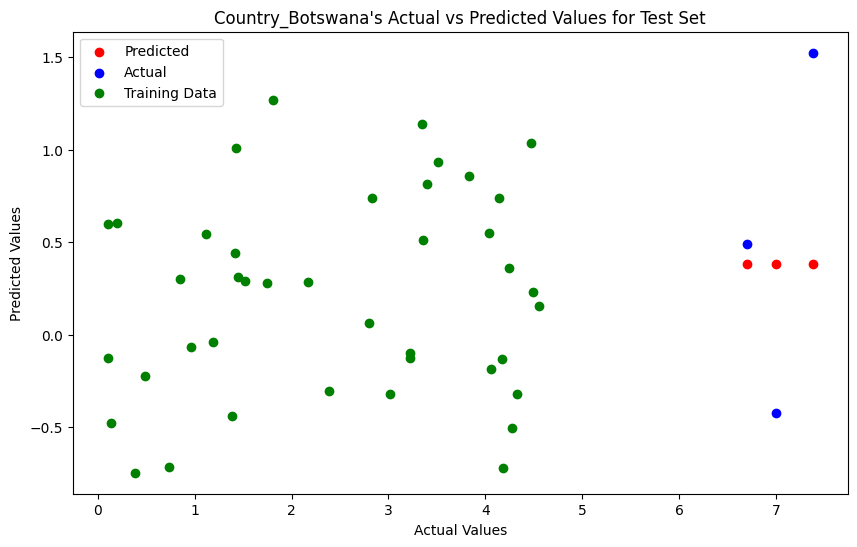

Epoch 1/50
8/8 [==============================] - 3s 72ms/step - loss: 0.0720 - mae: 0.3091 - val_loss: 0.2900 - val_mae: 0.7396
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0780 - mae: 0.3299 - val_loss: 0.4596 - val_mae: 0.9457
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0672 - mae: 0.3033 - val_loss: 0.2538 - val_mae: 0.6890
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0706 - mae: 0.3047 - val_loss: 0.4330 - val_mae: 0.9152
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0708 - mae: 0.3038 - val_loss: 0.3468 - val_mae: 0.8128
Epoch 6/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0681 - mae: 0.2996 - val_loss: 0.3580 - val_mae: 0.8265
Epoch 7/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0680 - mae: 0.2970 - val_loss: 0.3875 - val_mae: 0.8619
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0703 - mae: 0.2992 - val

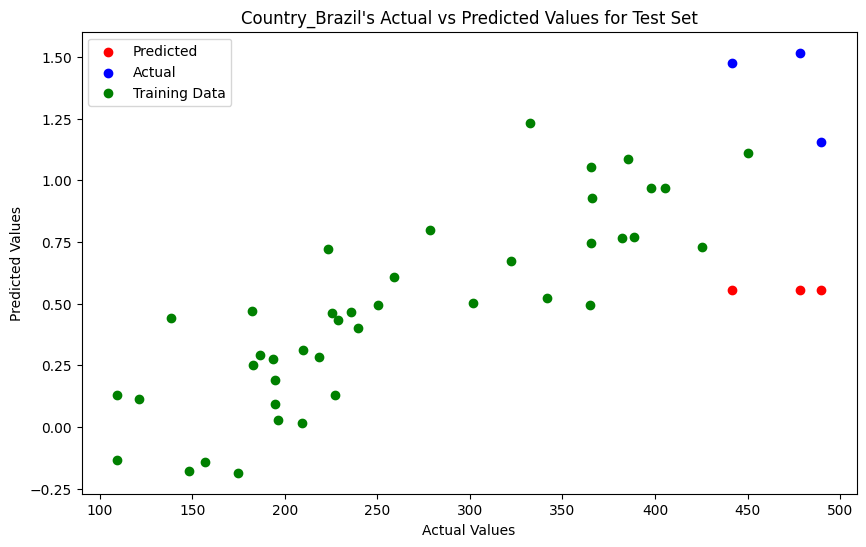

Epoch 1/50
8/8 [==============================] - 3s 72ms/step - loss: 0.0642 - mae: 0.2776 - val_loss: 0.1139 - val_mae: 0.4689
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0538 - mae: 0.2739 - val_loss: 0.0756 - val_mae: 0.3777
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0472 - mae: 0.2399 - val_loss: 0.0714 - val_mae: 0.3672
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0426 - mae: 0.2249 - val_loss: 0.0269 - val_mae: 0.2163
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0430 - mae: 0.2284 - val_loss: 0.0165 - val_mae: 0.1633
Epoch 6/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0424 - mae: 0.2326 - val_loss: 0.0137 - val_mae: 0.1459
Epoch 7/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0592 - mae: 0.2698 - val_loss: 0.0312 - val_mae: 0.2382
Epoch 8/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0595 - mae: 0.2780 - val

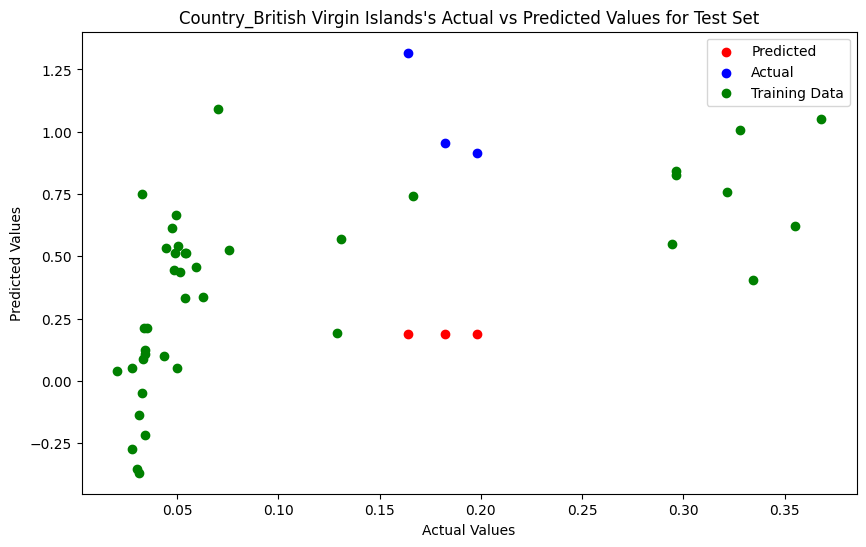

Epoch 1/50
8/8 [==============================] - 3s 73ms/step - loss: 0.2374 - mae: 0.5503 - val_loss: 0.4073 - val_mae: 0.8944
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.2326 - mae: 0.5660 - val_loss: 0.5525 - val_mae: 1.0513
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2357 - mae: 0.5612 - val_loss: 0.5703 - val_mae: 1.0697
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.2591 - mae: 0.6055 - val_loss: 0.3705 - val_mae: 0.8523
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.2346 - mae: 0.5686 - val_loss: 0.6438 - val_mae: 1.1438
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2371 - mae: 0.5614 - val_loss: 0.5333 - val_mae: 1.0313
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 0.2520 - mae: 0.5993 - val_loss: 0.4251 - val_mae: 0.9145
Epoch 8/50
8/8 [==============================] - 0s 13ms/step - loss: 0.2395 - mae: 0.5753 - val

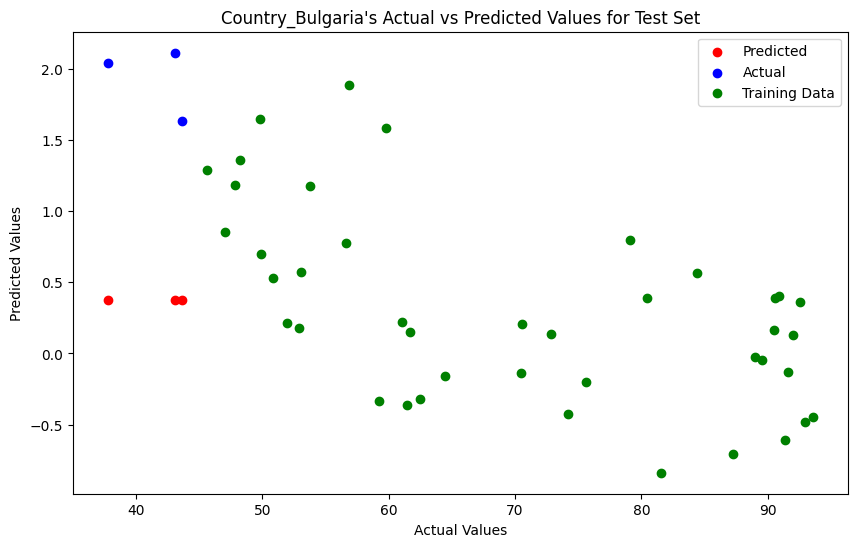

Epoch 1/50
8/8 [==============================] - 3s 73ms/step - loss: 0.0830 - mae: 0.3357 - val_loss: 0.2034 - val_mae: 0.6150
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0881 - mae: 0.3465 - val_loss: 0.2171 - val_mae: 0.5919
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0637 - mae: 0.3034 - val_loss: 0.1210 - val_mae: 0.3752
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0628 - mae: 0.2966 - val_loss: 0.1327 - val_mae: 0.4068
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0533 - mae: 0.2635 - val_loss: 0.1257 - val_mae: 0.3772
Epoch 6/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0469 - mae: 0.2537 - val_loss: 0.1430 - val_mae: 0.4073
Epoch 7/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0533 - mae: 0.2724 - val_loss: 0.1281 - val_mae: 0.4266
Epoch 8/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0722 - mae: 0.2981 - val

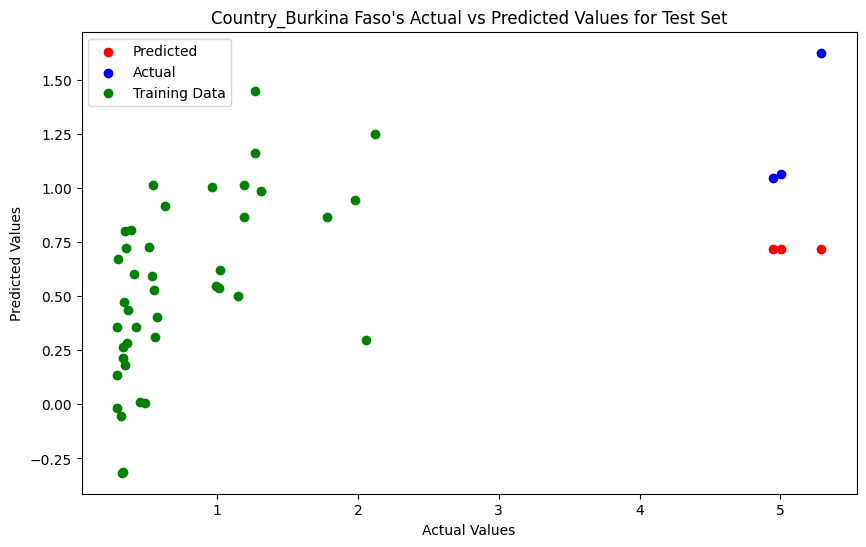

Epoch 1/50
8/8 [==============================] - 3s 72ms/step - loss: 0.1626 - mae: 0.4708 - val_loss: 0.0157 - val_mae: 0.1774
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.1025 - mae: 0.3621 - val_loss: 0.0142 - val_mae: 0.1684
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1026 - mae: 0.3645 - val_loss: 6.7035e-04 - val_mae: 0.0366
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.1040 - mae: 0.3753 - val_loss: 0.0020 - val_mae: 0.0640
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1004 - mae: 0.3523 - val_loss: 0.0038 - val_mae: 0.0874
Epoch 6/50
8/8 [==============================] - 0s 13ms/step - loss: 0.1320 - mae: 0.4181 - val_loss: 9.4941e-06 - val_mae: 0.0040
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 0.1181 - mae: 0.3757 - val_loss: 0.0062 - val_mae: 0.1108
Epoch 8/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1113 - mae: 0.37

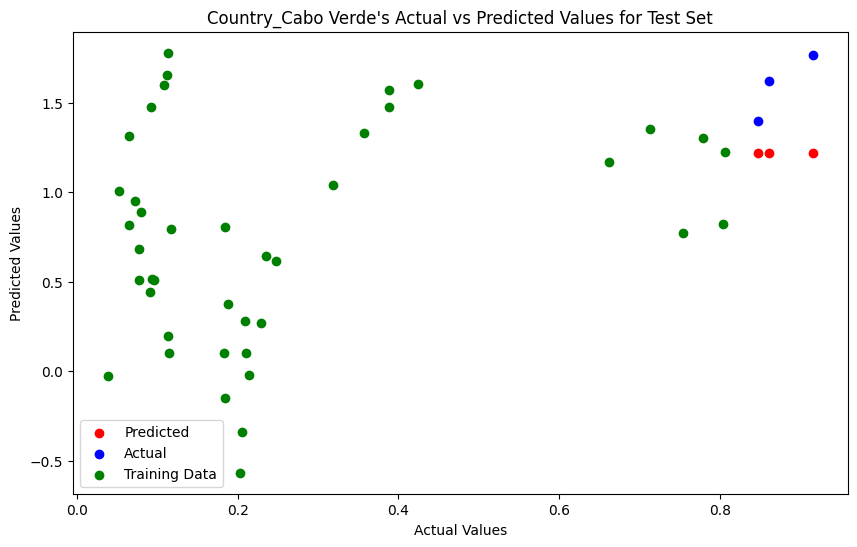

Epoch 1/50
8/8 [==============================] - 3s 73ms/step - loss: 0.0878 - mae: 0.3333 - val_loss: 0.0413 - val_mae: 0.2365
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0723 - mae: 0.2949 - val_loss: 0.0294 - val_mae: 0.2393
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0466 - mae: 0.2334 - val_loss: 0.0537 - val_mae: 0.2418
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0395 - mae: 0.2118 - val_loss: 0.0350 - val_mae: 0.2416
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0368 - mae: 0.2085 - val_loss: 0.0424 - val_mae: 0.2399
Epoch 6/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0374 - mae: 0.2088 - val_loss: 0.0438 - val_mae: 0.2392
Epoch 7/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0372 - mae: 0.2072 - val_loss: 0.0366 - val_mae: 0.2394
Epoch 8/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0367 - mae: 0.1986 - val

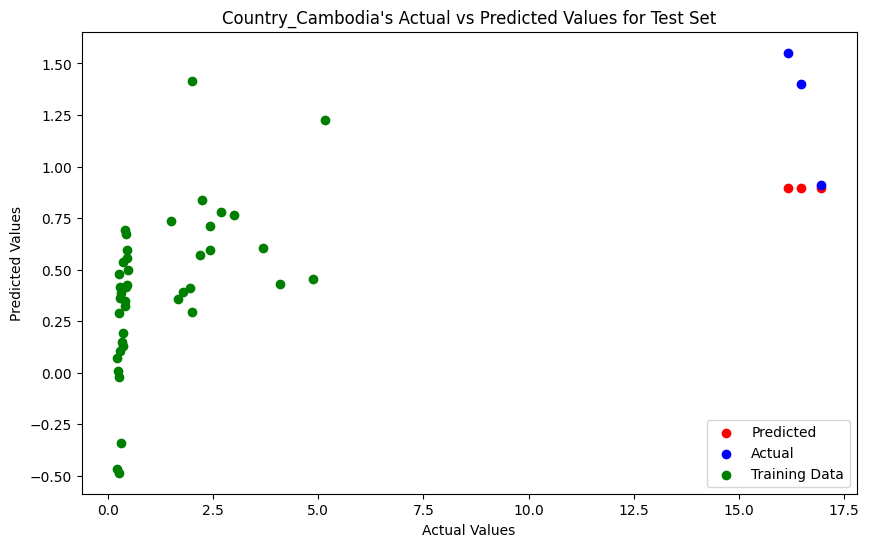

Epoch 1/50
8/8 [==============================] - 3s 74ms/step - loss: 0.1230 - mae: 0.4261 - val_loss: 0.2528 - val_mae: 0.6964
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0719 - mae: 0.2983 - val_loss: 0.1104 - val_mae: 0.4478
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0451 - mae: 0.2376 - val_loss: 0.0335 - val_mae: 0.2147
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0445 - mae: 0.2425 - val_loss: 0.0207 - val_mae: 0.1503
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0524 - mae: 0.2696 - val_loss: 0.0310 - val_mae: 0.2089
Epoch 6/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0700 - mae: 0.3095 - val_loss: 0.0327 - val_mae: 0.2210
Epoch 7/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0524 - mae: 0.2569 - val_loss: 0.1782 - val_mae: 0.5799
Epoch 8/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0496 - mae: 0.2692 - val

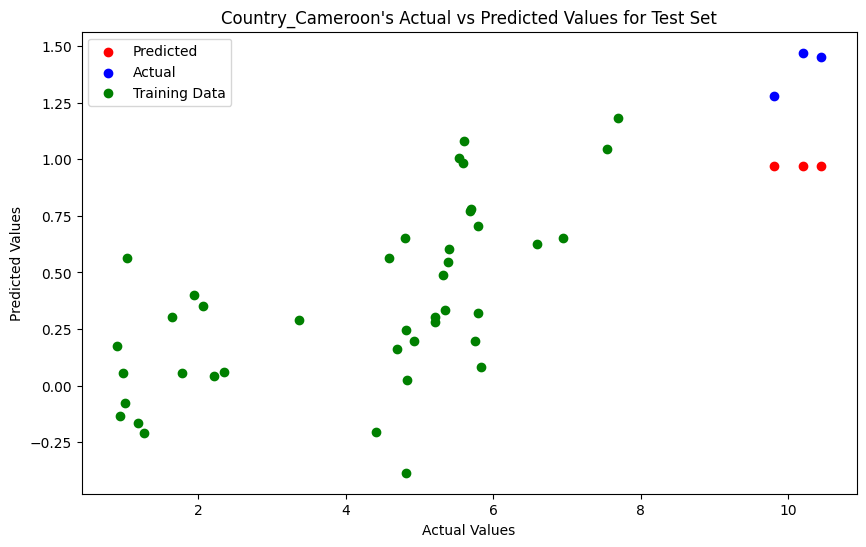

Epoch 1/50
8/8 [==============================] - 3s 75ms/step - loss: 0.3375 - mae: 0.6724 - val_loss: 0.1440 - val_mae: 0.4715
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.3240 - mae: 0.6794 - val_loss: 0.1219 - val_mae: 0.4715
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.3152 - mae: 0.6730 - val_loss: 0.1131 - val_mae: 0.4715
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.3260 - mae: 0.7034 - val_loss: 0.1120 - val_mae: 0.4715
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.3278 - mae: 0.6757 - val_loss: 0.1415 - val_mae: 0.4715
Epoch 6/50
8/8 [==============================] - 0s 14ms/step - loss: 0.3192 - mae: 0.6761 - val_loss: 0.1124 - val_mae: 0.4715
Epoch 7/50
8/8 [==============================] - 0s 15ms/step - loss: 0.3244 - mae: 0.6987 - val_loss: 0.1283 - val_mae: 0.4715
Epoch 8/50
8/8 [==============================] - 0s 15ms/step - loss: 0.3262 - mae: 0.6753 - val

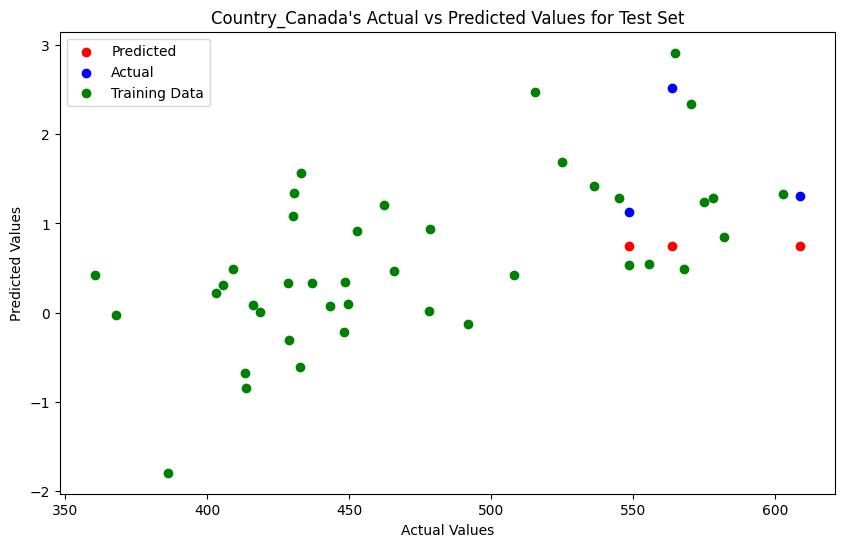

Epoch 1/50
8/8 [==============================] - 3s 76ms/step - loss: 0.0465 - mae: 0.2349 - val_loss: 0.0251 - val_mae: 0.1852
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0531 - mae: 0.2595 - val_loss: 0.0599 - val_mae: 0.3233
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0384 - mae: 0.2197 - val_loss: 0.0827 - val_mae: 0.3871
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0367 - mae: 0.2128 - val_loss: 0.0475 - val_mae: 0.2825
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0424 - mae: 0.2401 - val_loss: 0.0463 - val_mae: 0.2785
Epoch 6/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0383 - mae: 0.2185 - val_loss: 0.1005 - val_mae: 0.4313
Epoch 7/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0412 - mae: 0.2348 - val_loss: 0.0526 - val_mae: 0.3007
Epoch 8/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0448 - mae: 0.2465 - val

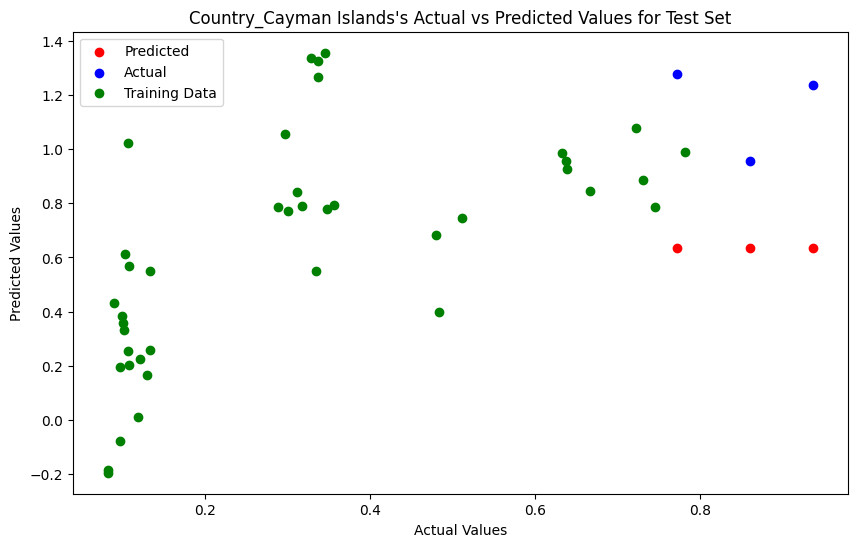

Epoch 1/50
8/8 [==============================] - 3s 79ms/step - loss: 0.0688 - mae: 0.2714 - val_loss: 0.2405 - val_mae: 0.6637
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0606 - mae: 0.2790 - val_loss: 0.1645 - val_mae: 0.5234
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0418 - mae: 0.2350 - val_loss: 0.2233 - val_mae: 0.6479
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0385 - mae: 0.2100 - val_loss: 0.1377 - val_mae: 0.5005
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0367 - mae: 0.2087 - val_loss: 0.1785 - val_mae: 0.5785
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0334 - mae: 0.2045 - val_loss: 0.1459 - val_mae: 0.5122
Epoch 7/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0341 - mae: 0.2041 - val_loss: 0.1718 - val_mae: 0.5458
Epoch 8/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0417 - mae: 0.2386 - val

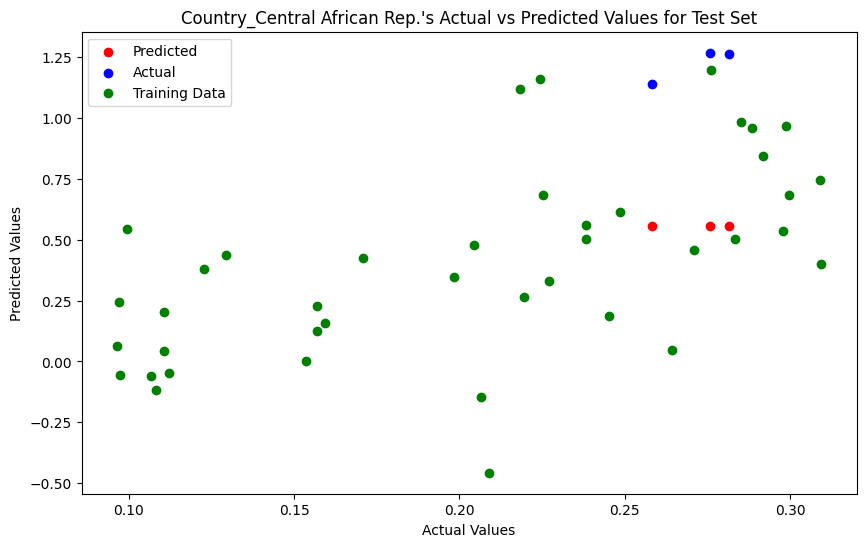

Epoch 1/50
8/8 [==============================] - 3s 115ms/step - loss: 0.0788 - mae: 0.3379 - val_loss: 0.1054 - val_mae: 0.3984
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0741 - mae: 0.3205 - val_loss: 0.0417 - val_mae: 0.2275
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0606 - mae: 0.2956 - val_loss: 0.0359 - val_mae: 0.2300
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0517 - mae: 0.2783 - val_loss: 0.0389 - val_mae: 0.2278
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0531 - mae: 0.2752 - val_loss: 0.0365 - val_mae: 0.2322
Epoch 6/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0493 - mae: 0.2509 - val_loss: 0.0510 - val_mae: 0.2275
Epoch 7/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0473 - mae: 0.2579 - val_loss: 0.0486 - val_mae: 0.2238
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0434 - mae: 0.2385 - va

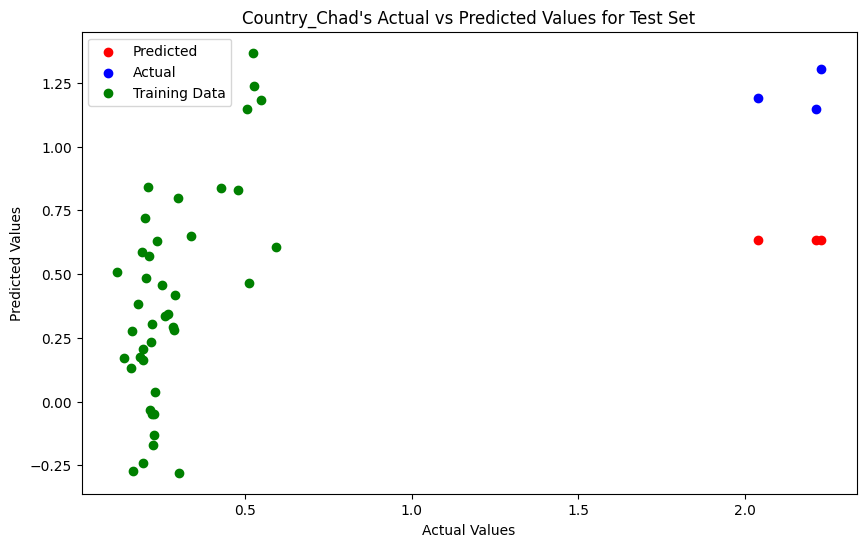

Epoch 1/50
8/8 [==============================] - 3s 74ms/step - loss: 0.0611 - mae: 0.2853 - val_loss: 0.2086 - val_mae: 0.6204
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0368 - mae: 0.2161 - val_loss: 0.0711 - val_mae: 0.3314
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0388 - mae: 0.2228 - val_loss: 0.1329 - val_mae: 0.4831
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0379 - mae: 0.2370 - val_loss: 0.1138 - val_mae: 0.4419
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0376 - mae: 0.2228 - val_loss: 0.1149 - val_mae: 0.4444
Epoch 6/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0384 - mae: 0.2370 - val_loss: 0.1265 - val_mae: 0.4696
Epoch 7/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0386 - mae: 0.2249 - val_loss: 0.0901 - val_mae: 0.3844
Epoch 8/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0374 - mae: 0.2233 - val

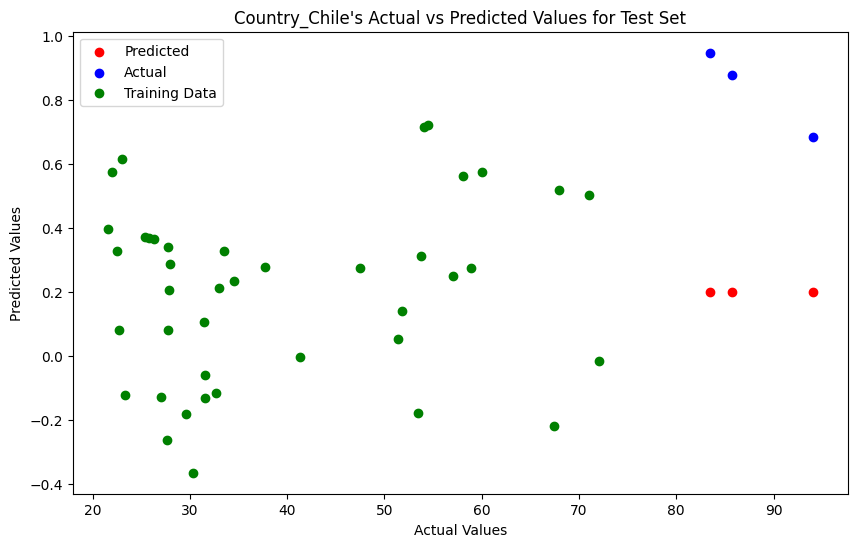

Epoch 1/50
8/8 [==============================] - 3s 72ms/step - loss: 0.0612 - mae: 0.2868 - val_loss: 0.2702 - val_mae: 0.7081
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0590 - mae: 0.2823 - val_loss: 0.2638 - val_mae: 0.6990
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0581 - mae: 0.2829 - val_loss: 0.2799 - val_mae: 0.7216
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0571 - mae: 0.2782 - val_loss: 0.2544 - val_mae: 0.6854
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0566 - mae: 0.2778 - val_loss: 0.2886 - val_mae: 0.7336
Epoch 6/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0565 - mae: 0.2801 - val_loss: 0.3089 - val_mae: 0.7607
Epoch 7/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0588 - mae: 0.2848 - val_loss: 0.2832 - val_mae: 0.7262
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0588 - mae: 0.2886 - val

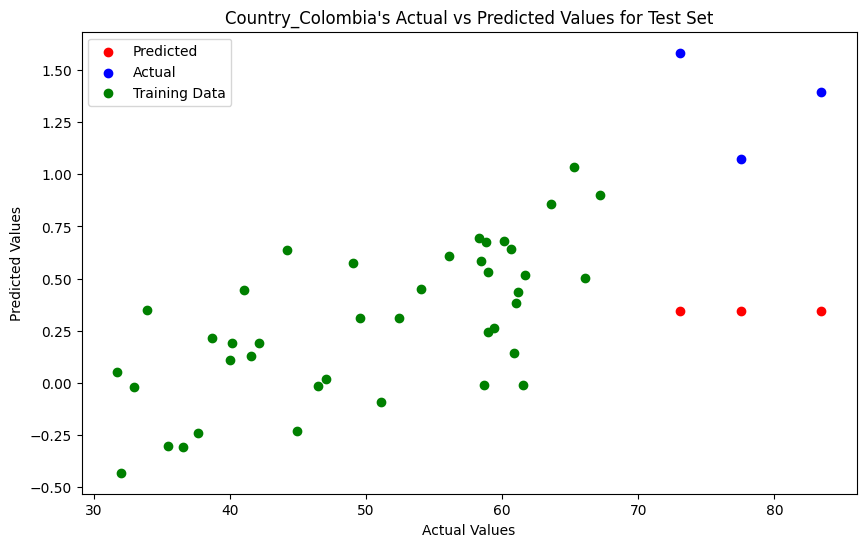

Epoch 1/50
8/8 [==============================] - 3s 70ms/step - loss: 0.0294 - mae: 0.1920 - val_loss: 0.0628 - val_mae: 0.2974
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0276 - mae: 0.1944 - val_loss: 0.1119 - val_mae: 0.3688
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0282 - mae: 0.1903 - val_loss: 0.0958 - val_mae: 0.3214
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0258 - mae: 0.1802 - val_loss: 0.1065 - val_mae: 0.3531
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0255 - mae: 0.1780 - val_loss: 0.0838 - val_mae: 0.2981
Epoch 6/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0238 - mae: 0.1774 - val_loss: 0.1258 - val_mae: 0.4039
Epoch 7/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0235 - mae: 0.1737 - val_loss: 0.0913 - val_mae: 0.3057
Epoch 8/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0269 - mae: 0.1885 - val

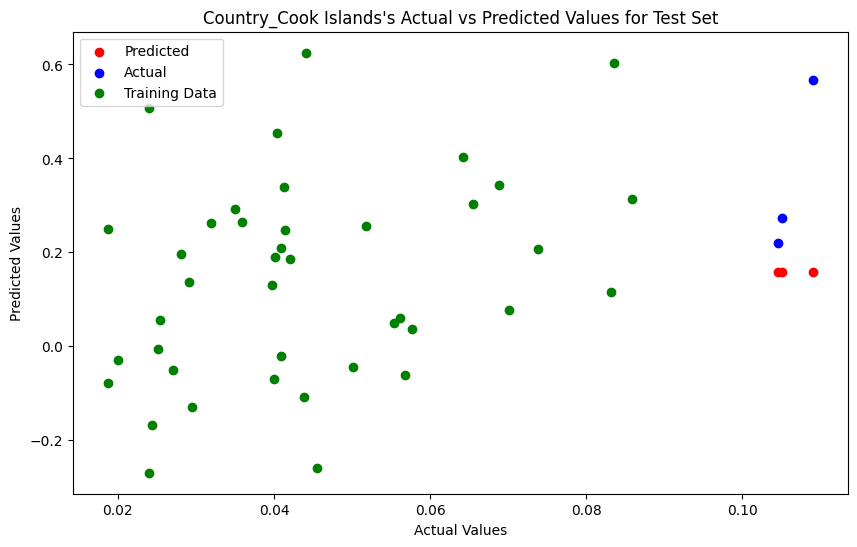

Epoch 1/50
8/8 [==============================] - 4s 73ms/step - loss: 0.1082 - mae: 0.3983 - val_loss: 0.1034 - val_mae: 0.4302
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0779 - mae: 0.3252 - val_loss: 0.3647 - val_mae: 0.8412
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0682 - mae: 0.3149 - val_loss: 0.1687 - val_mae: 0.5618
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0659 - mae: 0.2917 - val_loss: 0.2481 - val_mae: 0.6888
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0615 - mae: 0.2834 - val_loss: 0.2489 - val_mae: 0.6900
Epoch 6/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0598 - mae: 0.2817 - val_loss: 0.2472 - val_mae: 0.6875
Epoch 7/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0608 - mae: 0.2848 - val_loss: 0.2289 - val_mae: 0.6603
Epoch 8/50
8/8 [==============================] - 0s 26ms/step - loss: 0.0613 - mae: 0.2853 - val

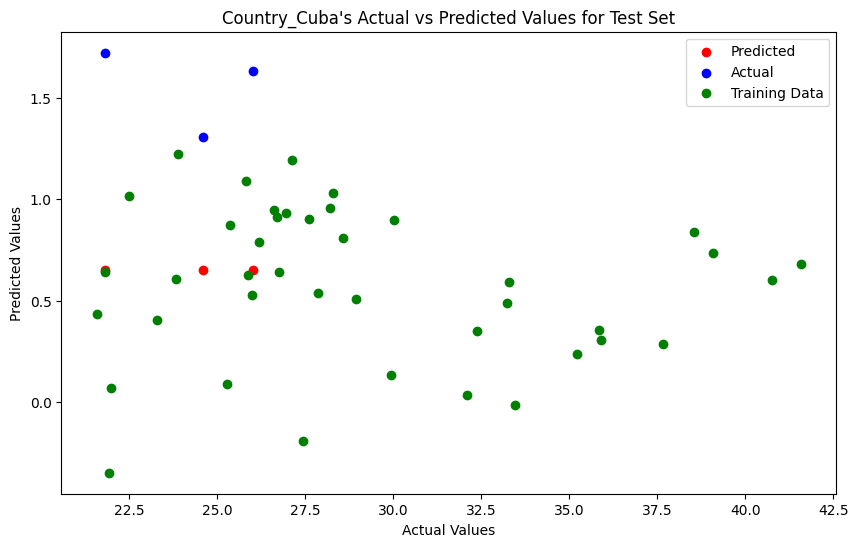

Epoch 1/50
8/8 [==============================] - 3s 110ms/step - loss: 0.1774 - mae: 0.4664 - val_loss: 0.2925 - val_mae: 0.7635
Epoch 2/50
8/8 [==============================] - 0s 23ms/step - loss: 0.1266 - mae: 0.3745 - val_loss: 0.0450 - val_mae: 0.2962
Epoch 3/50
8/8 [==============================] - 0s 22ms/step - loss: 0.1168 - mae: 0.3551 - val_loss: 0.1348 - val_mae: 0.5164
Epoch 4/50
8/8 [==============================] - 0s 25ms/step - loss: 0.1004 - mae: 0.3516 - val_loss: 0.0663 - val_mae: 0.3556
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1048 - mae: 0.3432 - val_loss: 0.0087 - val_mae: 0.1222
Epoch 6/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1529 - mae: 0.4444 - val_loss: 0.2993 - val_mae: 0.7512
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1684 - mae: 0.4794 - val_loss: 0.1570 - val_mae: 0.5597
Epoch 8/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1057 - mae: 0.3477 - va

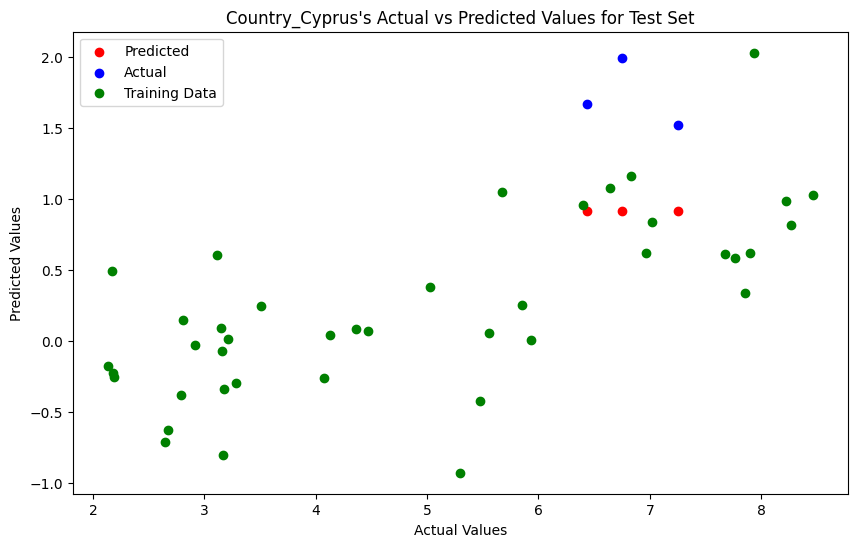

Epoch 1/50
8/8 [==============================] - 3s 75ms/step - loss: 0.3513 - mae: 0.7060 - val_loss: 0.8925 - val_mae: 1.3827
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.3514 - mae: 0.7124 - val_loss: 0.8814 - val_mae: 1.3704
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.3437 - mae: 0.6964 - val_loss: 0.7515 - val_mae: 1.2187
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.3373 - mae: 0.6946 - val_loss: 0.9428 - val_mae: 1.4377
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.3521 - mae: 0.7187 - val_loss: 0.8645 - val_mae: 1.3514
Epoch 6/50
8/8 [==============================] - 0s 14ms/step - loss: 0.3434 - mae: 0.7066 - val_loss: 0.7874 - val_mae: 1.2620
Epoch 7/50
8/8 [==============================] - 0s 14ms/step - loss: 0.3623 - mae: 0.7237 - val_loss: 0.7922 - val_mae: 1.2677
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.3785 - mae: 0.7716 - val

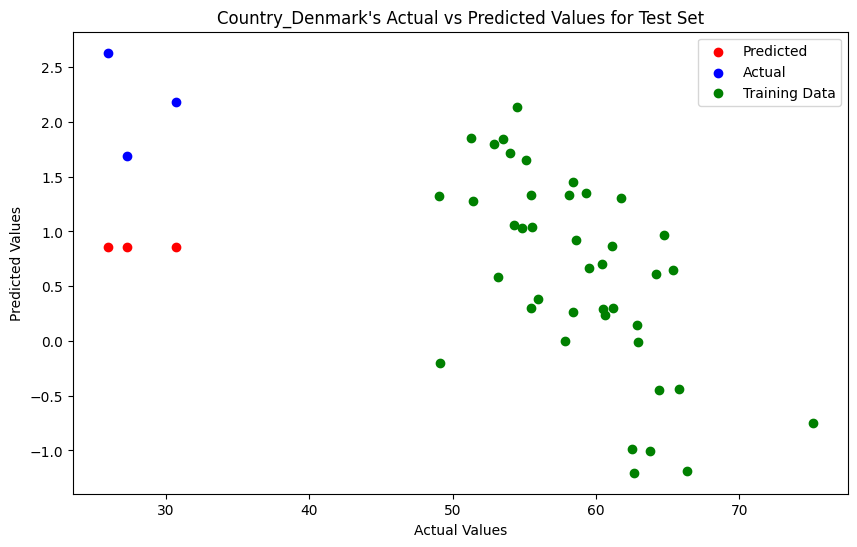

Epoch 1/50
8/8 [==============================] - 3s 71ms/step - loss: 0.1110 - mae: 0.4015 - val_loss: 0.5116 - val_mae: 0.9966
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1104 - mae: 0.4080 - val_loss: 0.2900 - val_mae: 0.7262
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0985 - mae: 0.3765 - val_loss: 0.2785 - val_mae: 0.7053
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0963 - mae: 0.3768 - val_loss: 0.3597 - val_mae: 0.8112
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0964 - mae: 0.3768 - val_loss: 0.4058 - val_mae: 0.8803
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0984 - mae: 0.3557 - val_loss: 0.2417 - val_mae: 0.6549
Epoch 7/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1013 - mae: 0.3701 - val_loss: 0.2808 - val_mae: 0.7115
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1120 - mae: 0.3930 - val

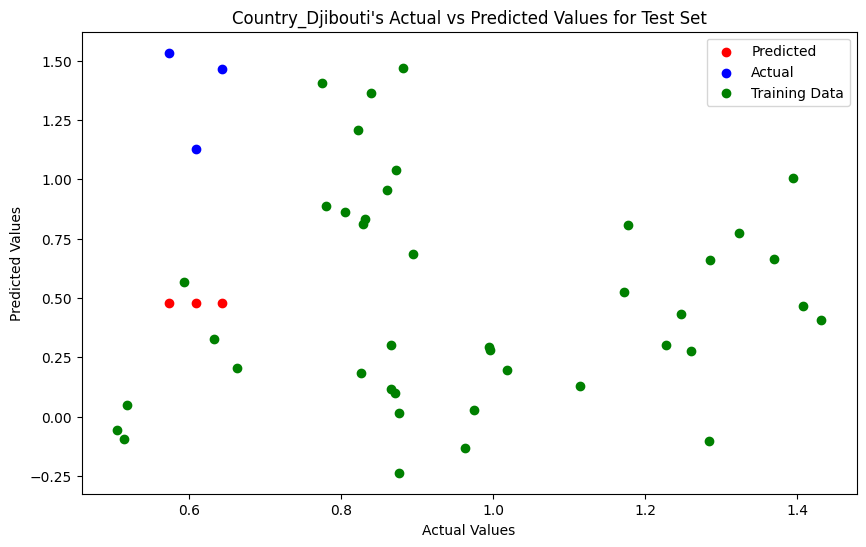

Epoch 1/50
8/8 [==============================] - 3s 73ms/step - loss: 0.0511 - mae: 0.2446 - val_loss: 0.1175 - val_mae: 0.4748
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0497 - mae: 0.2517 - val_loss: 0.0300 - val_mae: 0.2223
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0505 - mae: 0.2483 - val_loss: 0.0076 - val_mae: 0.1233
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0500 - mae: 0.2485 - val_loss: 0.0235 - val_mae: 0.1846
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0512 - mae: 0.2282 - val_loss: 0.0210 - val_mae: 0.1736
Epoch 6/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0408 - mae: 0.2312 - val_loss: 0.0089 - val_mae: 0.1129
Epoch 7/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0328 - mae: 0.2058 - val_loss: 0.0068 - val_mae: 0.1158
Epoch 8/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0348 - mae: 0.2012 - val

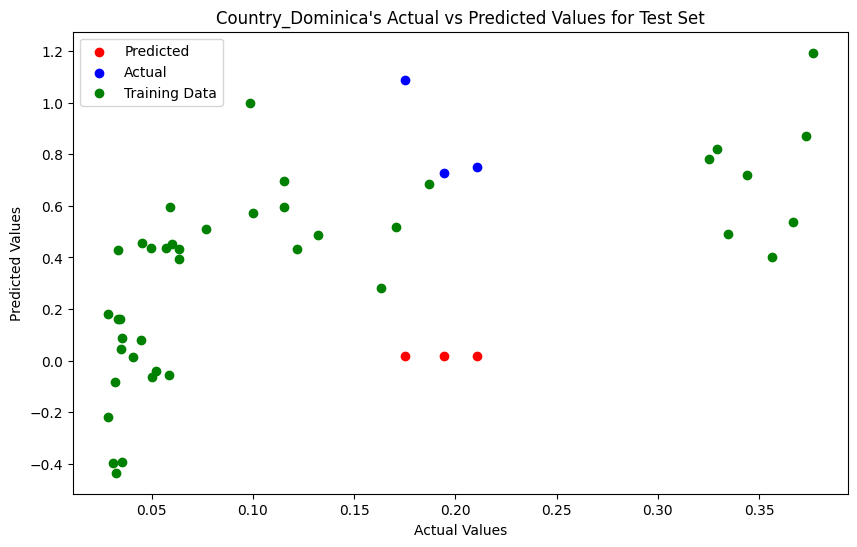

Epoch 1/50
8/8 [==============================] - 3s 78ms/step - loss: 0.1526 - mae: 0.4584 - val_loss: 0.0891 - val_mae: 0.4058
Epoch 2/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0893 - mae: 0.3537 - val_loss: 0.2627 - val_mae: 0.7155
Epoch 3/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0492 - mae: 0.2323 - val_loss: 0.0357 - val_mae: 0.2406
Epoch 4/50
8/8 [==============================] - 0s 30ms/step - loss: 0.0500 - mae: 0.2592 - val_loss: 0.0596 - val_mae: 0.3250
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0323 - mae: 0.2100 - val_loss: 0.0526 - val_mae: 0.3026
Epoch 6/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0302 - mae: 0.1985 - val_loss: 0.0290 - val_mae: 0.2108
Epoch 7/50
8/8 [==============================] - 0s 26ms/step - loss: 0.0301 - mae: 0.2060 - val_loss: 0.0339 - val_mae: 0.2328
Epoch 8/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0313 - mae: 0.2080 - val

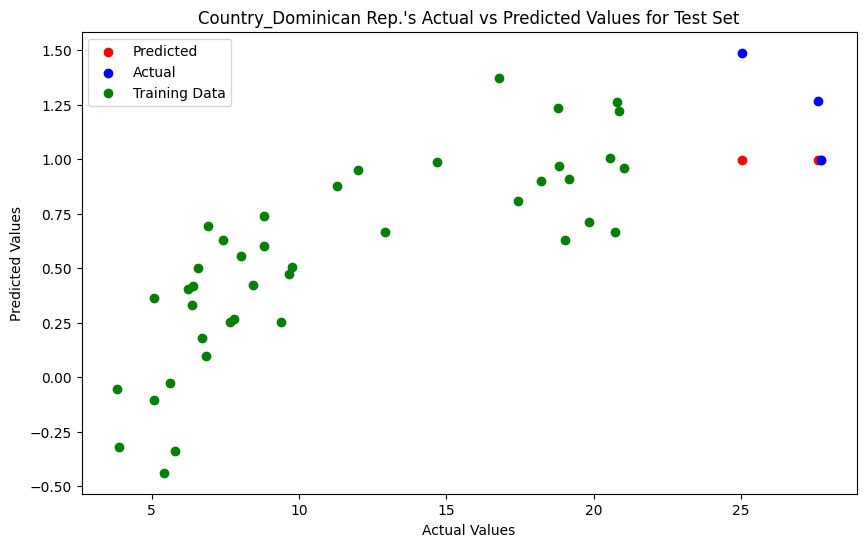

Epoch 1/50
8/8 [==============================] - 3s 71ms/step - loss: 0.0914 - mae: 0.3681 - val_loss: 0.3534 - val_mae: 0.8188
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0798 - mae: 0.3301 - val_loss: 0.2111 - val_mae: 0.6210
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0630 - mae: 0.2772 - val_loss: 0.1096 - val_mae: 0.4274
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0596 - mae: 0.2686 - val_loss: 0.1081 - val_mae: 0.4239
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0540 - mae: 0.2498 - val_loss: 0.0795 - val_mae: 0.3501
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0612 - mae: 0.2652 - val_loss: 0.1338 - val_mae: 0.4808
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0569 - mae: 0.2698 - val_loss: 0.1582 - val_mae: 0.5291
Epoch 8/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0556 - mae: 0.2645 - val

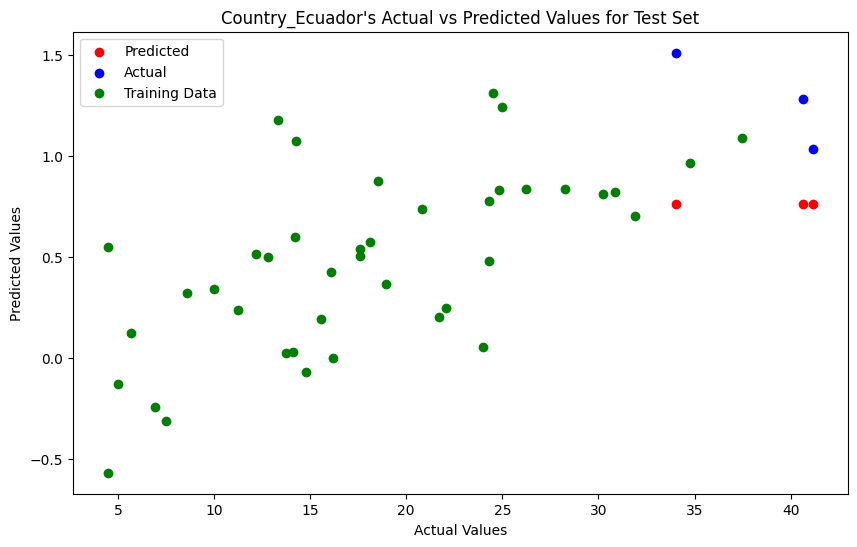

Epoch 1/50
8/8 [==============================] - 3s 72ms/step - loss: 0.0613 - mae: 0.2627 - val_loss: 0.1226 - val_mae: 0.3727
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0457 - mae: 0.2421 - val_loss: 0.1340 - val_mae: 0.4024
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0285 - mae: 0.1921 - val_loss: 0.1645 - val_mae: 0.4755
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0360 - mae: 0.2109 - val_loss: 0.2098 - val_mae: 0.5630
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0351 - mae: 0.2208 - val_loss: 0.1639 - val_mae: 0.4714
Epoch 6/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0276 - mae: 0.1870 - val_loss: 0.1506 - val_mae: 0.4411
Epoch 7/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0319 - mae: 0.1922 - val_loss: 0.2491 - val_mae: 0.6252
Epoch 8/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0371 - mae: 0.2245 - val

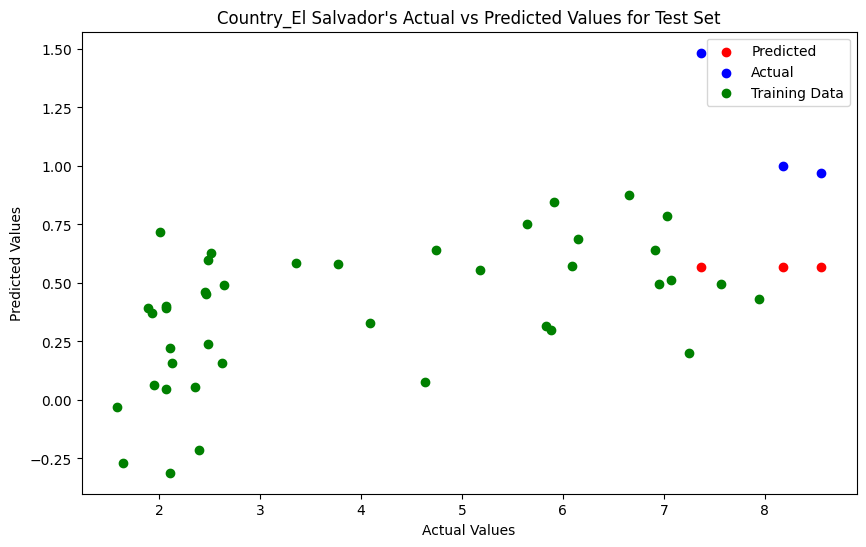

Epoch 1/50
8/8 [==============================] - 3s 70ms/step - loss: 0.0528 - mae: 0.2658 - val_loss: 0.0208 - val_mae: 0.2018
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0400 - mae: 0.2324 - val_loss: 7.4786e-04 - val_mae: 0.0333
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0249 - mae: 0.1803 - val_loss: 0.0098 - val_mae: 0.1395
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0233 - mae: 0.1718 - val_loss: 7.6455e-04 - val_mae: 0.0379
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0246 - mae: 0.1819 - val_loss: 0.0012 - val_mae: 0.0480
Epoch 6/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0236 - mae: 0.1653 - val_loss: 4.8378e-04 - val_mae: 0.0303
Epoch 7/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0228 - mae: 0.1674 - val_loss: 3.0372e-04 - val_mae: 0.0236
Epoch 8/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0197 - m

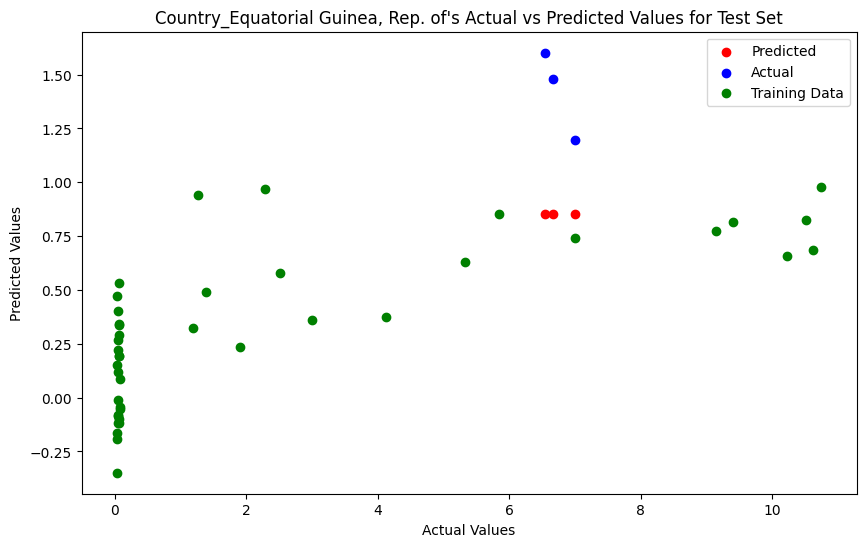

Epoch 1/50
8/8 [==============================] - 3s 74ms/step - loss: 0.4575 - mae: 0.8635 - val_loss: 1.1723 - val_mae: 1.6723
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.4796 - mae: 0.9009 - val_loss: 1.4809 - val_mae: 1.9809
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.4462 - mae: 0.8266 - val_loss: 1.2138 - val_mae: 1.7138
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.4299 - mae: 0.8182 - val_loss: 1.5176 - val_mae: 2.0176
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.4364 - mae: 0.8317 - val_loss: 1.2297 - val_mae: 1.7297
Epoch 6/50
8/8 [==============================] - 0s 21ms/step - loss: 0.4360 - mae: 0.8136 - val_loss: 1.3121 - val_mae: 1.8121
Epoch 7/50
8/8 [==============================] - 0s 24ms/step - loss: 0.4310 - mae: 0.8209 - val_loss: 1.3869 - val_mae: 1.8869
Epoch 8/50
8/8 [==============================] - 0s 24ms/step - loss: 0.4442 - mae: 0.8429 - val

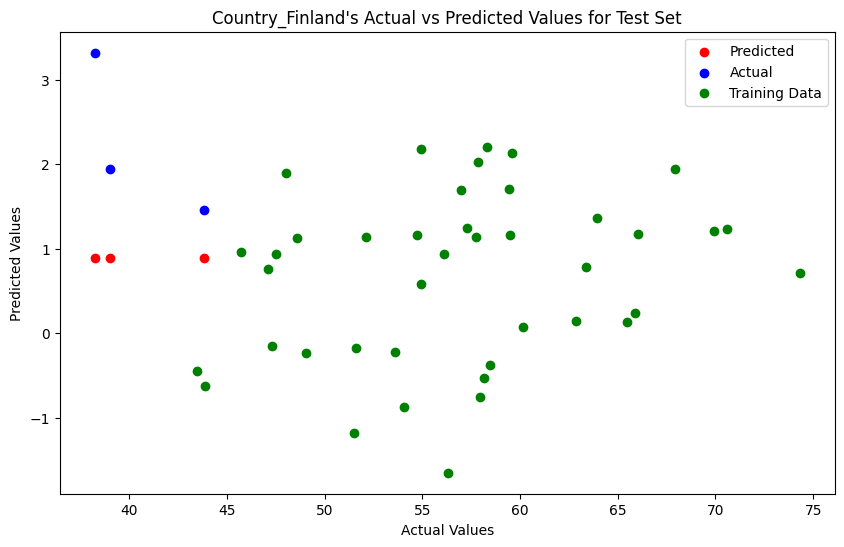

Epoch 1/50
8/8 [==============================] - 4s 120ms/step - loss: 0.0971 - mae: 0.3600 - val_loss: 0.0404 - val_mae: 0.2823
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0693 - mae: 0.3212 - val_loss: 0.0632 - val_mae: 0.3533
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0193 - mae: 0.1591 - val_loss: 0.0133 - val_mae: 0.1596
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0338 - mae: 0.2193 - val_loss: 0.0295 - val_mae: 0.2404
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0283 - mae: 0.2044 - val_loss: 9.4755e-04 - val_mae: 0.0328
Epoch 6/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0270 - mae: 0.1864 - val_loss: 0.0174 - val_mae: 0.1837
Epoch 7/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0210 - mae: 0.1725 - val_loss: 8.7276e-04 - val_mae: 0.0352
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0209 - mae: 0.1

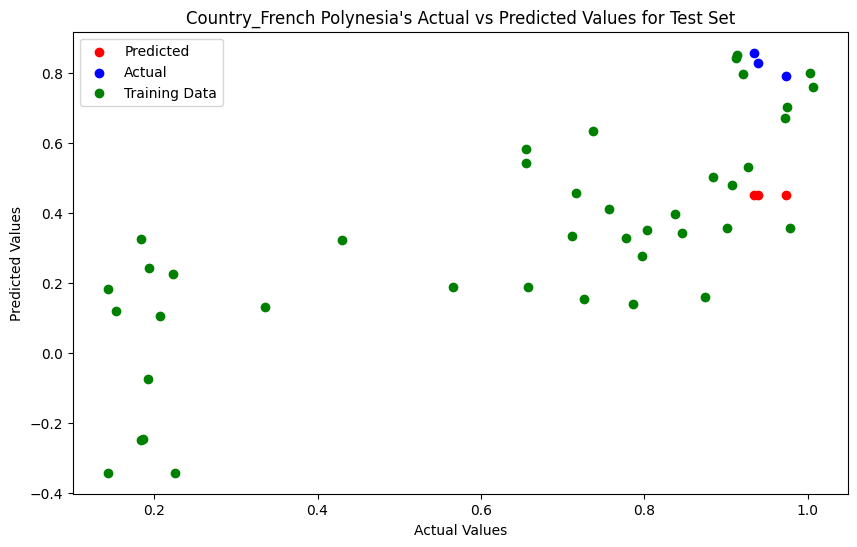

Epoch 1/50
8/8 [==============================] - 3s 75ms/step - loss: 0.0885 - mae: 0.3602 - val_loss: 0.2503 - val_mae: 0.6990
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0829 - mae: 0.3208 - val_loss: 0.1897 - val_mae: 0.6061
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0786 - mae: 0.3340 - val_loss: 0.1480 - val_mae: 0.5331
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0775 - mae: 0.3365 - val_loss: 0.1792 - val_mae: 0.5888
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0817 - mae: 0.3105 - val_loss: 0.1962 - val_mae: 0.6169
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0770 - mae: 0.3193 - val_loss: 0.1405 - val_mae: 0.5189
Epoch 7/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0757 - mae: 0.3291 - val_loss: 0.1816 - val_mae: 0.5930
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0853 - mae: 0.3208 - val

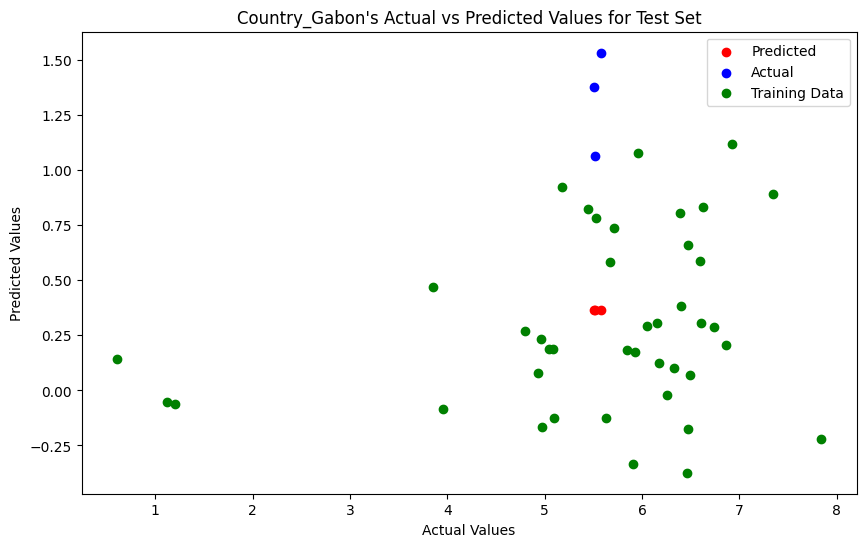

Epoch 1/50
8/8 [==============================] - 3s 76ms/step - loss: 0.3054 - mae: 0.7054 - val_loss: 0.7647 - val_mae: 1.2579
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2812 - mae: 0.6645 - val_loss: 0.8389 - val_mae: 1.3371
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2735 - mae: 0.6627 - val_loss: 0.8212 - val_mae: 1.3185
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.2788 - mae: 0.6652 - val_loss: 0.8258 - val_mae: 1.3234
Epoch 5/50
8/8 [==============================] - 0s 20ms/step - loss: 0.2753 - mae: 0.6657 - val_loss: 0.8854 - val_mae: 1.3851
Epoch 6/50
8/8 [==============================] - 0s 25ms/step - loss: 0.2806 - mae: 0.6732 - val_loss: 0.8730 - val_mae: 1.3724
Epoch 7/50
8/8 [==============================] - 0s 23ms/step - loss: 0.2995 - mae: 0.6886 - val_loss: 0.7272 - val_mae: 1.2166
Epoch 8/50
8/8 [==============================] - 0s 20ms/step - loss: 0.2860 - mae: 0.6781 - val

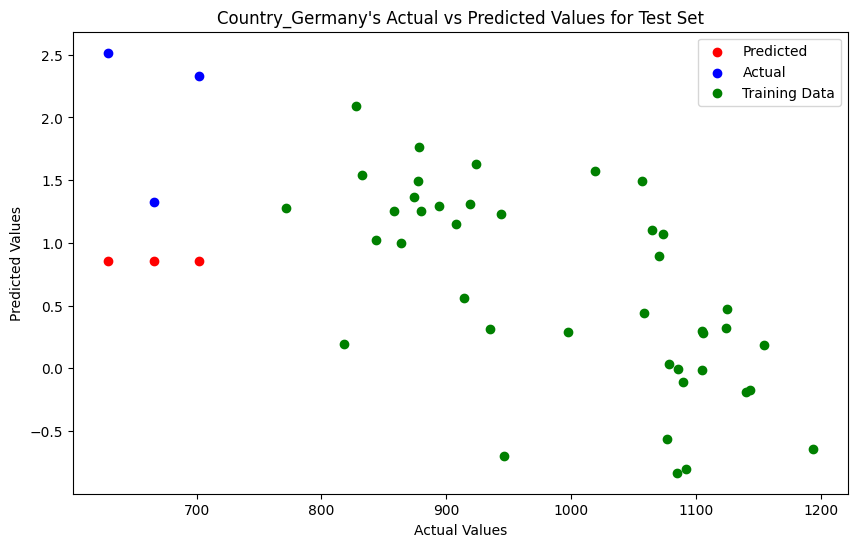

Epoch 1/50
8/8 [==============================] - 3s 85ms/step - loss: 0.0375 - mae: 0.2186 - val_loss: 0.0323 - val_mae: 0.2258
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0475 - mae: 0.2478 - val_loss: 0.0160 - val_mae: 0.1338
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0398 - mae: 0.2203 - val_loss: 0.0224 - val_mae: 0.1750
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0382 - mae: 0.2118 - val_loss: 0.0252 - val_mae: 0.1905
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0429 - mae: 0.2329 - val_loss: 0.0165 - val_mae: 0.1365
Epoch 6/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0436 - mae: 0.2284 - val_loss: 0.0259 - val_mae: 0.1938
Epoch 7/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0354 - mae: 0.2088 - val_loss: 0.0266 - val_mae: 0.1969
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0392 - mae: 0.2095 - val

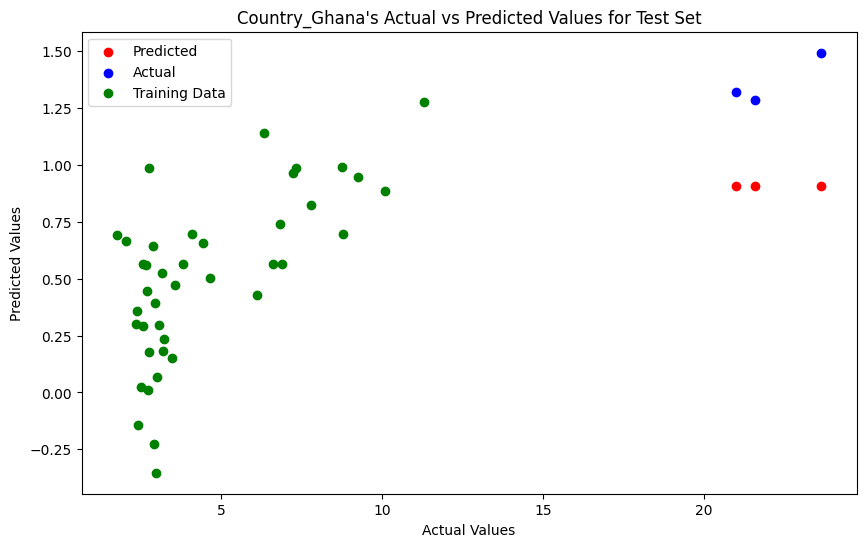

Epoch 1/50
8/8 [==============================] - 4s 76ms/step - loss: 0.0967 - mae: 0.3685 - val_loss: 0.0328 - val_mae: 0.2557
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1014 - mae: 0.3588 - val_loss: 0.1512 - val_mae: 0.5494
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1054 - mae: 0.3687 - val_loss: 0.0330 - val_mae: 0.2565
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0832 - mae: 0.3380 - val_loss: 0.0572 - val_mae: 0.3377
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0664 - mae: 0.3161 - val_loss: 0.0226 - val_mae: 0.2119
Epoch 6/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0882 - mae: 0.3531 - val_loss: 0.0543 - val_mae: 0.3292
Epoch 7/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0963 - mae: 0.3519 - val_loss: 0.0202 - val_mae: 0.2005
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0834 - mae: 0.3484 - val

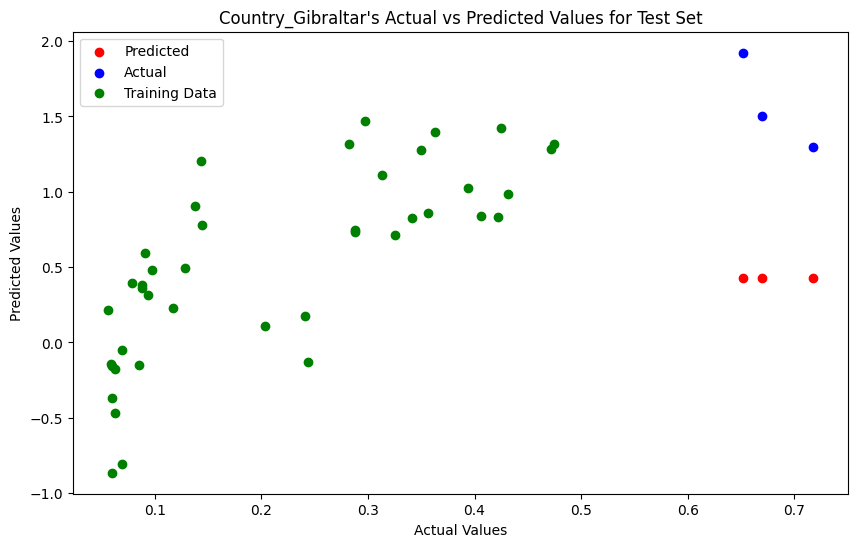

Epoch 1/50
8/8 [==============================] - 3s 76ms/step - loss: 0.1767 - mae: 0.4927 - val_loss: 0.4000 - val_mae: 0.8910
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1585 - mae: 0.4674 - val_loss: 0.3371 - val_mae: 0.8173
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1578 - mae: 0.4688 - val_loss: 0.3354 - val_mae: 0.8153
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1729 - mae: 0.4859 - val_loss: 0.3801 - val_mae: 0.8684
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.1731 - mae: 0.4740 - val_loss: 0.3871 - val_mae: 0.8764
Epoch 6/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1568 - mae: 0.4697 - val_loss: 0.2819 - val_mae: 0.7468
Epoch 7/50
8/8 [==============================] - 0s 13ms/step - loss: 0.1620 - mae: 0.4743 - val_loss: 0.3674 - val_mae: 0.8536
Epoch 8/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1687 - mae: 0.4690 - val

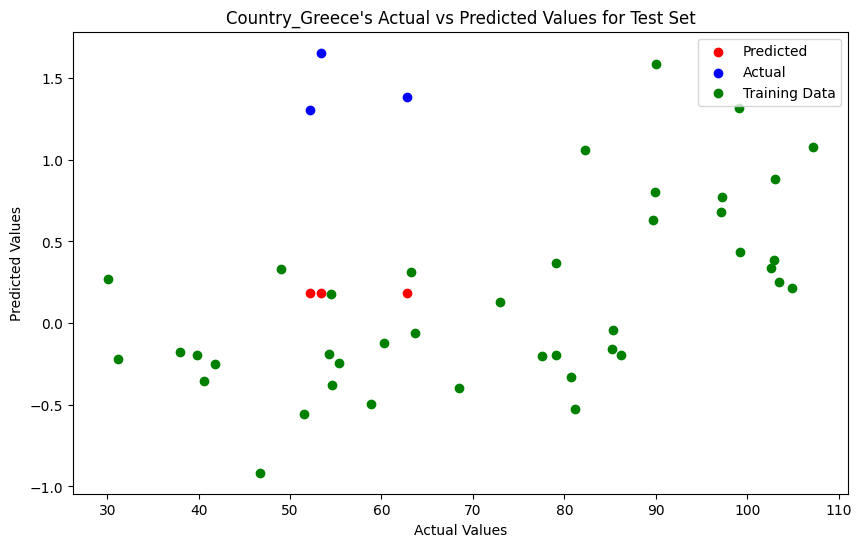

Epoch 1/50
8/8 [==============================] - 4s 96ms/step - loss: 0.5143 - mae: 0.9300 - val_loss: 0.2250 - val_mae: 0.6117
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.5061 - mae: 0.9098 - val_loss: 0.2236 - val_mae: 0.6478
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.5376 - mae: 0.9197 - val_loss: 0.5931 - val_mae: 0.9958
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.6293 - mae: 1.0663 - val_loss: 0.4057 - val_mae: 0.6647
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.5470 - mae: 0.9106 - val_loss: 0.3773 - val_mae: 0.6379
Epoch 6/50
8/8 [==============================] - 0s 14ms/step - loss: 0.5009 - mae: 0.9039 - val_loss: 0.3823 - val_mae: 0.6405
Epoch 7/50
8/8 [==============================] - 0s 18ms/step - loss: 0.4401 - mae: 0.8043 - val_loss: 0.3584 - val_mae: 0.6115
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.4727 - mae: 0.8701 - val

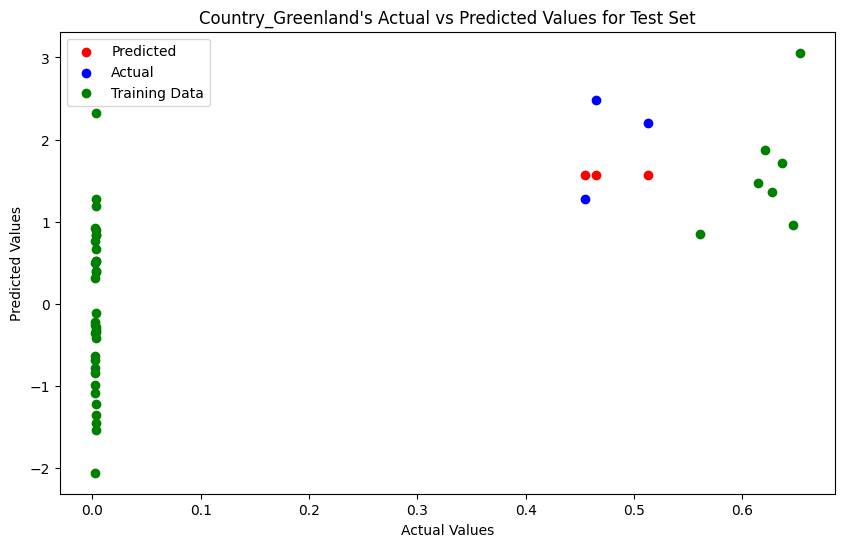

Epoch 1/50
8/8 [==============================] - 3s 72ms/step - loss: 0.1191 - mae: 0.3975 - val_loss: 0.0613 - val_mae: 0.3370
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0380 - mae: 0.2198 - val_loss: 0.0258 - val_mae: 0.2049
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0385 - mae: 0.2323 - val_loss: 0.0053 - val_mae: 0.0988
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0408 - mae: 0.2542 - val_loss: 0.0099 - val_mae: 0.1002
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0371 - mae: 0.2213 - val_loss: 0.0058 - val_mae: 0.0984
Epoch 6/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0368 - mae: 0.2294 - val_loss: 0.0065 - val_mae: 0.0979
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0375 - mae: 0.2239 - val_loss: 0.0052 - val_mae: 0.0981
Epoch 8/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0343 - mae: 0.2100 - val

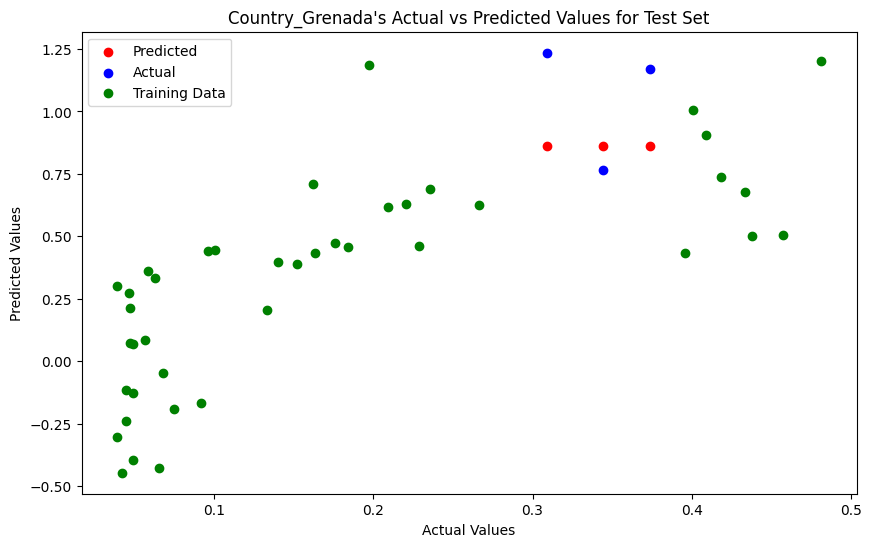

Epoch 1/50
8/8 [==============================] - 3s 74ms/step - loss: 0.0796 - mae: 0.3287 - val_loss: 0.2522 - val_mae: 0.6964
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0690 - mae: 0.3066 - val_loss: 0.0204 - val_mae: 0.1554
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0495 - mae: 0.2514 - val_loss: 0.0332 - val_mae: 0.2281
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0556 - mae: 0.2602 - val_loss: 0.0459 - val_mae: 0.2703
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0450 - mae: 0.2286 - val_loss: 0.0248 - val_mae: 0.1746
Epoch 6/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0447 - mae: 0.2348 - val_loss: 0.1020 - val_mae: 0.4254
Epoch 7/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0406 - mae: 0.2284 - val_loss: 0.0307 - val_mae: 0.1973
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0374 - mae: 0.2117 - val

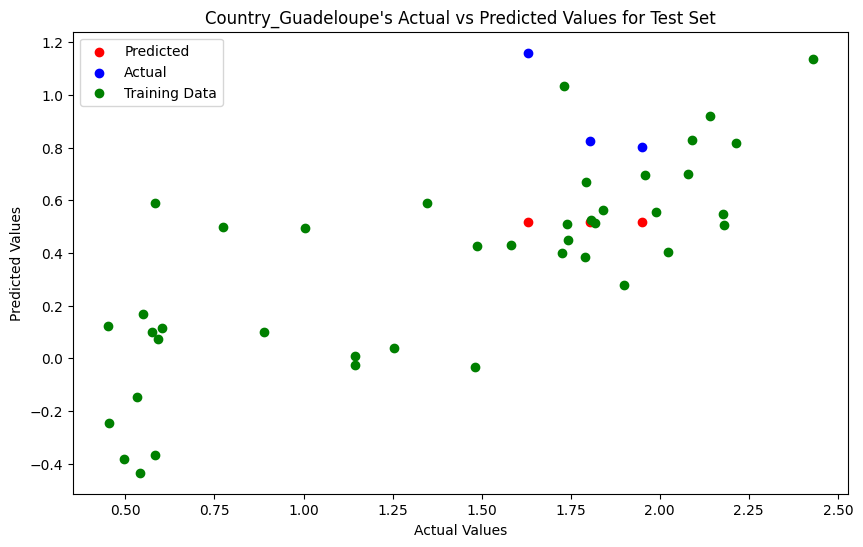

Epoch 1/50
8/8 [==============================] - 3s 111ms/step - loss: 0.0474 - mae: 0.2570 - val_loss: 0.2334 - val_mae: 0.6347
Epoch 2/50
8/8 [==============================] - 0s 27ms/step - loss: 0.0473 - mae: 0.2512 - val_loss: 0.1310 - val_mae: 0.4449
Epoch 3/50
8/8 [==============================] - 0s 26ms/step - loss: 0.0451 - mae: 0.2401 - val_loss: 0.1412 - val_mae: 0.4673
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0456 - mae: 0.2473 - val_loss: 0.1708 - val_mae: 0.5268
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0490 - mae: 0.2487 - val_loss: 0.1818 - val_mae: 0.5474
Epoch 6/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0455 - mae: 0.2469 - val_loss: 0.1481 - val_mae: 0.4818
Epoch 7/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0446 - mae: 0.2369 - val_loss: 0.1663 - val_mae: 0.5182
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0512 - mae: 0.2677 - va

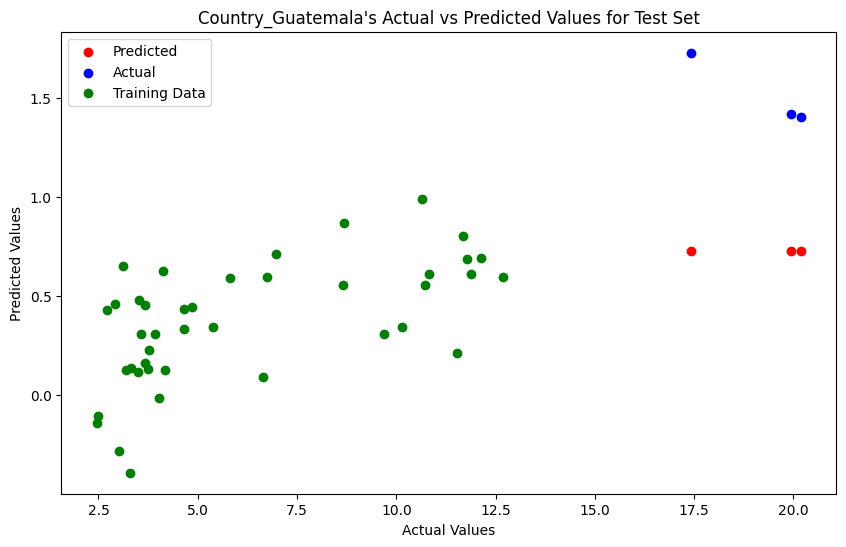

Epoch 1/50
8/8 [==============================] - 3s 73ms/step - loss: 0.1586 - mae: 0.4696 - val_loss: 0.0890 - val_mae: 0.3893
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0628 - mae: 0.2888 - val_loss: 0.0186 - val_mae: 0.1836
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0768 - mae: 0.3107 - val_loss: 0.0458 - val_mae: 0.2509
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0690 - mae: 0.3043 - val_loss: 0.0158 - val_mae: 0.1587
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0512 - mae: 0.2338 - val_loss: 0.0120 - val_mae: 0.1519
Epoch 6/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0430 - mae: 0.2257 - val_loss: 0.0234 - val_mae: 0.1560
Epoch 7/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0327 - mae: 0.2047 - val_loss: 0.0113 - val_mae: 0.1494
Epoch 8/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0328 - mae: 0.1937 - val

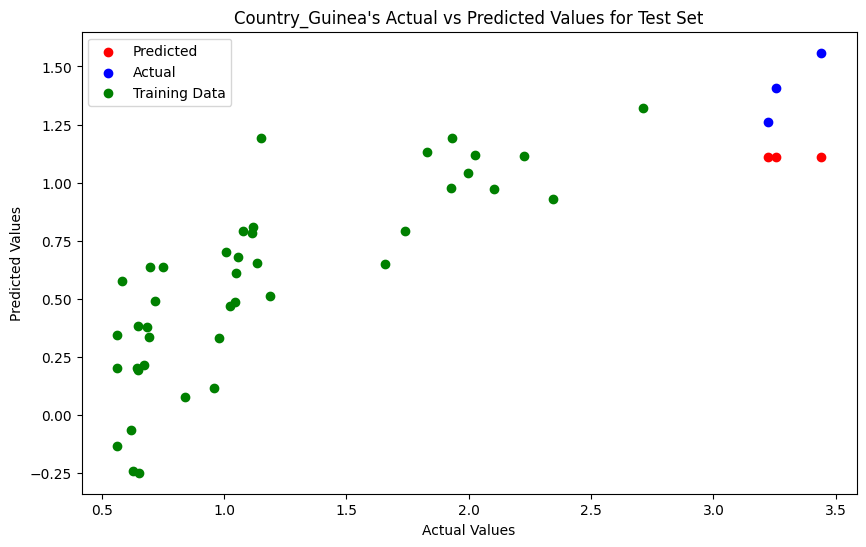

Epoch 1/50
8/8 [==============================] - 3s 73ms/step - loss: 0.1404 - mae: 0.4332 - val_loss: 0.0342 - val_mae: 0.2614
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0574 - mae: 0.2698 - val_loss: 0.0132 - val_mae: 0.1624
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0422 - mae: 0.2376 - val_loss: 0.0855 - val_mae: 0.4134
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0544 - mae: 0.2571 - val_loss: 0.0282 - val_mae: 0.2375
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0618 - mae: 0.2950 - val_loss: 0.0175 - val_mae: 0.1869
Epoch 6/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0375 - mae: 0.2018 - val_loss: 0.0024 - val_mae: 0.0678
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0435 - mae: 0.2308 - val_loss: 0.0016 - val_mae: 0.0561
Epoch 8/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0343 - mae: 0.2046 - val

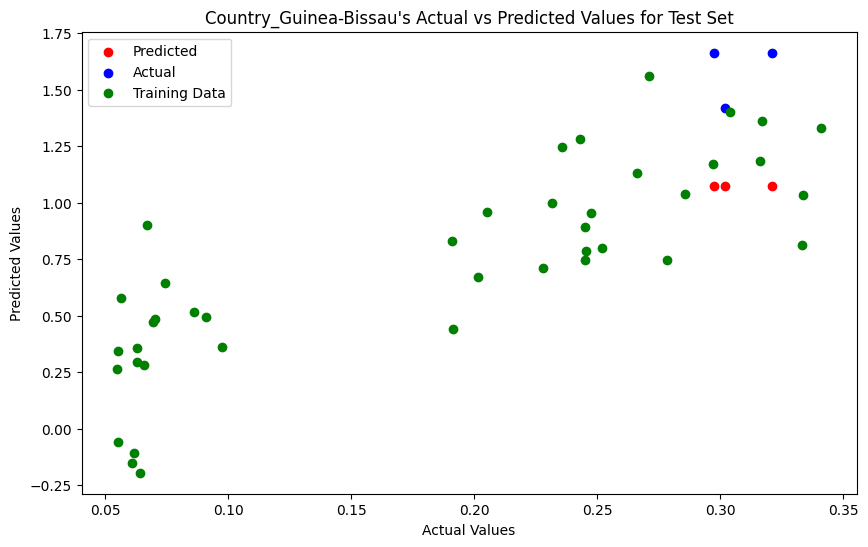

Epoch 1/50
8/8 [==============================] - 3s 115ms/step - loss: 0.1737 - mae: 0.5047 - val_loss: 0.4603 - val_mae: 0.9520
Epoch 2/50
8/8 [==============================] - 0s 21ms/step - loss: 0.1470 - mae: 0.4419 - val_loss: 0.3859 - val_mae: 0.8691
Epoch 3/50
8/8 [==============================] - 0s 28ms/step - loss: 0.1265 - mae: 0.4232 - val_loss: 0.2400 - val_mae: 0.6801
Epoch 4/50
8/8 [==============================] - 0s 26ms/step - loss: 0.1684 - mae: 0.5042 - val_loss: 0.4821 - val_mae: 0.9757
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 0.1444 - mae: 0.4555 - val_loss: 0.3507 - val_mae: 0.8241
Epoch 6/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1214 - mae: 0.4158 - val_loss: 0.3660 - val_mae: 0.8415
Epoch 7/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1285 - mae: 0.4030 - val_loss: 0.4370 - val_mae: 0.9185
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1813 - mae: 0.5045 - va

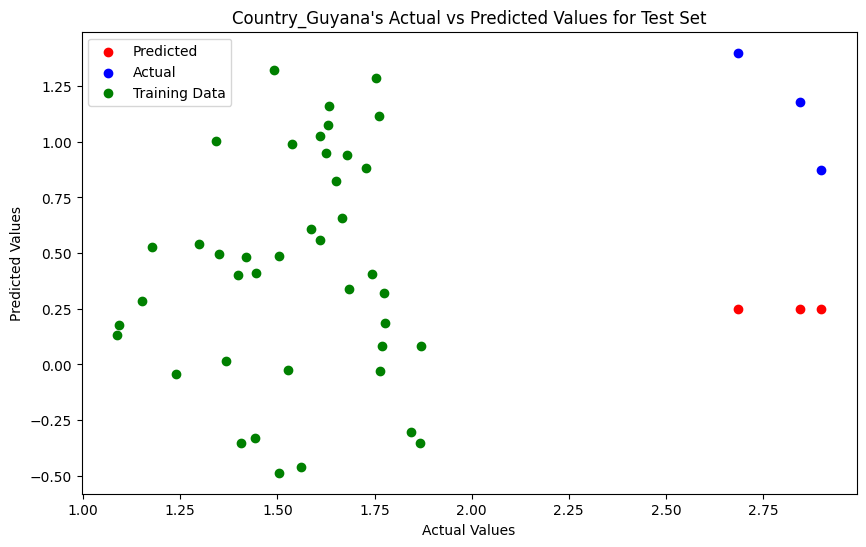

Epoch 1/50
8/8 [==============================] - 3s 75ms/step - loss: 0.1170 - mae: 0.3905 - val_loss: 0.1640 - val_mae: 0.5706
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0523 - mae: 0.2438 - val_loss: 0.1065 - val_mae: 0.4583
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0434 - mae: 0.2361 - val_loss: 0.0955 - val_mae: 0.4345
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0499 - mae: 0.2553 - val_loss: 0.0563 - val_mae: 0.3325
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0665 - mae: 0.3042 - val_loss: 0.2777 - val_mae: 0.7443
Epoch 6/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0582 - mae: 0.2941 - val_loss: 0.0959 - val_mae: 0.4359
Epoch 7/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0373 - mae: 0.2217 - val_loss: 0.1540 - val_mae: 0.5536
Epoch 8/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0319 - mae: 0.2046 - val

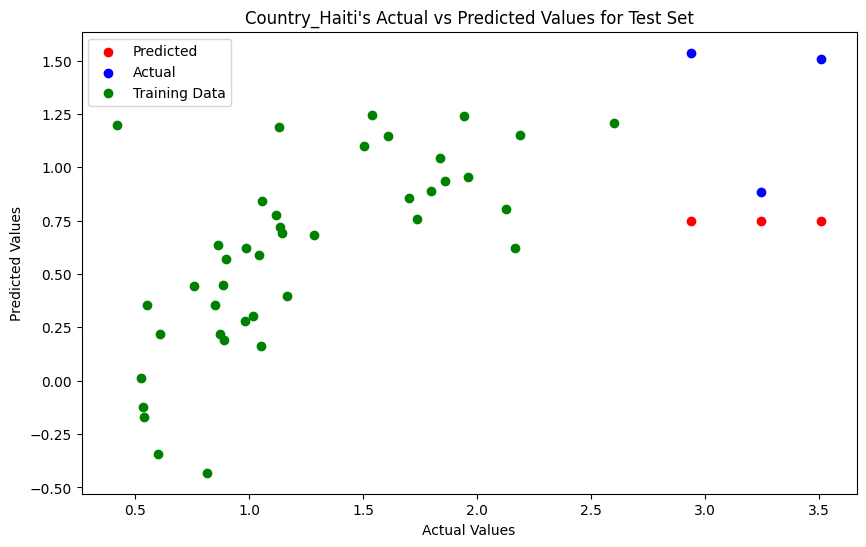

Epoch 1/50
8/8 [==============================] - 3s 78ms/step - loss: 0.0848 - mae: 0.3514 - val_loss: 0.1736 - val_mae: 0.5425
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0524 - mae: 0.2536 - val_loss: 0.0417 - val_mae: 0.2300
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0473 - mae: 0.2627 - val_loss: 0.0467 - val_mae: 0.2300
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0464 - mae: 0.2435 - val_loss: 0.0687 - val_mae: 0.2907
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0316 - mae: 0.2157 - val_loss: 0.0600 - val_mae: 0.2589
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0311 - mae: 0.2097 - val_loss: 0.0591 - val_mae: 0.2556
Epoch 7/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0311 - mae: 0.2082 - val_loss: 0.0638 - val_mae: 0.2733
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0342 - mae: 0.2193 - val

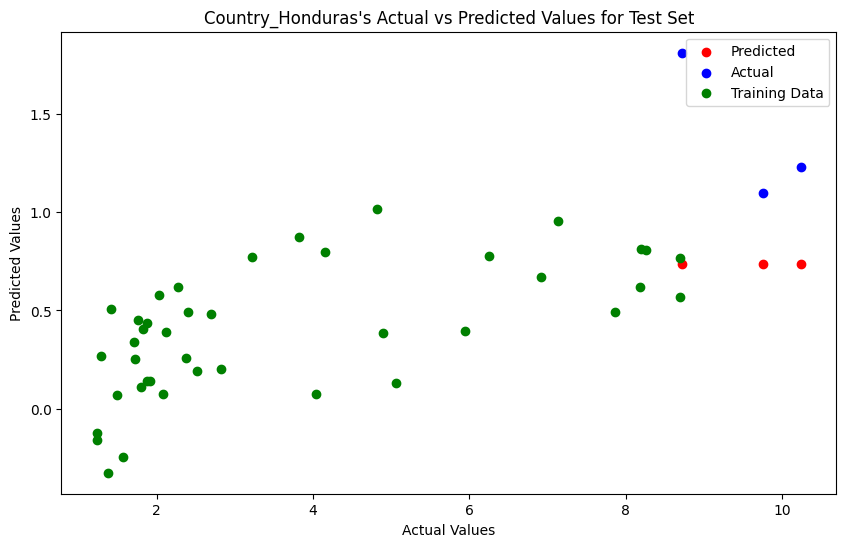

Epoch 1/50
8/8 [==============================] - 3s 116ms/step - loss: 0.2773 - mae: 0.6244 - val_loss: 1.1751 - val_mae: 1.6751
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2763 - mae: 0.6220 - val_loss: 1.2391 - val_mae: 1.7391
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2658 - mae: 0.6063 - val_loss: 1.0757 - val_mae: 1.5757
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.3011 - mae: 0.6434 - val_loss: 0.9936 - val_mae: 1.4936
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2758 - mae: 0.6166 - val_loss: 1.2575 - val_mae: 1.7575
Epoch 6/50
8/8 [==============================] - 0s 13ms/step - loss: 0.2783 - mae: 0.6276 - val_loss: 1.1353 - val_mae: 1.6353
Epoch 7/50
8/8 [==============================] - 0s 19ms/step - loss: 0.3035 - mae: 0.6618 - val_loss: 1.0811 - val_mae: 1.5811
Epoch 8/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2876 - mae: 0.6471 - va

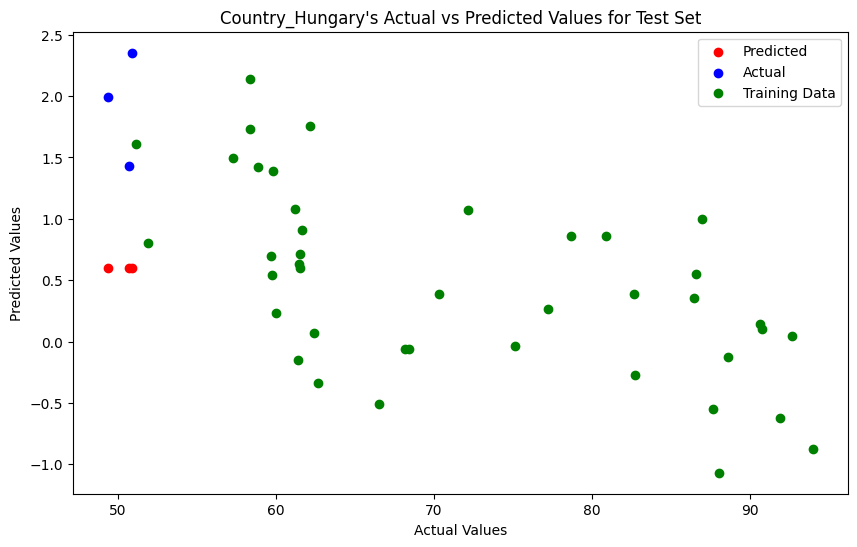

Epoch 1/50
8/8 [==============================] - 3s 72ms/step - loss: 0.1871 - mae: 0.4754 - val_loss: 0.3963 - val_mae: 0.6706
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1245 - mae: 0.3938 - val_loss: 0.2091 - val_mae: 0.6208
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1045 - mae: 0.3764 - val_loss: 0.2297 - val_mae: 0.6170
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.2250 - mae: 0.5455 - val_loss: 0.1970 - val_mae: 0.6206
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1440 - mae: 0.4111 - val_loss: 0.4852 - val_mae: 0.8349
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1874 - mae: 0.4928 - val_loss: 0.3544 - val_mae: 0.6235
Epoch 7/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1839 - mae: 0.4866 - val_loss: 0.2468 - val_mae: 0.6175
Epoch 8/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1328 - mae: 0.3895 - val

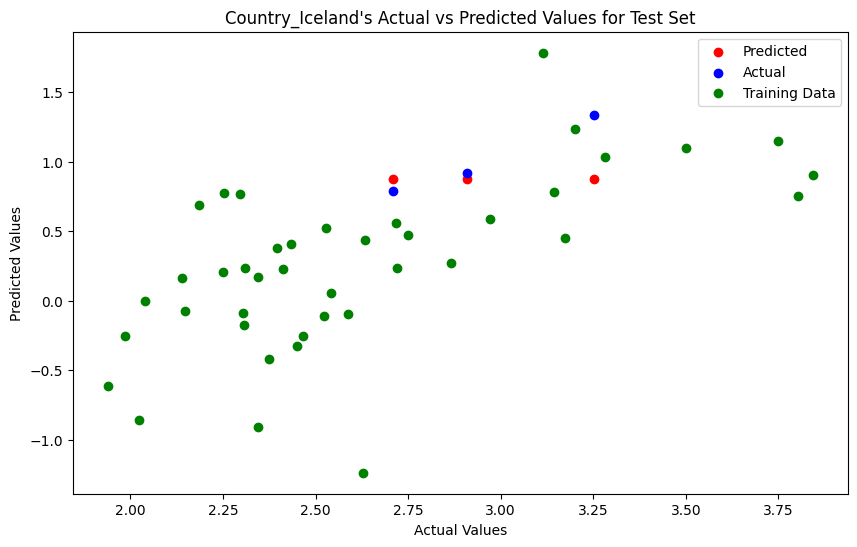

Epoch 1/50
8/8 [==============================] - 3s 74ms/step - loss: 0.1063 - mae: 0.3634 - val_loss: 0.1387 - val_mae: 0.5189
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0598 - mae: 0.2738 - val_loss: 0.0433 - val_mae: 0.2801
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0597 - mae: 0.2844 - val_loss: 0.0316 - val_mae: 0.2344
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0563 - mae: 0.2746 - val_loss: 0.0733 - val_mae: 0.3722
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0594 - mae: 0.2715 - val_loss: 0.0742 - val_mae: 0.3744
Epoch 6/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0566 - mae: 0.2705 - val_loss: 0.0410 - val_mae: 0.2715
Epoch 7/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0571 - mae: 0.2740 - val_loss: 0.0578 - val_mae: 0.3277
Epoch 8/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0585 - mae: 0.2734 - val

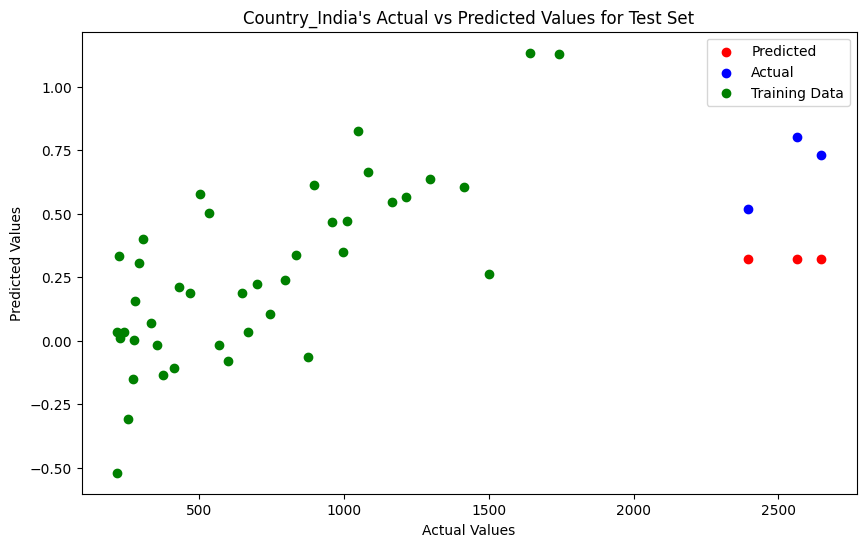

Epoch 1/50
8/8 [==============================] - 3s 73ms/step - loss: 0.0311 - mae: 0.1970 - val_loss: 0.1231 - val_mae: 0.4960
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0316 - mae: 0.1955 - val_loss: 0.1363 - val_mae: 0.5220
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0307 - mae: 0.1936 - val_loss: 0.1126 - val_mae: 0.4744
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0320 - mae: 0.2013 - val_loss: 0.1115 - val_mae: 0.4719
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0305 - mae: 0.1916 - val_loss: 0.1436 - val_mae: 0.5357
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0315 - mae: 0.1949 - val_loss: 0.1307 - val_mae: 0.5111
Epoch 7/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0325 - mae: 0.2002 - val_loss: 0.1178 - val_mae: 0.4852
Epoch 8/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0325 - mae: 0.1959 - val

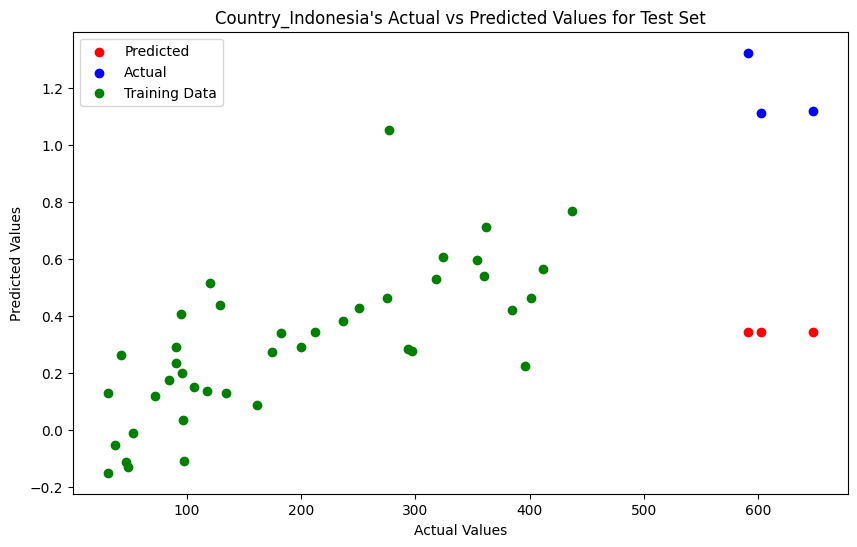

Epoch 1/50
8/8 [==============================] - 5s 345ms/step - loss: 0.2843 - mae: 0.6212 - val_loss: 0.6087 - val_mae: 1.0868
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2810 - mae: 0.6283 - val_loss: 0.5821 - val_mae: 1.0554
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2803 - mae: 0.6288 - val_loss: 0.5868 - val_mae: 1.0609
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2865 - mae: 0.6455 - val_loss: 0.5569 - val_mae: 1.0250
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2785 - mae: 0.6124 - val_loss: 0.7212 - val_mae: 1.2141
Epoch 6/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2892 - mae: 0.6224 - val_loss: 0.6676 - val_mae: 1.1546
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2948 - mae: 0.6521 - val_loss: 0.4967 - val_mae: 0.9499
Epoch 8/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2856 - mae: 0.6397 - va

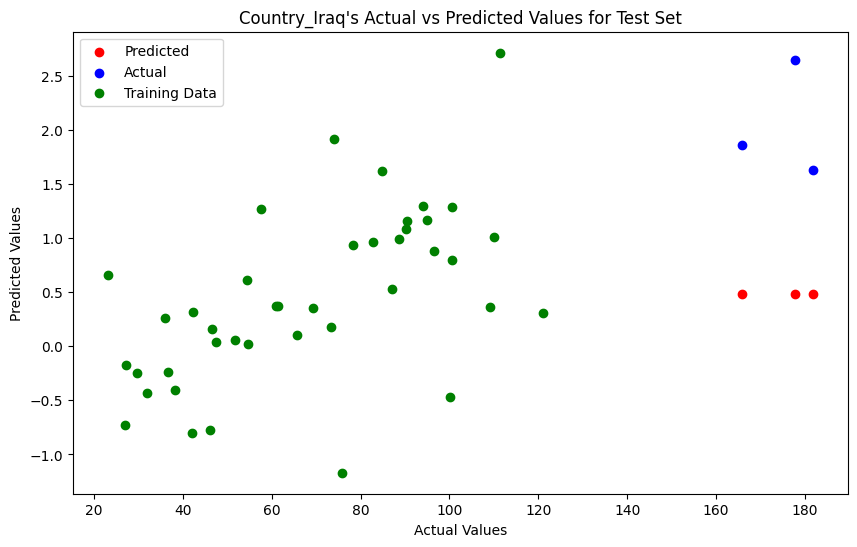

Epoch 1/50
8/8 [==============================] - 3s 114ms/step - loss: 0.1444 - mae: 0.4510 - val_loss: 0.2070 - val_mae: 0.4558
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1440 - mae: 0.4495 - val_loss: 0.2093 - val_mae: 0.4609
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1444 - mae: 0.4525 - val_loss: 0.1758 - val_mae: 0.4540
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1449 - mae: 0.4494 - val_loss: 0.2161 - val_mae: 0.4755
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1442 - mae: 0.4522 - val_loss: 0.1919 - val_mae: 0.4540
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1448 - mae: 0.4512 - val_loss: 0.2101 - val_mae: 0.4628
Epoch 7/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1485 - mae: 0.4579 - val_loss: 0.1861 - val_mae: 0.4540
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1473 - mae: 0.4545 - va

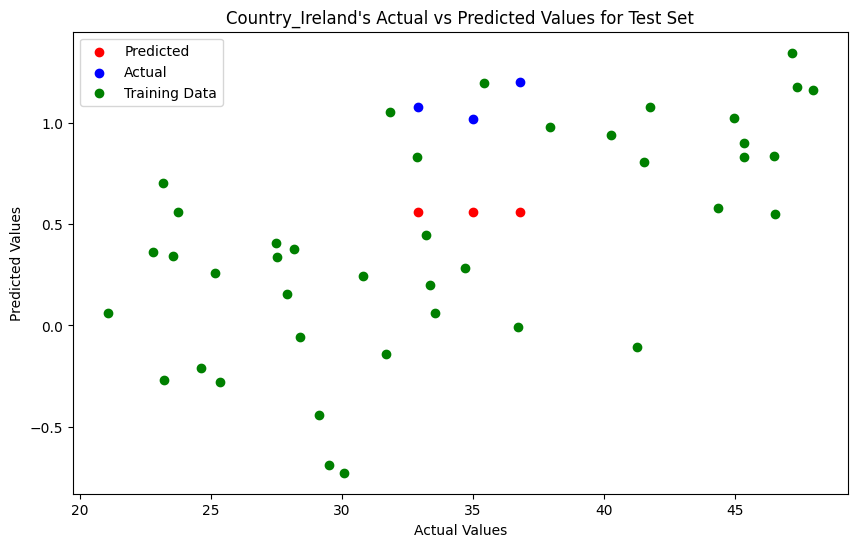

Epoch 1/50
8/8 [==============================] - 3s 73ms/step - loss: 0.0796 - mae: 0.3282 - val_loss: 0.2076 - val_mae: 0.6374
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0772 - mae: 0.3313 - val_loss: 0.2303 - val_mae: 0.6721
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0771 - mae: 0.3255 - val_loss: 0.2143 - val_mae: 0.6478
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0764 - mae: 0.3269 - val_loss: 0.2126 - val_mae: 0.6452
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0760 - mae: 0.3247 - val_loss: 0.2308 - val_mae: 0.6729
Epoch 6/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0756 - mae: 0.3228 - val_loss: 0.2283 - val_mae: 0.6691
Epoch 7/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0775 - mae: 0.3279 - val_loss: 0.2067 - val_mae: 0.6359
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0769 - mae: 0.3259 - val

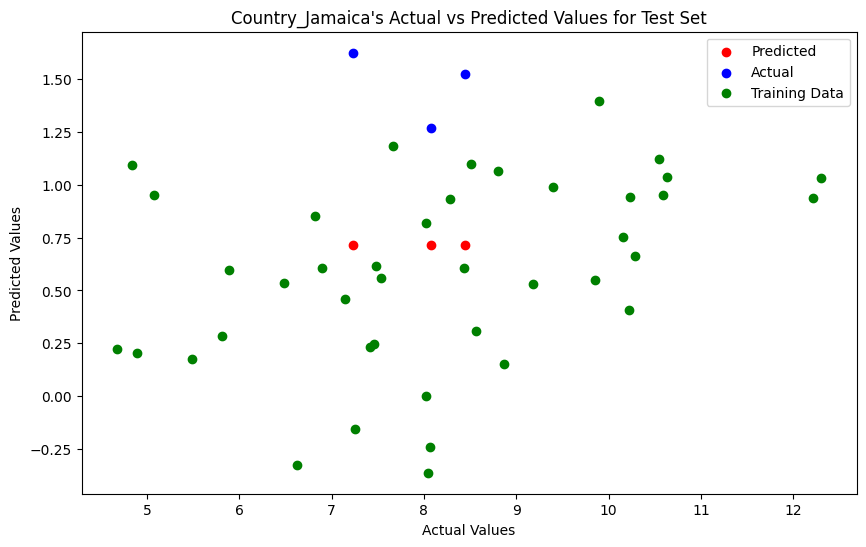

Epoch 1/50
8/8 [==============================] - 3s 72ms/step - loss: 0.1684 - mae: 0.4799 - val_loss: 0.0789 - val_mae: 0.3730
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1486 - mae: 0.4609 - val_loss: 0.1515 - val_mae: 0.5332
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1357 - mae: 0.4255 - val_loss: 0.0502 - val_mae: 0.2861
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1403 - mae: 0.4275 - val_loss: 0.0536 - val_mae: 0.2977
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1323 - mae: 0.4236 - val_loss: 0.1053 - val_mae: 0.4381
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1362 - mae: 0.4346 - val_loss: 0.0967 - val_mae: 0.4181
Epoch 7/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1430 - mae: 0.4334 - val_loss: 0.0544 - val_mae: 0.3003
Epoch 8/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1518 - mae: 0.4523 - val

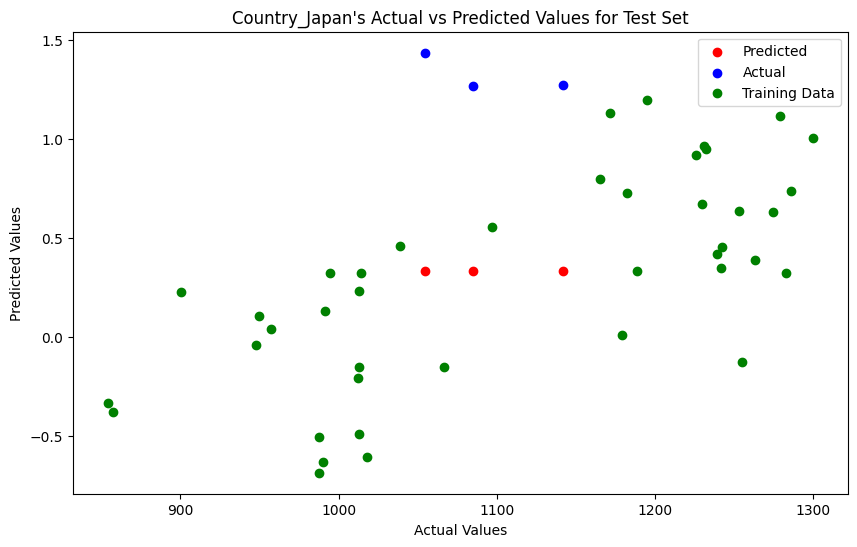

Epoch 1/50
8/8 [==============================] - 3s 118ms/step - loss: 0.2341 - mae: 0.5734 - val_loss: 0.4988 - val_mae: 0.9675
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2106 - mae: 0.5227 - val_loss: 0.5612 - val_mae: 1.0417
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2057 - mae: 0.5271 - val_loss: 0.3885 - val_mae: 0.8277
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2153 - mae: 0.5494 - val_loss: 0.4958 - val_mae: 0.9640
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.2137 - mae: 0.5006 - val_loss: 0.6076 - val_mae: 1.0948
Epoch 6/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1969 - mae: 0.5024 - val_loss: 0.3775 - val_mae: 0.8129
Epoch 7/50
8/8 [==============================] - 0s 14ms/step - loss: 0.2042 - mae: 0.5215 - val_loss: 0.3873 - val_mae: 0.8260
Epoch 8/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1761 - mae: 0.4465 - va

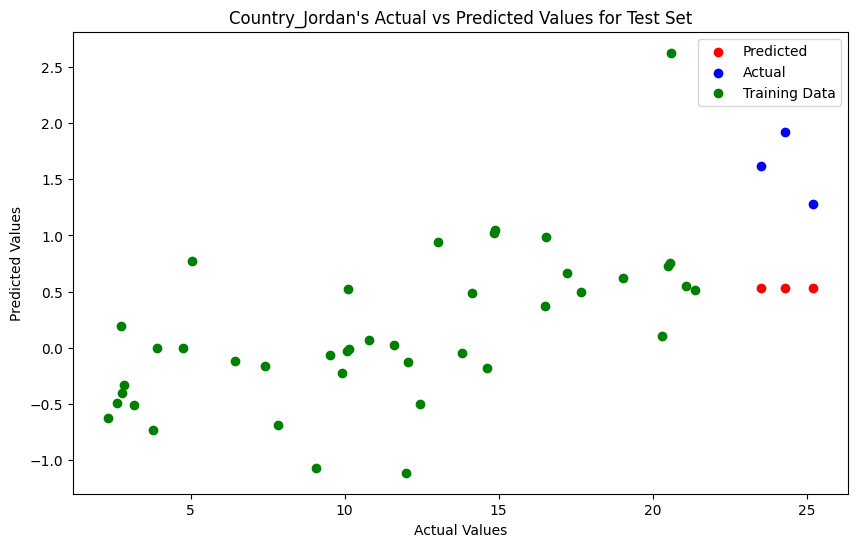

Epoch 1/50
8/8 [==============================] - 3s 76ms/step - loss: 0.1487 - mae: 0.4668 - val_loss: 0.0410 - val_mae: 0.2807
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0924 - mae: 0.3523 - val_loss: 0.2813 - val_mae: 0.7466
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0554 - mae: 0.2715 - val_loss: 0.1137 - val_mae: 0.4713
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0596 - mae: 0.2837 - val_loss: 0.2601 - val_mae: 0.7178
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0544 - mae: 0.2787 - val_loss: 0.1327 - val_mae: 0.5104
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0450 - mae: 0.2576 - val_loss: 0.0880 - val_mae: 0.4135
Epoch 7/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0413 - mae: 0.2393 - val_loss: 0.0727 - val_mae: 0.3747
Epoch 8/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0527 - mae: 0.2710 - val

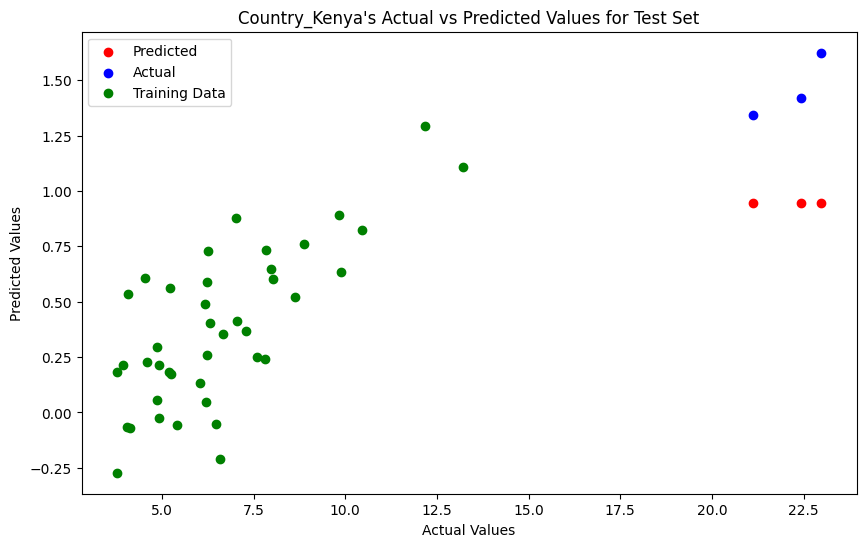

Epoch 1/50
8/8 [==============================] - 3s 76ms/step - loss: 0.1450 - mae: 0.4348 - val_loss: 0.0789 - val_mae: 0.3911
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0787 - mae: 0.2925 - val_loss: 0.1499 - val_mae: 0.5440
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0540 - mae: 0.2247 - val_loss: 0.1504 - val_mae: 0.5437
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0591 - mae: 0.2524 - val_loss: 0.0285 - val_mae: 0.2278
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0464 - mae: 0.2233 - val_loss: 0.2069 - val_mae: 0.6392
Epoch 6/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0635 - mae: 0.2658 - val_loss: 0.0764 - val_mae: 0.3853
Epoch 7/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0471 - mae: 0.2326 - val_loss: 0.1900 - val_mae: 0.6125
Epoch 8/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0571 - mae: 0.2470 - val

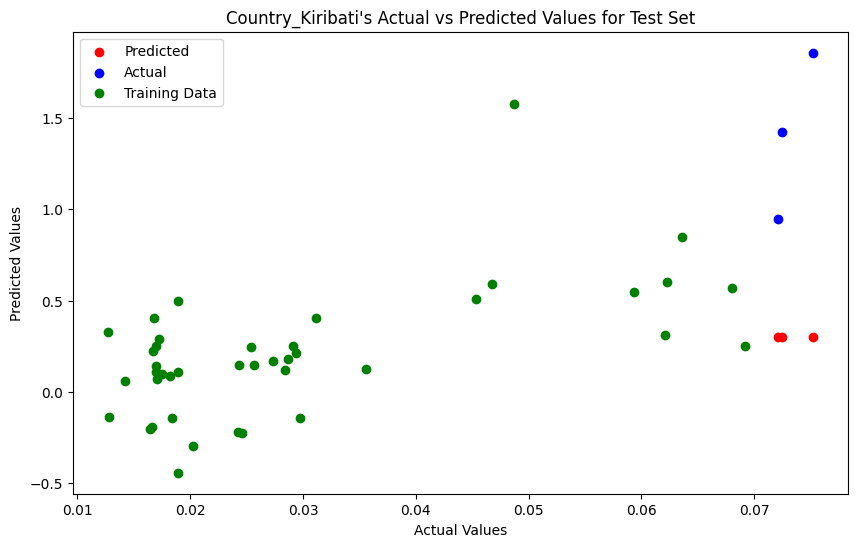

Epoch 1/50
8/8 [==============================] - 3s 74ms/step - loss: 0.3149 - mae: 0.6747 - val_loss: 0.5019 - val_mae: 0.9701
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.3144 - mae: 0.6866 - val_loss: 0.7524 - val_mae: 1.2509
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2895 - mae: 0.6445 - val_loss: 0.5922 - val_mae: 1.0766
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.3078 - mae: 0.6933 - val_loss: 0.5608 - val_mae: 1.0403
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.2895 - mae: 0.6453 - val_loss: 0.8279 - val_mae: 1.3279
Epoch 6/50
8/8 [==============================] - 0s 16ms/step - loss: 0.3052 - mae: 0.6512 - val_loss: 0.7048 - val_mae: 1.2009
Epoch 7/50
8/8 [==============================] - 0s 18ms/step - loss: 0.3226 - mae: 0.6994 - val_loss: 0.5362 - val_mae: 1.0114
Epoch 8/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2963 - mae: 0.6576 - val

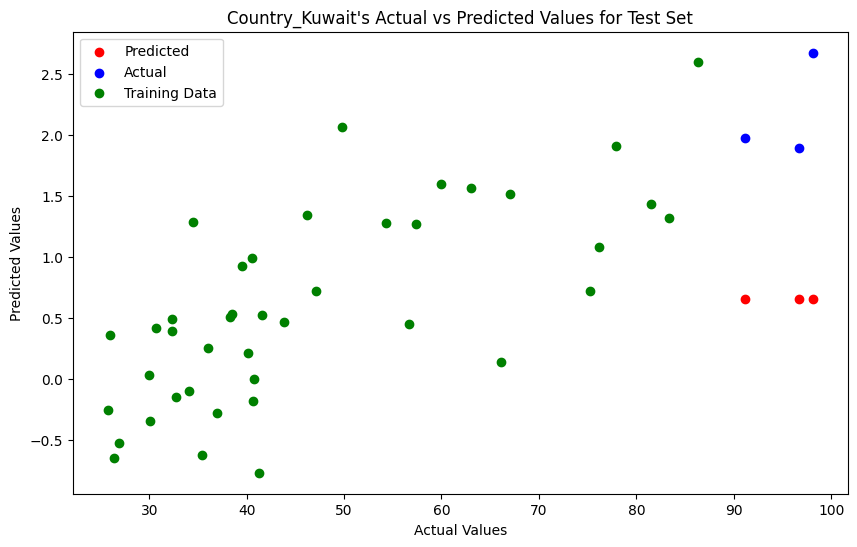

Epoch 1/50
8/8 [==============================] - 3s 76ms/step - loss: 0.2371 - mae: 0.5765 - val_loss: 0.4797 - val_mae: 0.9701
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1902 - mae: 0.4967 - val_loss: 0.5160 - val_mae: 1.0099
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1321 - mae: 0.3879 - val_loss: 0.0468 - val_mae: 0.2572
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1324 - mae: 0.4185 - val_loss: 0.2624 - val_mae: 0.7053
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1467 - mae: 0.4147 - val_loss: 0.0915 - val_mae: 0.3944
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1449 - mae: 0.4383 - val_loss: 0.2073 - val_mae: 0.6223
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1349 - mae: 0.3870 - val_loss: 0.2653 - val_mae: 0.7093
Epoch 8/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1114 - mae: 0.3665 - val

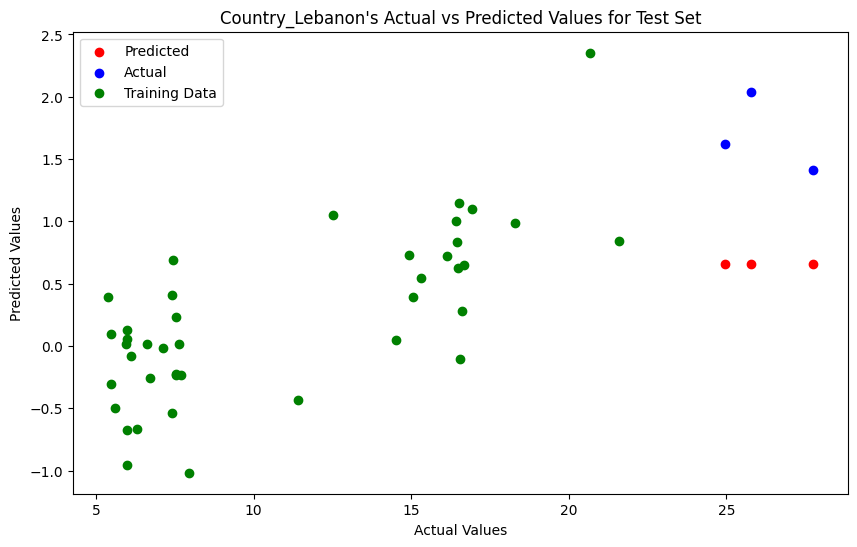

Epoch 1/50
8/8 [==============================] - 3s 77ms/step - loss: 0.1517 - mae: 0.4806 - val_loss: 0.1517 - val_mae: 0.4541
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0671 - mae: 0.2985 - val_loss: 0.2715 - val_mae: 0.7092
Epoch 3/50
8/8 [==============================] - 0s 29ms/step - loss: 0.0531 - mae: 0.2592 - val_loss: 0.1687 - val_mae: 0.5323
Epoch 4/50
8/8 [==============================] - 0s 25ms/step - loss: 0.0476 - mae: 0.2227 - val_loss: 0.3172 - val_mae: 0.7527
Epoch 5/50
8/8 [==============================] - 0s 28ms/step - loss: 0.0427 - mae: 0.2395 - val_loss: 0.1673 - val_mae: 0.5232
Epoch 6/50
8/8 [==============================] - 0s 32ms/step - loss: 0.0532 - mae: 0.2637 - val_loss: 0.1524 - val_mae: 0.5001
Epoch 7/50
8/8 [==============================] - 0s 29ms/step - loss: 0.0516 - mae: 0.2480 - val_loss: 0.3272 - val_mae: 0.7735
Epoch 8/50
8/8 [==============================] - 0s 33ms/step - loss: 0.0496 - mae: 0.2433 - val

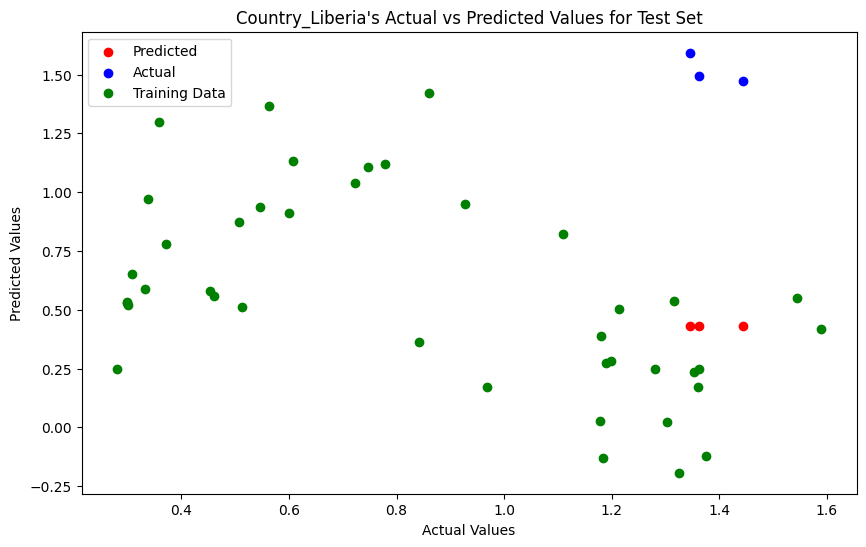

Epoch 1/50
8/8 [==============================] - 3s 75ms/step - loss: 0.1467 - mae: 0.4467 - val_loss: 0.2457 - val_mae: 0.6498
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1600 - mae: 0.4567 - val_loss: 0.2082 - val_mae: 0.5893
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1565 - mae: 0.4596 - val_loss: 0.2491 - val_mae: 0.6551
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1486 - mae: 0.4455 - val_loss: 0.2841 - val_mae: 0.7065
Epoch 5/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1533 - mae: 0.4479 - val_loss: 0.2181 - val_mae: 0.6059
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1453 - mae: 0.4421 - val_loss: 0.1934 - val_mae: 0.5637
Epoch 7/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1546 - mae: 0.4597 - val_loss: 0.2387 - val_mae: 0.6385
Epoch 8/50
8/8 [==============================] - 0s 21ms/step - loss: 0.1654 - mae: 0.4517 - val

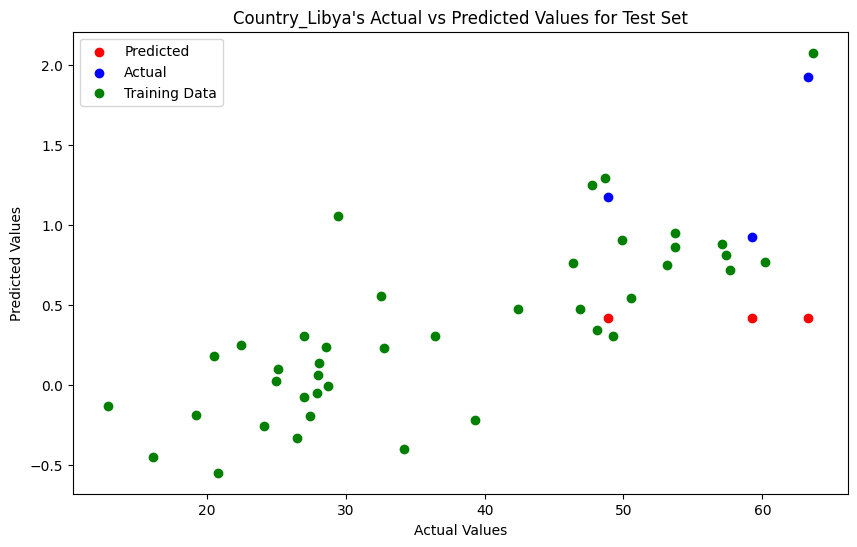

Epoch 1/50
8/8 [==============================] - 3s 77ms/step - loss: 0.0715 - mae: 0.3247 - val_loss: 0.0663 - val_mae: 0.3642
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0683 - mae: 0.2951 - val_loss: 0.0773 - val_mae: 0.3932
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0555 - mae: 0.2739 - val_loss: 0.0662 - val_mae: 0.3638
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0650 - mae: 0.3097 - val_loss: 0.1027 - val_mae: 0.4532
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0711 - mae: 0.2938 - val_loss: 0.0210 - val_mae: 0.2047
Epoch 6/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0673 - mae: 0.3081 - val_loss: 0.1571 - val_mae: 0.5604
Epoch 7/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0600 - mae: 0.2944 - val_loss: 0.0840 - val_mae: 0.4099
Epoch 8/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0623 - mae: 0.2905 - val

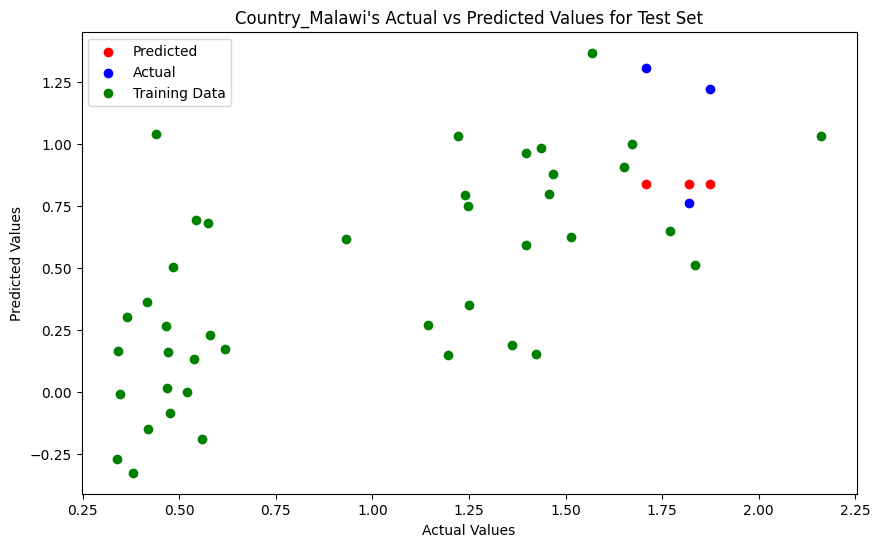

Epoch 1/50
8/8 [==============================] - 3s 76ms/step - loss: 0.0712 - mae: 0.3172 - val_loss: 0.5092 - val_mae: 1.0076
Epoch 2/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0637 - mae: 0.2839 - val_loss: 0.3263 - val_mae: 0.8031
Epoch 3/50
8/8 [==============================] - 0s 30ms/step - loss: 0.0539 - mae: 0.2622 - val_loss: 0.2640 - val_mae: 0.7214
Epoch 4/50
8/8 [==============================] - 0s 31ms/step - loss: 0.0544 - mae: 0.2602 - val_loss: 0.3698 - val_mae: 0.8556
Epoch 5/50
8/8 [==============================] - 0s 26ms/step - loss: 0.0543 - mae: 0.2604 - val_loss: 0.3559 - val_mae: 0.8392
Epoch 6/50
8/8 [==============================] - 0s 25ms/step - loss: 0.0535 - mae: 0.2585 - val_loss: 0.3209 - val_mae: 0.7965
Epoch 7/50
8/8 [==============================] - 0s 28ms/step - loss: 0.0549 - mae: 0.2628 - val_loss: 0.3338 - val_mae: 0.8124
Epoch 8/50
8/8 [==============================] - 0s 32ms/step - loss: 0.0576 - mae: 0.2696 - val

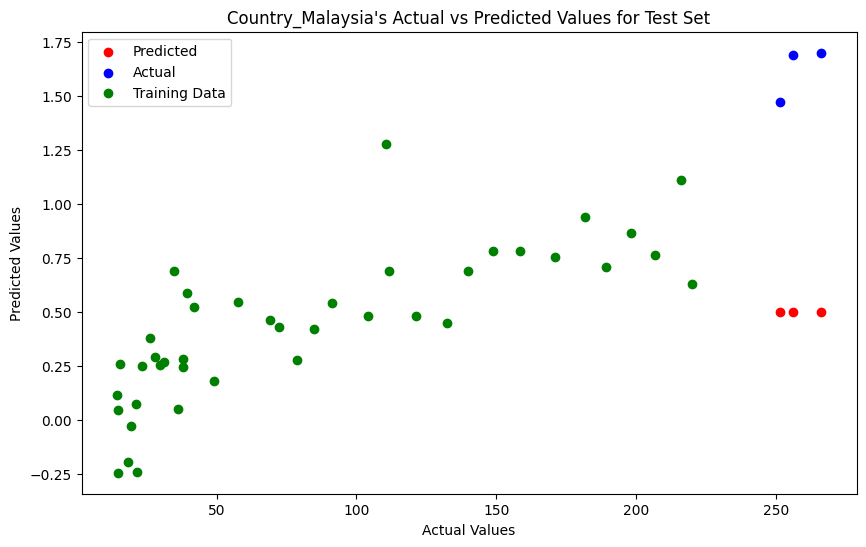

Epoch 1/50
8/8 [==============================] - 3s 75ms/step - loss: 0.0357 - mae: 0.2145 - val_loss: 0.1087 - val_mae: 0.4547
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0343 - mae: 0.2089 - val_loss: 0.1372 - val_mae: 0.5134
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0265 - mae: 0.1852 - val_loss: 0.1266 - val_mae: 0.4910
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0262 - mae: 0.1833 - val_loss: 0.1303 - val_mae: 0.4986
Epoch 5/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0266 - mae: 0.1837 - val_loss: 0.1263 - val_mae: 0.4876
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0261 - mae: 0.1781 - val_loss: 0.1243 - val_mae: 0.4862
Epoch 7/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0263 - mae: 0.1817 - val_loss: 0.1143 - val_mae: 0.4634
Epoch 8/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0274 - mae: 0.1860 - val

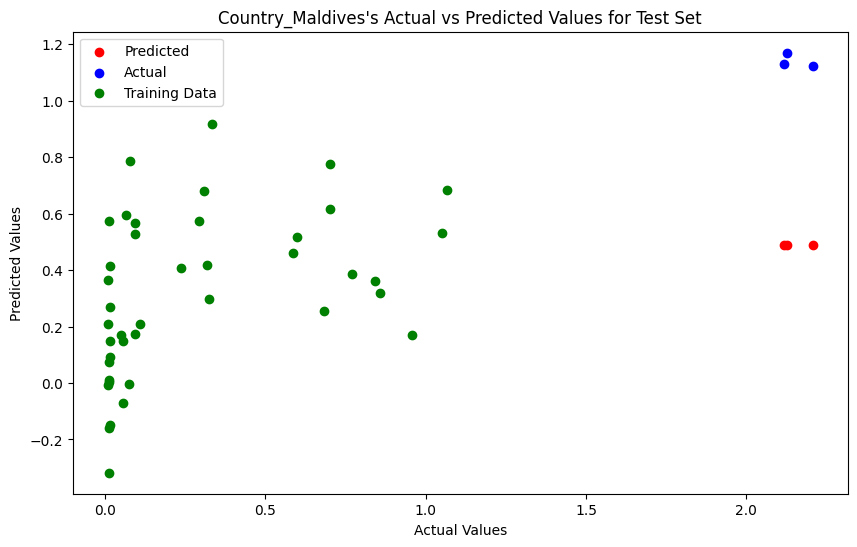

Epoch 1/50
8/8 [==============================] - 3s 74ms/step - loss: 0.1059 - mae: 0.3768 - val_loss: 0.0542 - val_mae: 0.2663
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1038 - mae: 0.3755 - val_loss: 0.0231 - val_mae: 0.1598
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0688 - mae: 0.3159 - val_loss: 0.0159 - val_mae: 0.1392
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0765 - mae: 0.3158 - val_loss: 0.0587 - val_mae: 0.3248
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0680 - mae: 0.3042 - val_loss: 0.0189 - val_mae: 0.1700
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0705 - mae: 0.3169 - val_loss: 0.0187 - val_mae: 0.1551
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0606 - mae: 0.3007 - val_loss: 0.0188 - val_mae: 0.1480
Epoch 8/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0638 - mae: 0.3011 - val

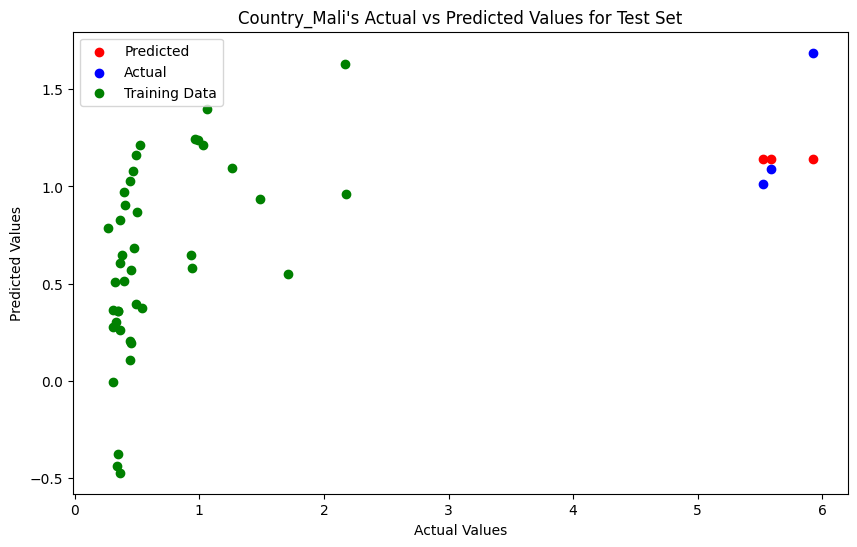

Epoch 1/50
8/8 [==============================] - 3s 72ms/step - loss: 0.2035 - mae: 0.5400 - val_loss: 0.4838 - val_mae: 0.9818
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1173 - mae: 0.4068 - val_loss: 0.1181 - val_mae: 0.4830
Epoch 3/50
8/8 [==============================] - 0s 28ms/step - loss: 0.0930 - mae: 0.3662 - val_loss: 0.0518 - val_mae: 0.3172
Epoch 4/50
8/8 [==============================] - 0s 27ms/step - loss: 0.1052 - mae: 0.3682 - val_loss: 0.6323 - val_mae: 1.1323
Epoch 5/50
8/8 [==============================] - 0s 27ms/step - loss: 0.2056 - mae: 0.5387 - val_loss: 0.0269 - val_mae: 0.2203
Epoch 6/50
8/8 [==============================] - 0s 23ms/step - loss: 0.1909 - mae: 0.5002 - val_loss: 0.1855 - val_mae: 0.6064
Epoch 7/50
8/8 [==============================] - 0s 30ms/step - loss: 0.1322 - mae: 0.4163 - val_loss: 0.0149 - val_mae: 0.1633
Epoch 8/50
8/8 [==============================] - 0s 28ms/step - loss: 0.1007 - mae: 0.3500 - val

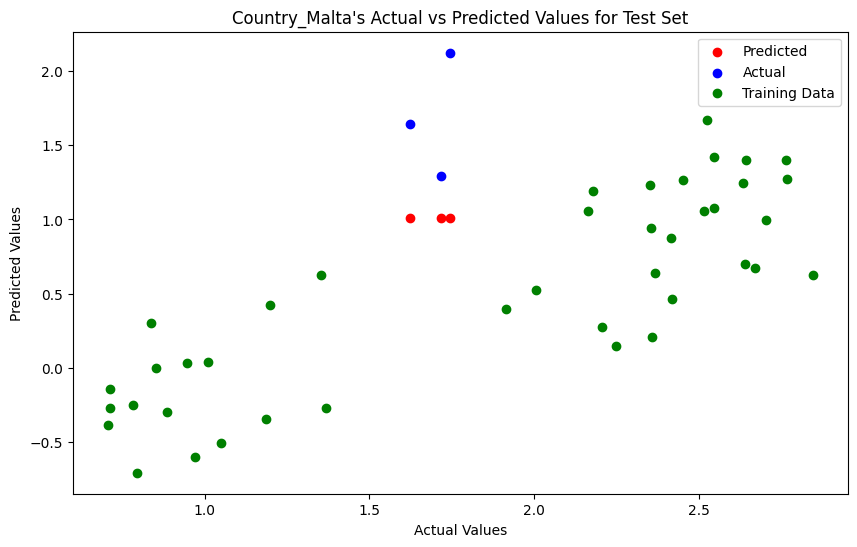

Epoch 1/50
8/8 [==============================] - 3s 73ms/step - loss: 0.0692 - mae: 0.3082 - val_loss: 0.0481 - val_mae: 0.2932
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0417 - mae: 0.2224 - val_loss: 0.0165 - val_mae: 0.1521
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0275 - mae: 0.1843 - val_loss: 0.0053 - val_mae: 0.1011
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0342 - mae: 0.2163 - val_loss: 0.0157 - val_mae: 0.1464
Epoch 5/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0273 - mae: 0.1953 - val_loss: 0.0075 - val_mae: 0.0982
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0287 - mae: 0.2031 - val_loss: 0.0133 - val_mae: 0.1296
Epoch 7/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0340 - mae: 0.2106 - val_loss: 0.0074 - val_mae: 0.0996
Epoch 8/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0268 - mae: 0.1885 - val

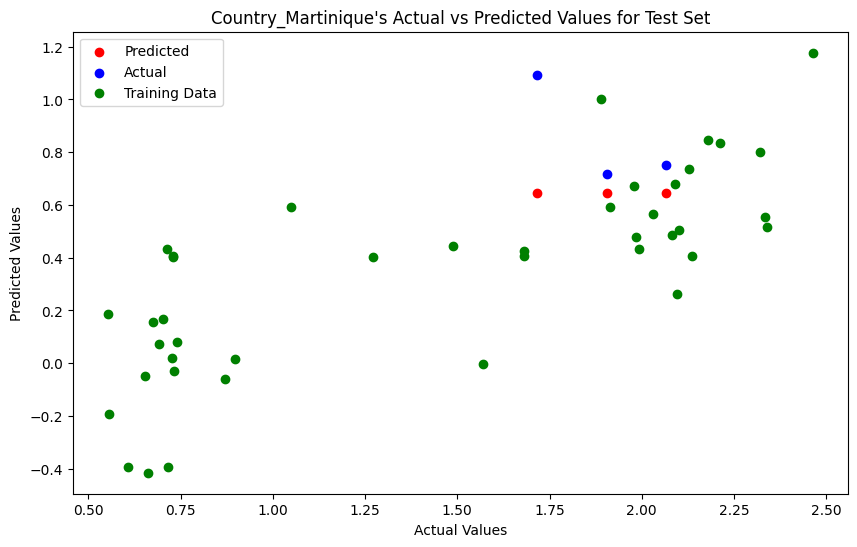

Epoch 1/50
8/8 [==============================] - 3s 75ms/step - loss: 0.0764 - mae: 0.3367 - val_loss: 0.1345 - val_mae: 0.5026
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0350 - mae: 0.1962 - val_loss: 0.0409 - val_mae: 0.2521
Epoch 3/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0318 - mae: 0.2206 - val_loss: 0.0329 - val_mae: 0.2183
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0337 - mae: 0.2003 - val_loss: 0.1498 - val_mae: 0.5313
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0283 - mae: 0.1865 - val_loss: 0.0653 - val_mae: 0.3370
Epoch 6/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0247 - mae: 0.1920 - val_loss: 0.0864 - val_mae: 0.3945
Epoch 7/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0258 - mae: 0.1797 - val_loss: 0.0552 - val_mae: 0.3050
Epoch 8/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0251 - mae: 0.1799 - val

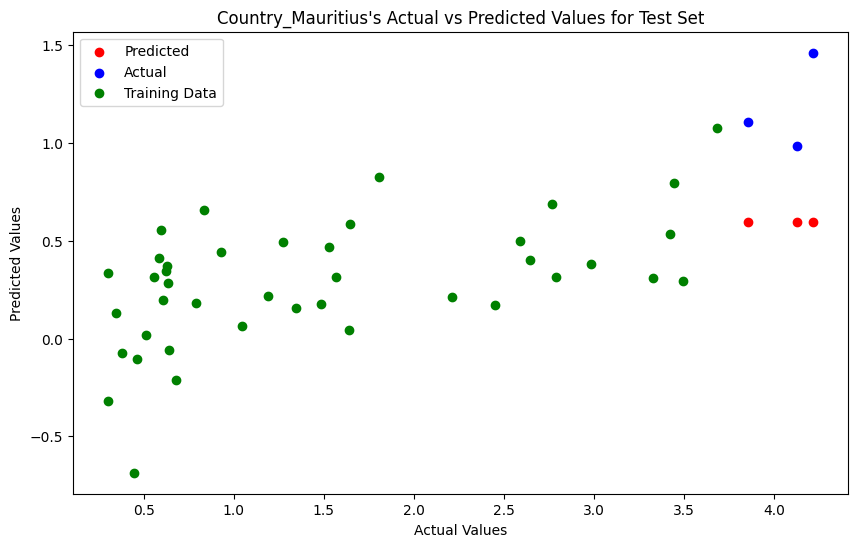

Epoch 1/50
8/8 [==============================] - 3s 79ms/step - loss: 0.0724 - mae: 0.3140 - val_loss: 0.3640 - val_mae: 0.8454
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0740 - mae: 0.3272 - val_loss: 0.1722 - val_mae: 0.5755
Epoch 3/50
8/8 [==============================] - 0s 30ms/step - loss: 0.0756 - mae: 0.3139 - val_loss: 0.2388 - val_mae: 0.6814
Epoch 4/50
8/8 [==============================] - 0s 26ms/step - loss: 0.0719 - mae: 0.3209 - val_loss: 0.2789 - val_mae: 0.7379
Epoch 5/50
8/8 [==============================] - 0s 33ms/step - loss: 0.0853 - mae: 0.3362 - val_loss: 0.2359 - val_mae: 0.6771
Epoch 6/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0842 - mae: 0.3412 - val_loss: 0.2947 - val_mae: 0.7590
Epoch 7/50
8/8 [==============================] - 0s 29ms/step - loss: 0.0781 - mae: 0.3279 - val_loss: 0.1588 - val_mae: 0.5517
Epoch 8/50
8/8 [==============================] - 0s 26ms/step - loss: 0.0689 - mae: 0.3084 - val

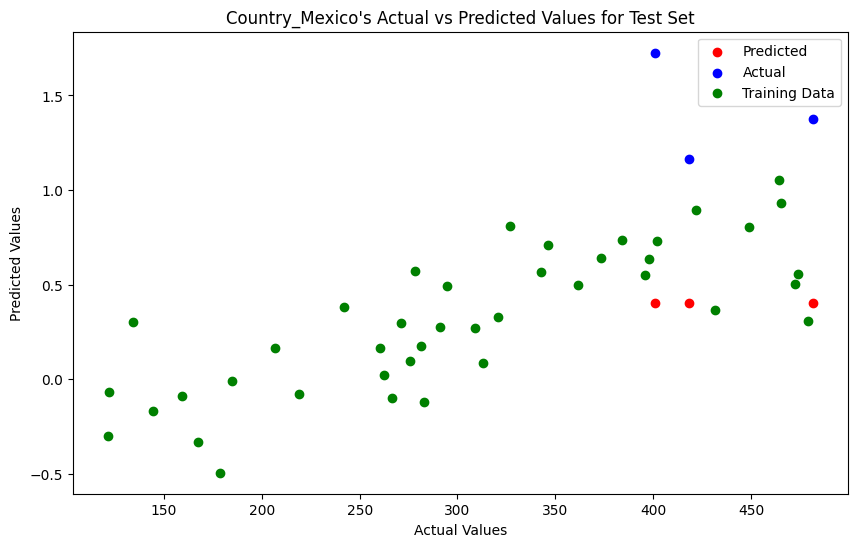

Epoch 1/50
8/8 [==============================] - 3s 73ms/step - loss: 0.3132 - mae: 0.6813 - val_loss: 0.5964 - val_mae: 1.0962
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2550 - mae: 0.6107 - val_loss: 0.6104 - val_mae: 1.1103
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.2454 - mae: 0.5904 - val_loss: 0.5196 - val_mae: 1.0166
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.2419 - mae: 0.5804 - val_loss: 0.6156 - val_mae: 1.1156
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.2598 - mae: 0.6132 - val_loss: 0.4334 - val_mae: 0.9232
Epoch 6/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2572 - mae: 0.6055 - val_loss: 0.5674 - val_mae: 1.0665
Epoch 7/50
8/8 [==============================] - 0s 19ms/step - loss: 0.2613 - mae: 0.6072 - val_loss: 0.4728 - val_mae: 0.9665
Epoch 8/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2714 - mae: 0.6231 - val

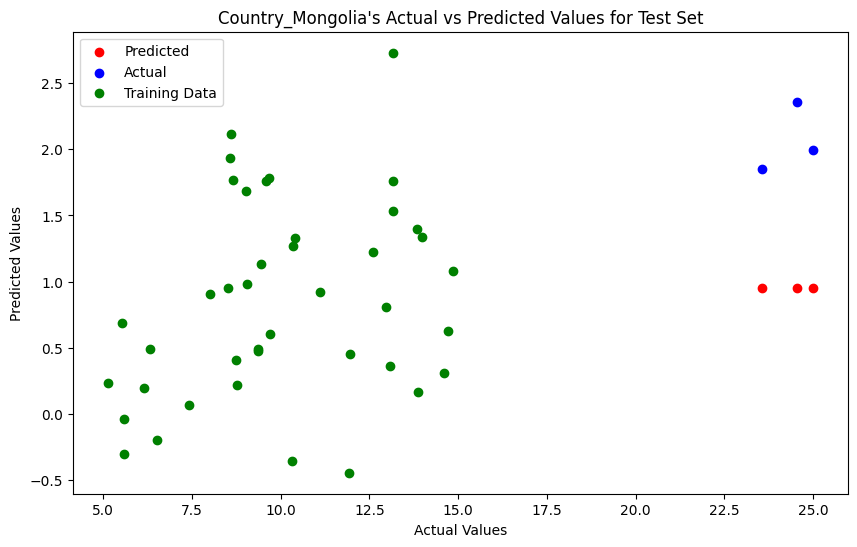

Epoch 1/50
8/8 [==============================] - 5s 78ms/step - loss: 0.1861 - mae: 0.4899 - val_loss: 0.2334 - val_mae: 0.6382
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1839 - mae: 0.5156 - val_loss: 0.2994 - val_mae: 0.7343
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1805 - mae: 0.5066 - val_loss: 0.1548 - val_mae: 0.5000
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1837 - mae: 0.4892 - val_loss: 0.1916 - val_mae: 0.5688
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1751 - mae: 0.4900 - val_loss: 0.2648 - val_mae: 0.6855
Epoch 6/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1885 - mae: 0.5218 - val_loss: 0.2554 - val_mae: 0.6717
Epoch 7/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1983 - mae: 0.5161 - val_loss: 0.1418 - val_mae: 0.4734
Epoch 8/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1858 - mae: 0.5078 - val

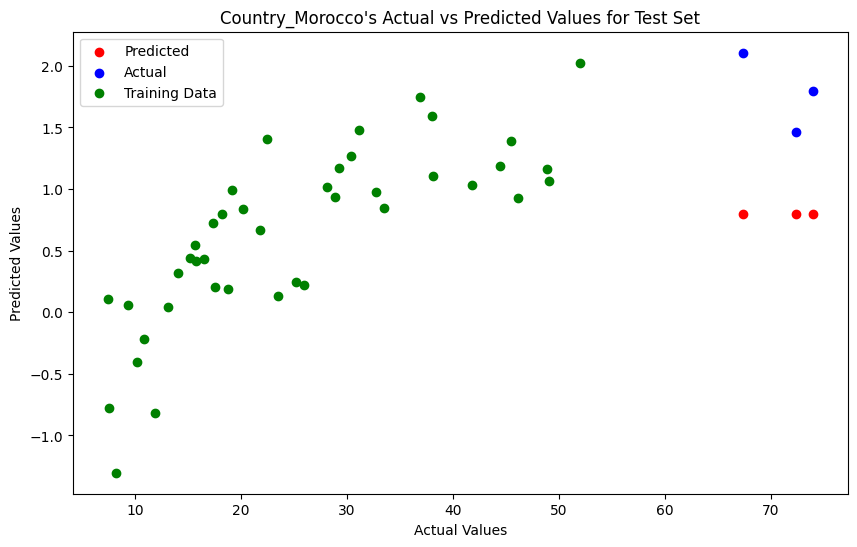

Epoch 1/50
8/8 [==============================] - 3s 110ms/step - loss: 0.1210 - mae: 0.4027 - val_loss: 0.1179 - val_mae: 0.3894
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1128 - mae: 0.4021 - val_loss: 0.0917 - val_mae: 0.4058
Epoch 3/50
8/8 [==============================] - 0s 23ms/step - loss: 0.1085 - mae: 0.3827 - val_loss: 0.0960 - val_mae: 0.4034
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0982 - mae: 0.3610 - val_loss: 0.0934 - val_mae: 0.4058
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1000 - mae: 0.3707 - val_loss: 0.0941 - val_mae: 0.4078
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1017 - mae: 0.3657 - val_loss: 0.0909 - val_mae: 0.4095
Epoch 7/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1016 - mae: 0.3767 - val_loss: 0.0976 - val_mae: 0.4048
Epoch 8/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1010 - mae: 0.3558 - va

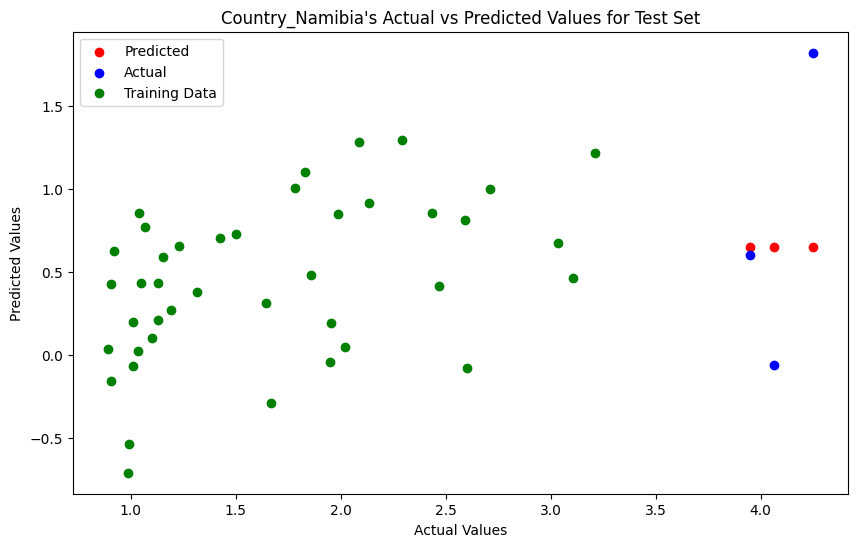

Epoch 1/50
8/8 [==============================] - 3s 75ms/step - loss: 0.0724 - mae: 0.3067 - val_loss: 0.0310 - val_mae: 0.1926
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0424 - mae: 0.2151 - val_loss: 0.0148 - val_mae: 0.1574
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0374 - mae: 0.2041 - val_loss: 0.0130 - val_mae: 0.1574
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0352 - mae: 0.1981 - val_loss: 0.0138 - val_mae: 0.1574
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0335 - mae: 0.1958 - val_loss: 0.0213 - val_mae: 0.1576
Epoch 6/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0316 - mae: 0.1833 - val_loss: 0.0147 - val_mae: 0.1575
Epoch 7/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0291 - mae: 0.1863 - val_loss: 0.0188 - val_mae: 0.1574
Epoch 8/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0289 - mae: 0.1665 - val

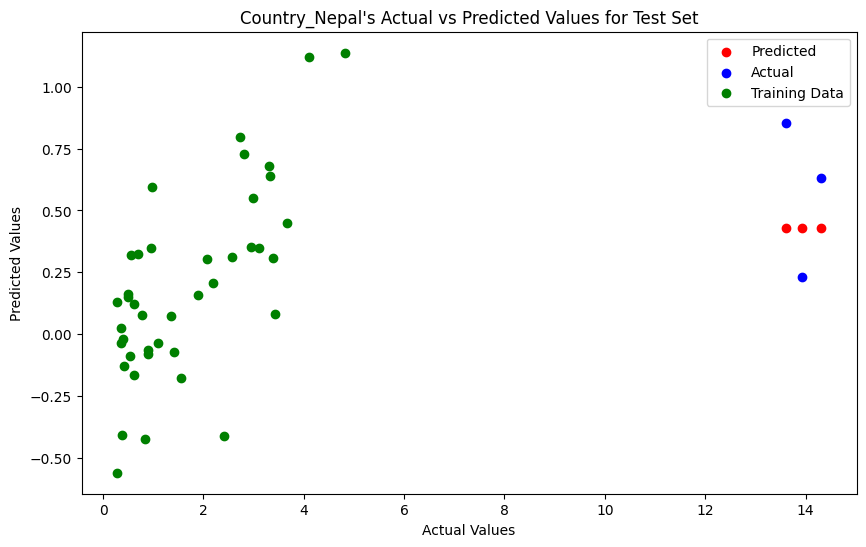

Epoch 1/50
8/8 [==============================] - 3s 73ms/step - loss: 0.3047 - mae: 0.7039 - val_loss: 0.6106 - val_mae: 1.0134
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.2949 - mae: 0.6724 - val_loss: 0.7672 - val_mae: 1.2247
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.2808 - mae: 0.6567 - val_loss: 0.6422 - val_mae: 1.0585
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2804 - mae: 0.6578 - val_loss: 0.8184 - val_mae: 1.2879
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.2938 - mae: 0.6792 - val_loss: 0.6516 - val_mae: 1.0717
Epoch 6/50
8/8 [==============================] - 0s 22ms/step - loss: 0.2927 - mae: 0.6808 - val_loss: 0.7638 - val_mae: 1.2204
Epoch 7/50
8/8 [==============================] - 0s 19ms/step - loss: 0.3073 - mae: 0.6950 - val_loss: 0.6381 - val_mae: 1.0528
Epoch 8/50
8/8 [==============================] - 0s 18ms/step - loss: 0.2959 - mae: 0.6850 - val

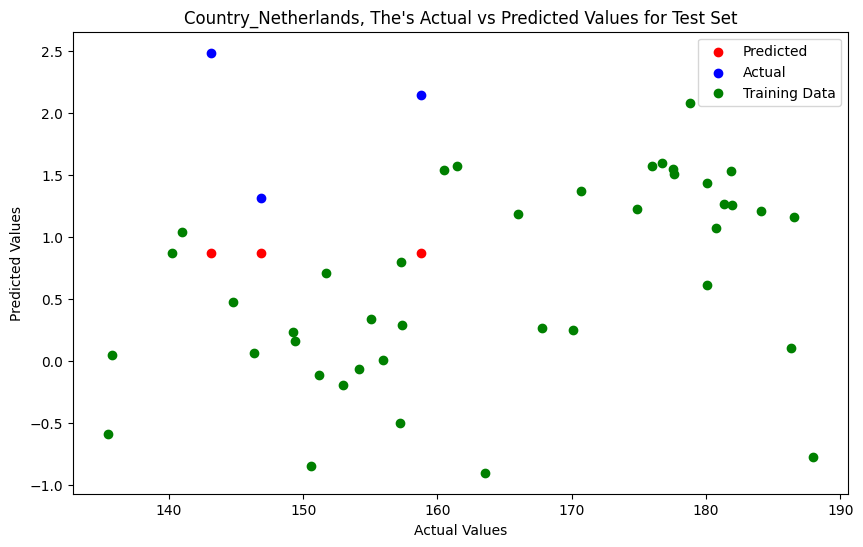

Epoch 1/50
8/8 [==============================] - 3s 106ms/step - loss: 0.0876 - mae: 0.3373 - val_loss: 0.0865 - val_mae: 0.4042
Epoch 2/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0750 - mae: 0.2982 - val_loss: 0.0555 - val_mae: 0.3224
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0672 - mae: 0.2766 - val_loss: 0.0587 - val_mae: 0.3328
Epoch 4/50
8/8 [==============================] - 0s 25ms/step - loss: 0.0628 - mae: 0.2691 - val_loss: 0.0711 - val_mae: 0.3677
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0630 - mae: 0.2639 - val_loss: 0.0493 - val_mae: 0.3035
Epoch 6/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0665 - mae: 0.2785 - val_loss: 0.0491 - val_mae: 0.3035
Epoch 7/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0643 - mae: 0.2639 - val_loss: 0.0511 - val_mae: 0.3095
Epoch 8/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0680 - mae: 0.2802 - va

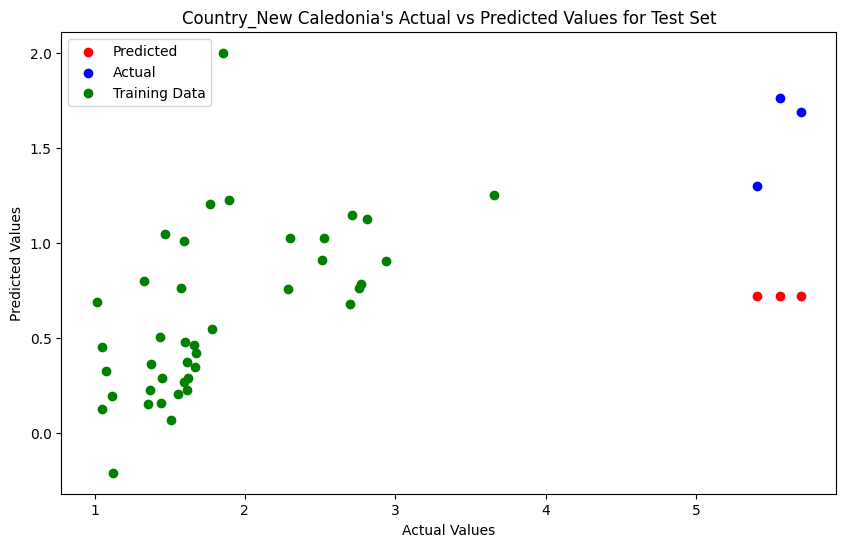

Epoch 1/50
8/8 [==============================] - 3s 76ms/step - loss: 0.1254 - mae: 0.4141 - val_loss: 0.1322 - val_mae: 0.5140
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0826 - mae: 0.3255 - val_loss: 0.0271 - val_mae: 0.2325
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0723 - mae: 0.2950 - val_loss: 0.0618 - val_mae: 0.3515
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0716 - mae: 0.3009 - val_loss: 0.0573 - val_mae: 0.3384
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0739 - mae: 0.3106 - val_loss: 0.0433 - val_mae: 0.2940
Epoch 6/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0716 - mae: 0.2940 - val_loss: 0.0391 - val_mae: 0.2795
Epoch 7/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0744 - mae: 0.2964 - val_loss: 0.0442 - val_mae: 0.2970
Epoch 8/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0727 - mae: 0.2964 - val

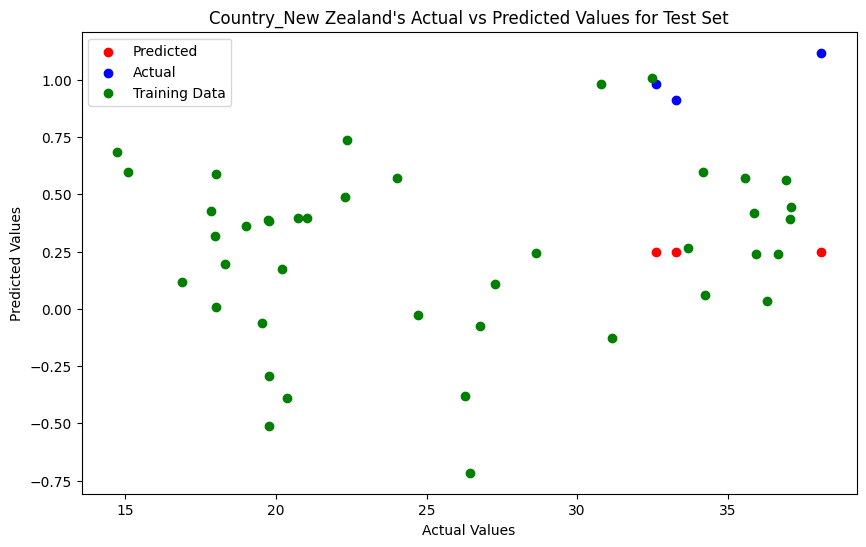

Epoch 1/50
8/8 [==============================] - 3s 76ms/step - loss: 0.0619 - mae: 0.2979 - val_loss: 0.1086 - val_mae: 0.4533
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0526 - mae: 0.2721 - val_loss: 0.0920 - val_mae: 0.4152
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0451 - mae: 0.2603 - val_loss: 0.0776 - val_mae: 0.3791
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0369 - mae: 0.2301 - val_loss: 0.0380 - val_mae: 0.2536
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0356 - mae: 0.2152 - val_loss: 0.0327 - val_mae: 0.2319
Epoch 6/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0343 - mae: 0.2097 - val_loss: 0.0205 - val_mae: 0.1714
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0319 - mae: 0.2060 - val_loss: 0.0247 - val_mae: 0.1940
Epoch 8/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0396 - mae: 0.2310 - val

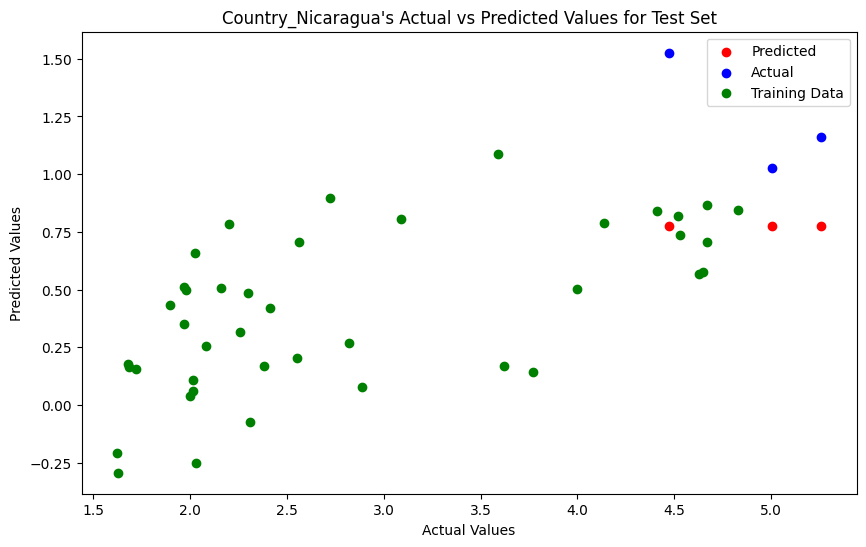

Epoch 1/50
8/8 [==============================] - 3s 82ms/step - loss: 0.1095 - mae: 0.3462 - val_loss: 0.0652 - val_mae: 0.3504
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1030 - mae: 0.3558 - val_loss: 0.0772 - val_mae: 0.3781
Epoch 3/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0807 - mae: 0.2922 - val_loss: 0.0492 - val_mae: 0.2847
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0768 - mae: 0.3297 - val_loss: 0.0443 - val_mae: 0.2590
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0708 - mae: 0.3089 - val_loss: 0.0657 - val_mae: 0.3153
Epoch 6/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0741 - mae: 0.2956 - val_loss: 0.0314 - val_mae: 0.2021
Epoch 7/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0760 - mae: 0.3002 - val_loss: 0.0298 - val_mae: 0.1900
Epoch 8/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0801 - mae: 0.3154 - val

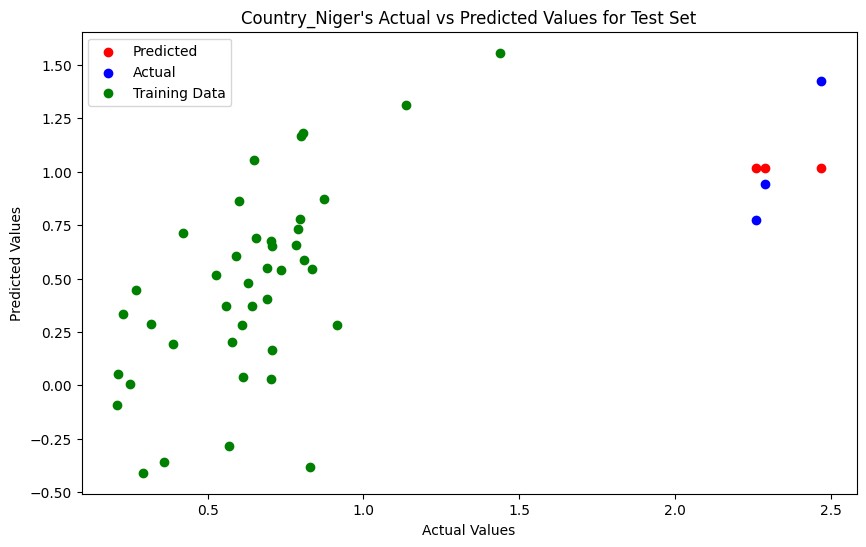

Epoch 1/50
8/8 [==============================] - 3s 71ms/step - loss: 0.1369 - mae: 0.4493 - val_loss: 0.2936 - val_mae: 0.7613
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0992 - mae: 0.3443 - val_loss: 0.1238 - val_mae: 0.4899
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0847 - mae: 0.3162 - val_loss: 0.1758 - val_mae: 0.5864
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0837 - mae: 0.3164 - val_loss: 0.1580 - val_mae: 0.5554
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0845 - mae: 0.3187 - val_loss: 0.1806 - val_mae: 0.5946
Epoch 6/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0843 - mae: 0.3187 - val_loss: 0.1500 - val_mae: 0.5406
Epoch 7/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0836 - mae: 0.3193 - val_loss: 0.1934 - val_mae: 0.6158
Epoch 8/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0832 - mae: 0.3208 - val

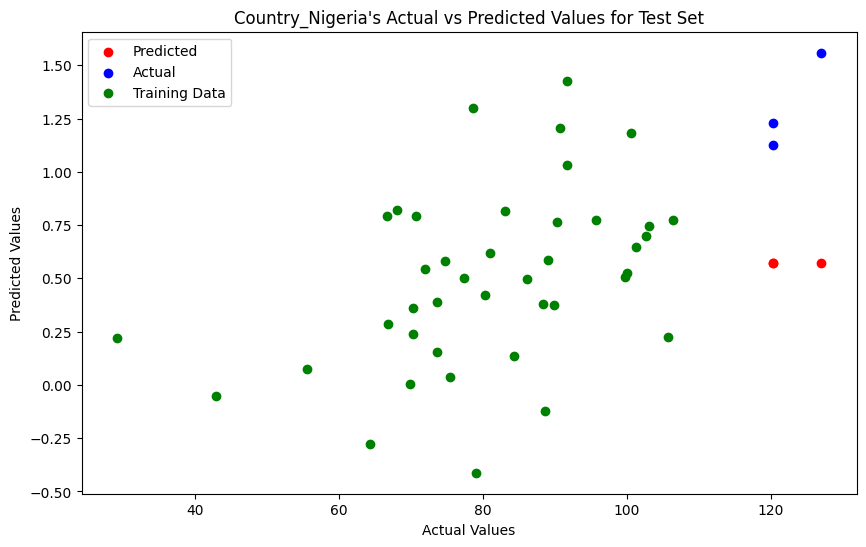

Epoch 1/50
8/8 [==============================] - 3s 75ms/step - loss: 0.3157 - mae: 0.6994 - val_loss: 0.9765 - val_mae: 1.4765
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.3155 - mae: 0.6956 - val_loss: 0.9503 - val_mae: 1.4503
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.3199 - mae: 0.6870 - val_loss: 0.8125 - val_mae: 1.3125
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.3095 - mae: 0.6890 - val_loss: 0.9985 - val_mae: 1.4985
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.3134 - mae: 0.6961 - val_loss: 1.0300 - val_mae: 1.5300
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.3141 - mae: 0.7002 - val_loss: 0.9255 - val_mae: 1.4255
Epoch 7/50
8/8 [==============================] - 0s 20ms/step - loss: 0.3172 - mae: 0.6834 - val_loss: 0.8613 - val_mae: 1.3613
Epoch 8/50
8/8 [==============================] - 0s 23ms/step - loss: 0.3147 - mae: 0.6891 - val

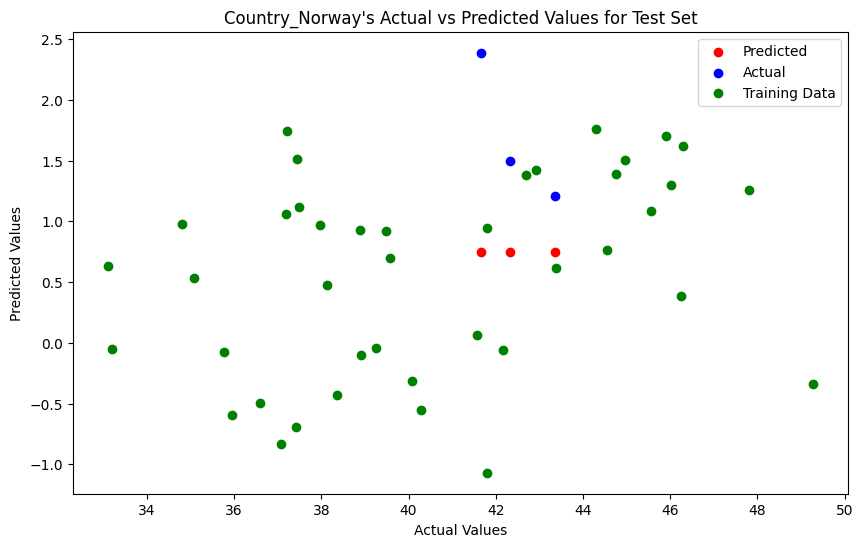

Epoch 1/50
8/8 [==============================] - 4s 114ms/step - loss: 0.1879 - mae: 0.5112 - val_loss: 0.2835 - val_mae: 0.6593
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1453 - mae: 0.4410 - val_loss: 0.4463 - val_mae: 0.8902
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1129 - mae: 0.3985 - val_loss: 0.1919 - val_mae: 0.5013
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1348 - mae: 0.4503 - val_loss: 0.1999 - val_mae: 0.5170
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1164 - mae: 0.4105 - val_loss: 0.3755 - val_mae: 0.7944
Epoch 6/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1214 - mae: 0.3986 - val_loss: 0.3014 - val_mae: 0.6867
Epoch 7/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1290 - mae: 0.4434 - val_loss: 0.2158 - val_mae: 0.5469
Epoch 8/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1178 - mae: 0.4028 - va

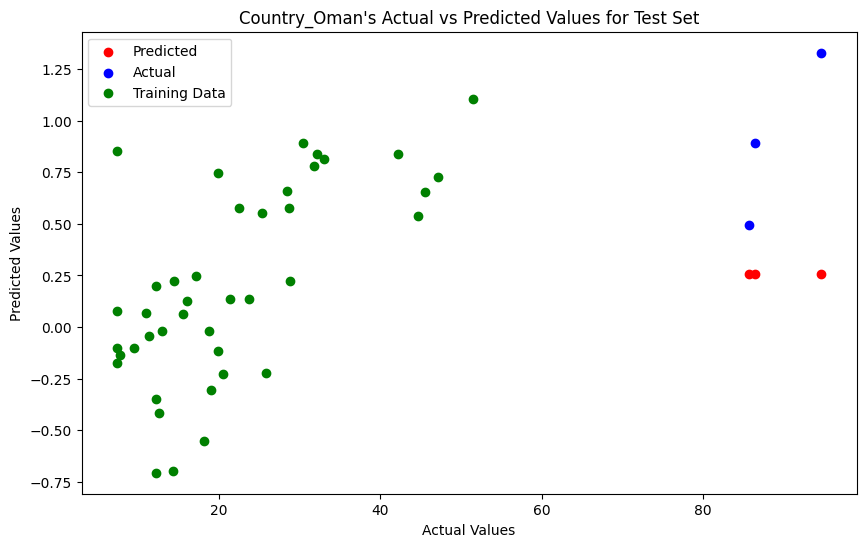

Epoch 1/50
8/8 [==============================] - 3s 79ms/step - loss: 0.1223 - mae: 0.4185 - val_loss: 0.0242 - val_mae: 0.2029
Epoch 2/50
8/8 [==============================] - 0s 24ms/step - loss: 0.1276 - mae: 0.4261 - val_loss: 0.0336 - val_mae: 0.2448
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1212 - mae: 0.4182 - val_loss: 0.0135 - val_mae: 0.1406
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1308 - mae: 0.4316 - val_loss: 0.0139 - val_mae: 0.1429
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1292 - mae: 0.4250 - val_loss: 0.0627 - val_mae: 0.3435
Epoch 6/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1299 - mae: 0.4281 - val_loss: 0.0285 - val_mae: 0.2229
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1439 - mae: 0.4609 - val_loss: 0.0067 - val_mae: 0.0855
Epoch 8/50
8/8 [==============================] - 0s 16ms/step - loss: 0.1324 - mae: 0.4285 - val

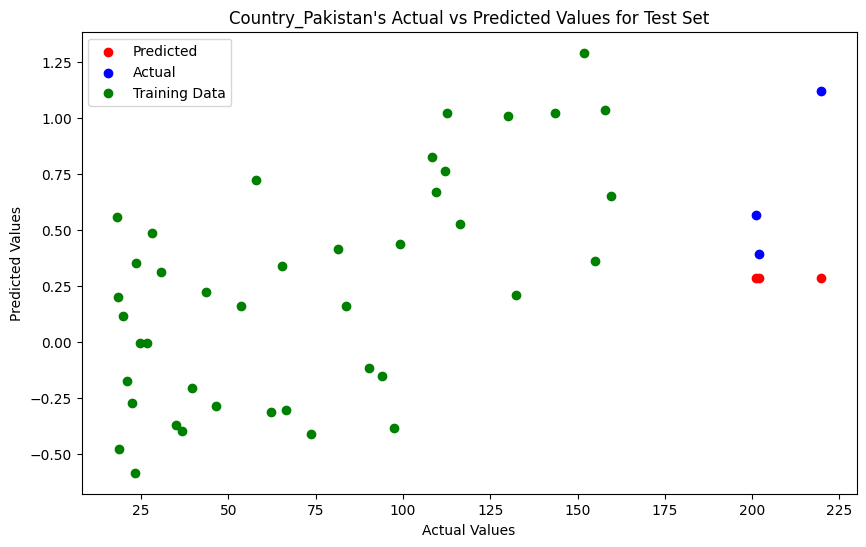

Epoch 1/50
8/8 [==============================] - 3s 76ms/step - loss: 0.0714 - mae: 0.3131 - val_loss: 0.2598 - val_mae: 0.7125
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0550 - mae: 0.2760 - val_loss: 0.2001 - val_mae: 0.6231
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0468 - mae: 0.2396 - val_loss: 0.0530 - val_mae: 0.3068
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0599 - mae: 0.2694 - val_loss: 0.1327 - val_mae: 0.5035
Epoch 5/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0428 - mae: 0.2386 - val_loss: 0.1498 - val_mae: 0.5364
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0427 - mae: 0.2370 - val_loss: 0.1356 - val_mae: 0.5092
Epoch 7/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0478 - mae: 0.2351 - val_loss: 0.1228 - val_mae: 0.4835
Epoch 8/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0495 - mae: 0.2510 - val

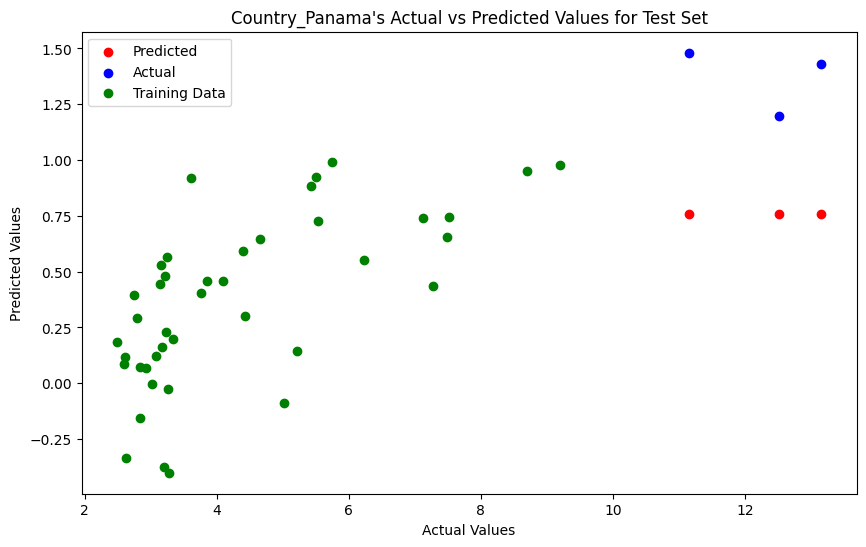

Epoch 1/50
8/8 [==============================] - 3s 74ms/step - loss: 0.0345 - mae: 0.2063 - val_loss: 0.0591 - val_mae: 0.3233
Epoch 2/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0390 - mae: 0.2144 - val_loss: 0.0545 - val_mae: 0.3089
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0279 - mae: 0.1831 - val_loss: 0.0317 - val_mae: 0.2233
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0237 - mae: 0.1589 - val_loss: 0.0307 - val_mae: 0.2189
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0272 - mae: 0.1892 - val_loss: 0.0449 - val_mae: 0.2764
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0310 - mae: 0.1872 - val_loss: 0.0315 - val_mae: 0.2229
Epoch 7/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0225 - mae: 0.1598 - val_loss: 0.0296 - val_mae: 0.2141
Epoch 8/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0220 - mae: 0.1550 - val

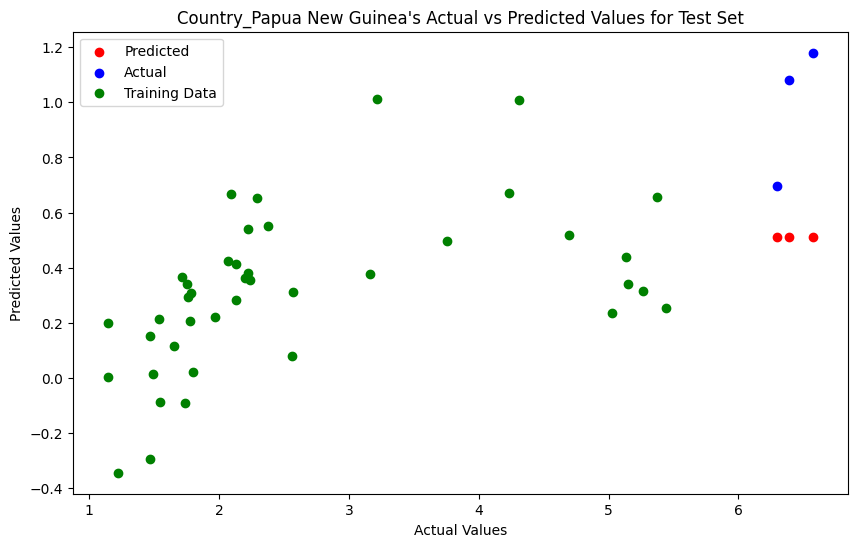

Epoch 1/50
8/8 [==============================] - 3s 78ms/step - loss: 0.0780 - mae: 0.3403 - val_loss: 0.3954 - val_mae: 0.8704
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0694 - mae: 0.3143 - val_loss: 0.4381 - val_mae: 0.9203
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0633 - mae: 0.3017 - val_loss: 0.3122 - val_mae: 0.7677
Epoch 4/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0669 - mae: 0.3182 - val_loss: 0.3239 - val_mae: 0.7828
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0703 - mae: 0.3196 - val_loss: 0.3657 - val_mae: 0.8346
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0733 - mae: 0.3144 - val_loss: 0.4316 - val_mae: 0.9128
Epoch 7/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0577 - mae: 0.2842 - val_loss: 0.3360 - val_mae: 0.7982
Epoch 8/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0635 - mae: 0.2994 - val

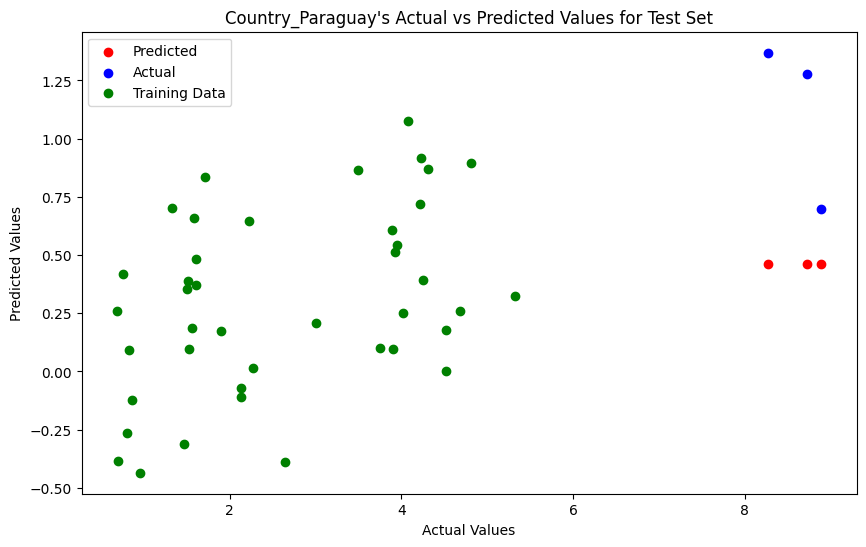

Epoch 1/50
8/8 [==============================] - 3s 76ms/step - loss: 0.0750 - mae: 0.3196 - val_loss: 0.2002 - val_mae: 0.6046
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0756 - mae: 0.3246 - val_loss: 0.2359 - val_mae: 0.6610
Epoch 3/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0734 - mae: 0.3219 - val_loss: 0.1625 - val_mae: 0.5387
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0791 - mae: 0.3309 - val_loss: 0.1989 - val_mae: 0.6025
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0748 - mae: 0.3203 - val_loss: 0.2367 - val_mae: 0.6623
Epoch 6/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0777 - mae: 0.3282 - val_loss: 0.1819 - val_mae: 0.5737
Epoch 7/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0761 - mae: 0.3226 - val_loss: 0.2167 - val_mae: 0.6313
Epoch 8/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0829 - mae: 0.3374 - val

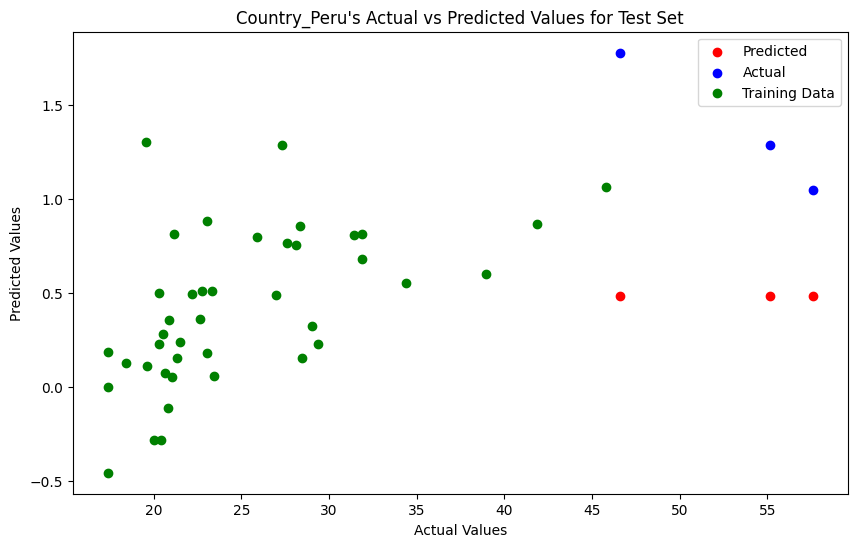

Epoch 1/50
8/8 [==============================] - 3s 118ms/step - loss: 0.0466 - mae: 0.2480 - val_loss: 0.1655 - val_mae: 0.5670
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0470 - mae: 0.2494 - val_loss: 0.1812 - val_mae: 0.5940
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0463 - mae: 0.2464 - val_loss: 0.1602 - val_mae: 0.5576
Epoch 4/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0483 - mae: 0.2551 - val_loss: 0.1460 - val_mae: 0.5314
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0469 - mae: 0.2455 - val_loss: 0.1964 - val_mae: 0.6191
Epoch 6/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0474 - mae: 0.2484 - val_loss: 0.1718 - val_mae: 0.5781
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0509 - mae: 0.2634 - val_loss: 0.1447 - val_mae: 0.5291
Epoch 8/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0496 - mae: 0.2555 - va

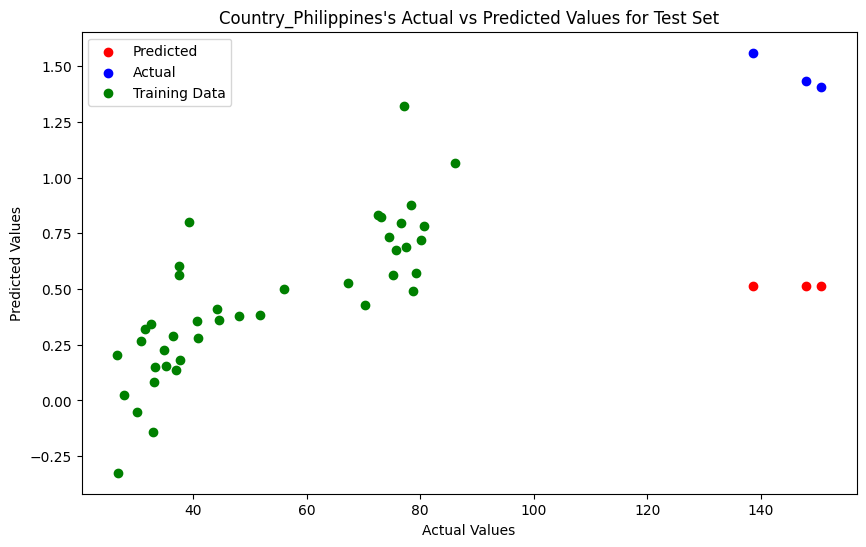

Epoch 1/50
8/8 [==============================] - 3s 76ms/step - loss: 0.1714 - mae: 0.4768 - val_loss: 0.2696 - val_mae: 0.7338
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1692 - mae: 0.4689 - val_loss: 0.2866 - val_mae: 0.7566
Epoch 3/50
8/8 [==============================] - 0s 21ms/step - loss: 0.1721 - mae: 0.4736 - val_loss: 0.2395 - val_mae: 0.6916
Epoch 4/50
8/8 [==============================] - 0s 21ms/step - loss: 0.1681 - mae: 0.4637 - val_loss: 0.3025 - val_mae: 0.7773
Epoch 5/50
8/8 [==============================] - 0s 22ms/step - loss: 0.1764 - mae: 0.4765 - val_loss: 0.2537 - val_mae: 0.7117
Epoch 6/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1733 - mae: 0.4773 - val_loss: 0.3577 - val_mae: 0.8453
Epoch 7/50
8/8 [==============================] - 0s 21ms/step - loss: 0.1749 - mae: 0.4875 - val_loss: 0.2217 - val_mae: 0.6653
Epoch 8/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1689 - mae: 0.4673 - val

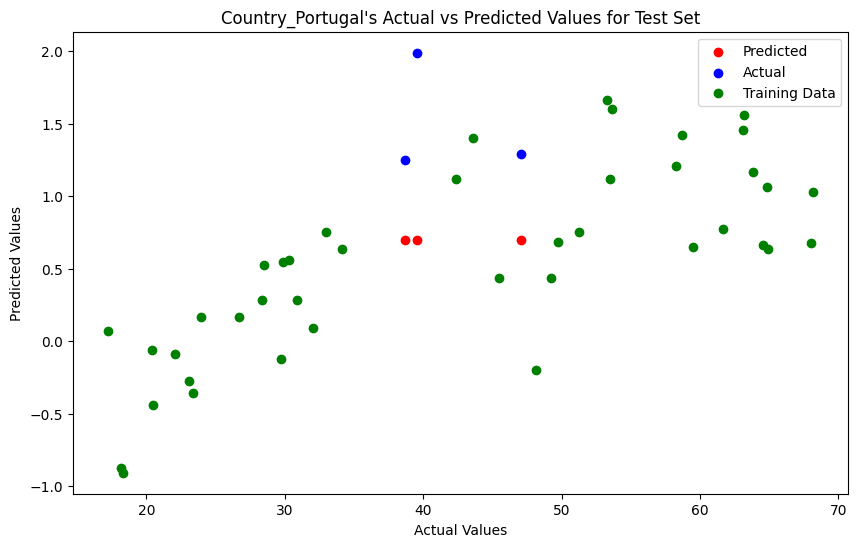

Epoch 1/50
8/8 [==============================] - 3s 74ms/step - loss: 0.0796 - mae: 0.3080 - val_loss: 0.0718 - val_mae: 0.3633
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0736 - mae: 0.3012 - val_loss: 0.0717 - val_mae: 0.3662
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0552 - mae: 0.2525 - val_loss: 0.0579 - val_mae: 0.3284
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0553 - mae: 0.2638 - val_loss: 0.0925 - val_mae: 0.4252
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0669 - mae: 0.2833 - val_loss: 0.1044 - val_mae: 0.4532
Epoch 6/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0823 - mae: 0.3248 - val_loss: 0.0528 - val_mae: 0.3132
Epoch 7/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0608 - mae: 0.2854 - val_loss: 0.0567 - val_mae: 0.3229
Epoch 8/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0587 - mae: 0.2703 - val

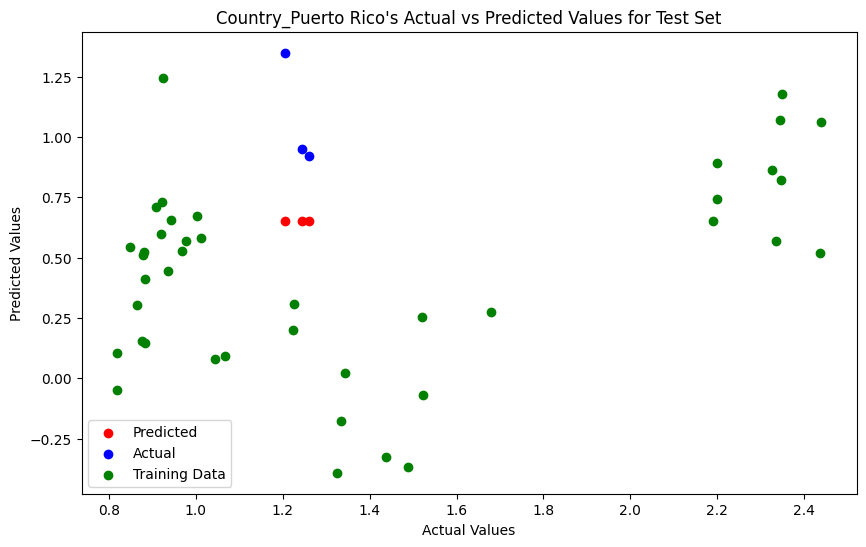

Epoch 1/50
8/8 [==============================] - 4s 82ms/step - loss: 0.2302 - mae: 0.5640 - val_loss: 0.8497 - val_mae: 1.3497
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2318 - mae: 0.5561 - val_loss: 0.8072 - val_mae: 1.3072
Epoch 3/50
8/8 [==============================] - 0s 21ms/step - loss: 0.2207 - mae: 0.5606 - val_loss: 0.6465 - val_mae: 1.1452
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.2221 - mae: 0.5650 - val_loss: 0.8225 - val_mae: 1.3225
Epoch 5/50
8/8 [==============================] - 0s 20ms/step - loss: 0.2346 - mae: 0.5653 - val_loss: 0.9218 - val_mae: 1.4218
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 0.2201 - mae: 0.5416 - val_loss: 0.6862 - val_mae: 1.1860
Epoch 7/50
8/8 [==============================] - 0s 19ms/step - loss: 0.2476 - mae: 0.6031 - val_loss: 0.7200 - val_mae: 1.2200
Epoch 8/50
8/8 [==============================] - 0s 20ms/step - loss: 0.2290 - mae: 0.5544 - val

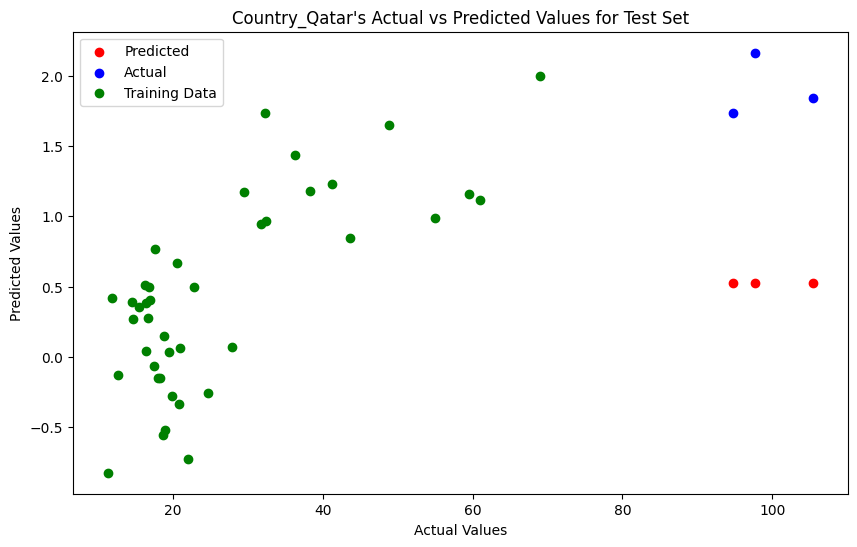

Epoch 1/50
8/8 [==============================] - 3s 81ms/step - loss: 0.2965 - mae: 0.6490 - val_loss: 0.7769 - val_mae: 1.2769
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.2922 - mae: 0.6376 - val_loss: 0.8723 - val_mae: 1.3723
Epoch 3/50
8/8 [==============================] - 0s 21ms/step - loss: 0.2953 - mae: 0.6472 - val_loss: 0.8456 - val_mae: 1.3456
Epoch 4/50
8/8 [==============================] - 0s 22ms/step - loss: 0.3187 - mae: 0.6743 - val_loss: 0.6146 - val_mae: 1.1146
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.2962 - mae: 0.6505 - val_loss: 0.8415 - val_mae: 1.3415
Epoch 6/50
8/8 [==============================] - 0s 17ms/step - loss: 0.3027 - mae: 0.6512 - val_loss: 0.9096 - val_mae: 1.4096
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.3097 - mae: 0.6699 - val_loss: 0.7102 - val_mae: 1.2102
Epoch 8/50
8/8 [==============================] - 0s 17ms/step - loss: 0.2967 - mae: 0.6521 - val

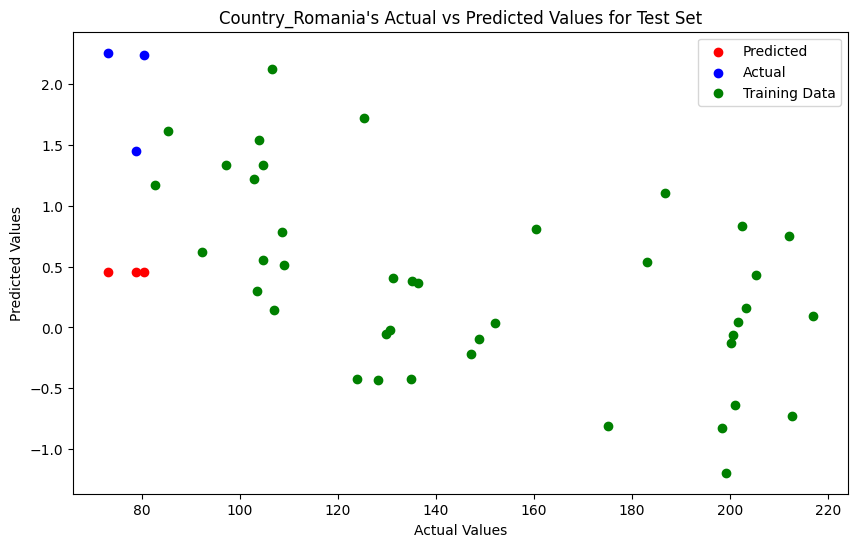

Epoch 1/50
8/8 [==============================] - 3s 91ms/step - loss: 0.2974 - mae: 0.6581 - val_loss: 0.0109 - val_mae: 0.1189
Epoch 2/50
8/8 [==============================] - 0s 27ms/step - loss: 0.3414 - mae: 0.6988 - val_loss: 0.0162 - val_mae: 0.1653
Epoch 3/50
8/8 [==============================] - 0s 29ms/step - loss: 0.2890 - mae: 0.6560 - val_loss: 0.0198 - val_mae: 0.1591
Epoch 4/50
8/8 [==============================] - 0s 29ms/step - loss: 0.3020 - mae: 0.6544 - val_loss: 0.0092 - val_mae: 0.1348
Epoch 5/50
8/8 [==============================] - 0s 23ms/step - loss: 0.3508 - mae: 0.7057 - val_loss: 0.0141 - val_mae: 0.1438
Epoch 6/50
8/8 [==============================] - 0s 26ms/step - loss: 0.3320 - mae: 0.6965 - val_loss: 0.1035 - val_mae: 0.4264
Epoch 7/50
8/8 [==============================] - 0s 27ms/step - loss: 0.3838 - mae: 0.7563 - val_loss: 0.0176 - val_mae: 0.1351
Epoch 8/50
8/8 [==============================] - 0s 18ms/step - loss: 0.2971 - mae: 0.6392 - val

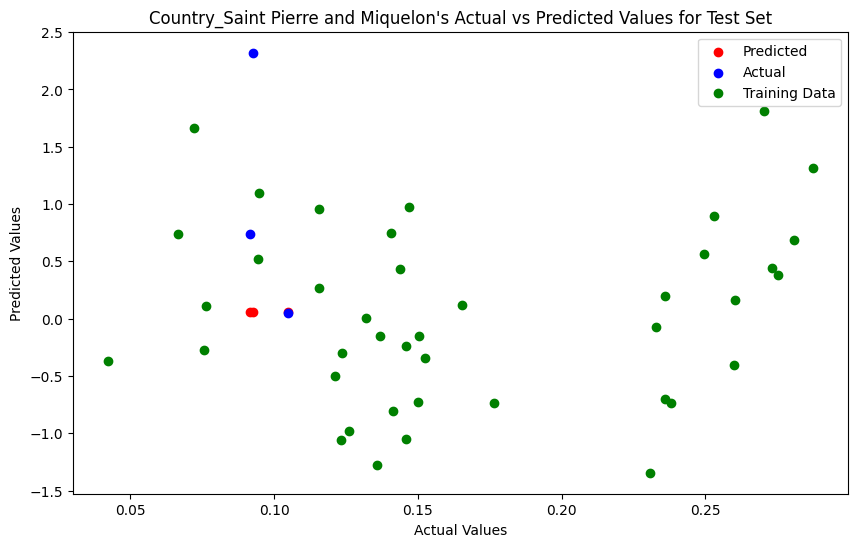

Epoch 1/50
8/8 [==============================] - 6s 83ms/step - loss: 0.1544 - mae: 0.4700 - val_loss: 0.0707 - val_mae: 0.3675
Epoch 2/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0978 - mae: 0.3531 - val_loss: 0.1398 - val_mae: 0.5222
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0677 - mae: 0.3239 - val_loss: 0.0183 - val_mae: 0.1724
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0715 - mae: 0.2983 - val_loss: 0.0186 - val_mae: 0.1738
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0788 - mae: 0.3342 - val_loss: 0.2190 - val_mae: 0.6570
Epoch 6/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0860 - mae: 0.3215 - val_loss: 0.0056 - val_mae: 0.0835
Epoch 7/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0688 - mae: 0.2964 - val_loss: 0.0648 - val_mae: 0.3502
Epoch 8/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0565 - mae: 0.2678 - val

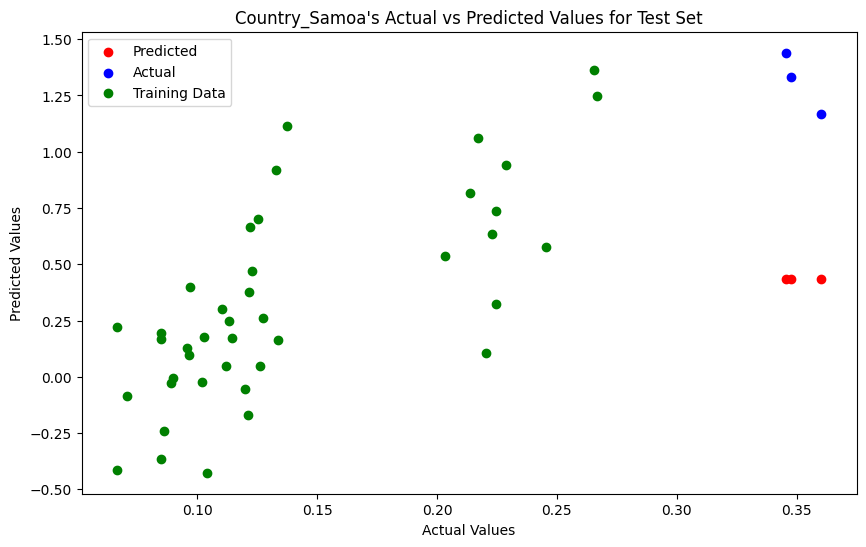

Epoch 1/50
8/8 [==============================] - 3s 82ms/step - loss: 0.2109 - mae: 0.5486 - val_loss: 0.7219 - val_mae: 1.2199
Epoch 2/50
8/8 [==============================] - 0s 23ms/step - loss: 0.2180 - mae: 0.5561 - val_loss: 0.7340 - val_mae: 1.2326
Epoch 3/50
8/8 [==============================] - 0s 26ms/step - loss: 0.2067 - mae: 0.5475 - val_loss: 0.5954 - val_mae: 1.0826
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.2054 - mae: 0.5429 - val_loss: 0.7902 - val_mae: 1.2902
Epoch 5/50
8/8 [==============================] - 0s 27ms/step - loss: 0.2177 - mae: 0.5447 - val_loss: 0.8423 - val_mae: 1.3423
Epoch 6/50
8/8 [==============================] - 0s 36ms/step - loss: 0.2043 - mae: 0.5472 - val_loss: 0.6491 - val_mae: 1.1421
Epoch 7/50
8/8 [==============================] - 0s 24ms/step - loss: 0.2197 - mae: 0.5653 - val_loss: 0.6499 - val_mae: 1.1430
Epoch 8/50
8/8 [==============================] - 0s 31ms/step - loss: 0.2142 - mae: 0.5568 - val

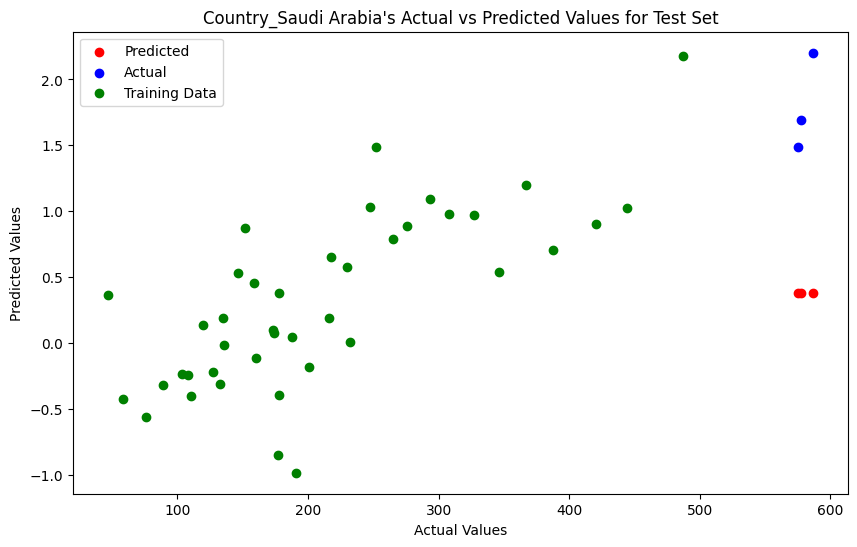

Epoch 1/50
8/8 [==============================] - 3s 77ms/step - loss: 0.1551 - mae: 0.4802 - val_loss: 0.0400 - val_mae: 0.2778
Epoch 2/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0856 - mae: 0.3446 - val_loss: 0.0083 - val_mae: 0.1175
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0588 - mae: 0.2718 - val_loss: 0.0024 - val_mae: 0.0535
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0551 - mae: 0.2712 - val_loss: 0.0016 - val_mae: 0.0535
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0445 - mae: 0.2307 - val_loss: 0.0069 - val_mae: 0.1050
Epoch 6/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0445 - mae: 0.2305 - val_loss: 0.0021 - val_mae: 0.0535
Epoch 7/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0510 - mae: 0.2489 - val_loss: 0.0066 - val_mae: 0.1015
Epoch 8/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0615 - mae: 0.2949 - val

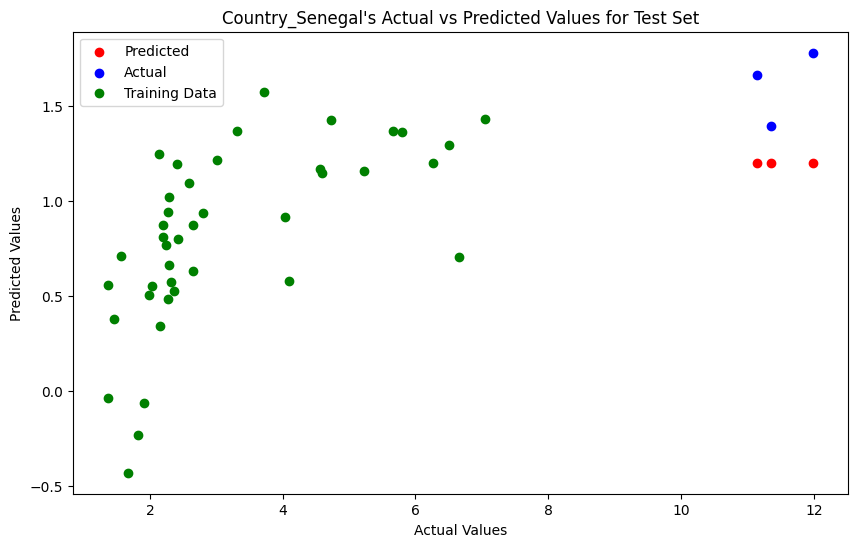

Epoch 1/50
8/8 [==============================] - 3s 76ms/step - loss: 0.0910 - mae: 0.3434 - val_loss: 0.1651 - val_mae: 0.5627
Epoch 2/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0761 - mae: 0.3551 - val_loss: 0.3802 - val_mae: 0.8639
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0443 - mae: 0.2395 - val_loss: 0.0818 - val_mae: 0.3819
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0486 - mae: 0.2484 - val_loss: 0.2288 - val_mae: 0.6686
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0453 - mae: 0.2461 - val_loss: 0.0869 - val_mae: 0.3891
Epoch 6/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0343 - mae: 0.2274 - val_loss: 0.1671 - val_mae: 0.5623
Epoch 7/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0384 - mae: 0.2052 - val_loss: 0.1070 - val_mae: 0.4443
Epoch 8/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0418 - mae: 0.2418 - val

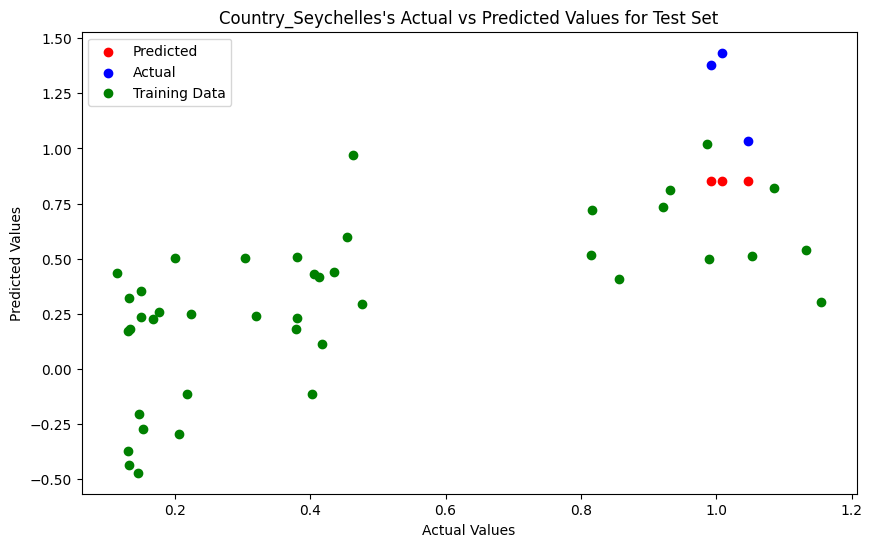

Epoch 1/50
8/8 [==============================] - 3s 105ms/step - loss: 0.0712 - mae: 0.2970 - val_loss: 0.0610 - val_mae: 0.3371
Epoch 2/50
8/8 [==============================] - 0s 28ms/step - loss: 0.0688 - mae: 0.2914 - val_loss: 0.0412 - val_mae: 0.2627
Epoch 3/50
8/8 [==============================] - 0s 27ms/step - loss: 0.0960 - mae: 0.3650 - val_loss: 0.2310 - val_mae: 0.6788
Epoch 4/50
8/8 [==============================] - 0s 33ms/step - loss: 0.0710 - mae: 0.3044 - val_loss: 0.2259 - val_mae: 0.6702
Epoch 5/50
8/8 [==============================] - 0s 33ms/step - loss: 0.0856 - mae: 0.3193 - val_loss: 0.0583 - val_mae: 0.3362
Epoch 6/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0563 - mae: 0.2729 - val_loss: 0.1113 - val_mae: 0.4716
Epoch 7/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0650 - mae: 0.3029 - val_loss: 0.1260 - val_mae: 0.5020
Epoch 8/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0691 - mae: 0.2980 - va

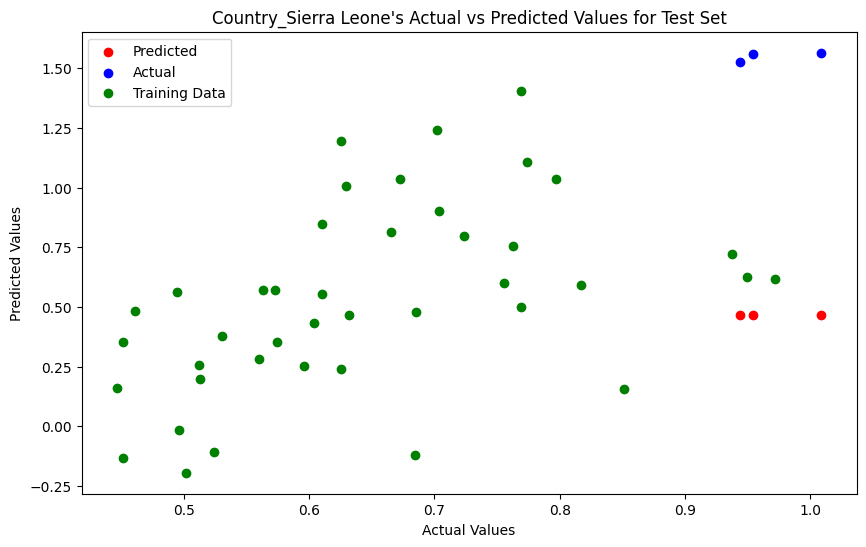

Epoch 1/50
8/8 [==============================] - 3s 75ms/step - loss: 0.0508 - mae: 0.2592 - val_loss: 0.1040 - val_mae: 0.4537
Epoch 2/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0298 - mae: 0.2020 - val_loss: 0.0045 - val_mae: 0.0747
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0232 - mae: 0.1718 - val_loss: 0.0052 - val_mae: 0.0896
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0290 - mae: 0.1903 - val_loss: 0.0373 - val_mae: 0.2695
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0286 - mae: 0.1958 - val_loss: 0.0032 - val_mae: 0.0611
Epoch 6/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0306 - mae: 0.1976 - val_loss: 0.0015 - val_mae: 0.0546
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0284 - mae: 0.1972 - val_loss: 0.0396 - val_mae: 0.2769
Epoch 8/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0403 - mae: 0.2291 - val

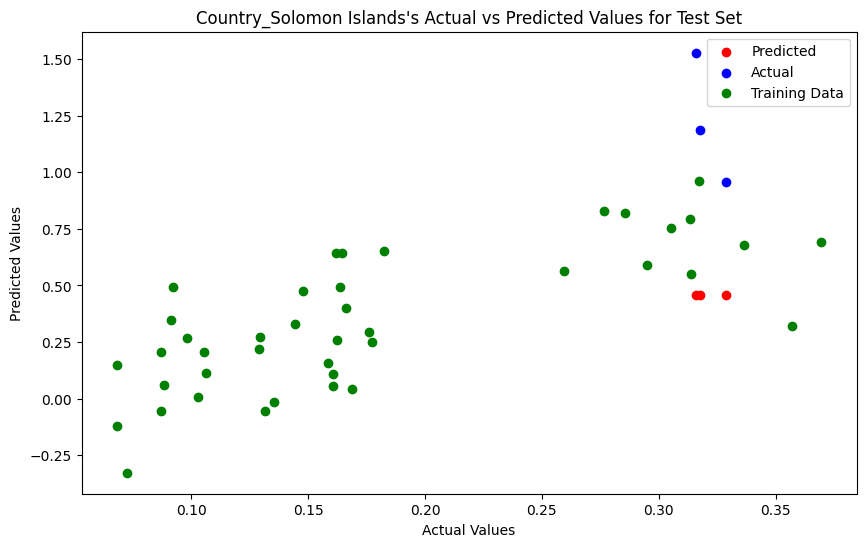

Epoch 1/50
8/8 [==============================] - 3s 77ms/step - loss: 0.0769 - mae: 0.3265 - val_loss: 0.2722 - val_mae: 0.7156
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0619 - mae: 0.2801 - val_loss: 0.3569 - val_mae: 0.8189
Epoch 3/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0556 - mae: 0.2619 - val_loss: 0.1639 - val_mae: 0.5467
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0654 - mae: 0.2928 - val_loss: 0.3843 - val_mae: 0.8571
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0521 - mae: 0.2641 - val_loss: 0.2488 - val_mae: 0.6747
Epoch 6/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0471 - mae: 0.2362 - val_loss: 0.4328 - val_mae: 0.9104
Epoch 7/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0515 - mae: 0.2587 - val_loss: 0.2807 - val_mae: 0.7270
Epoch 8/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0599 - mae: 0.2682 - val

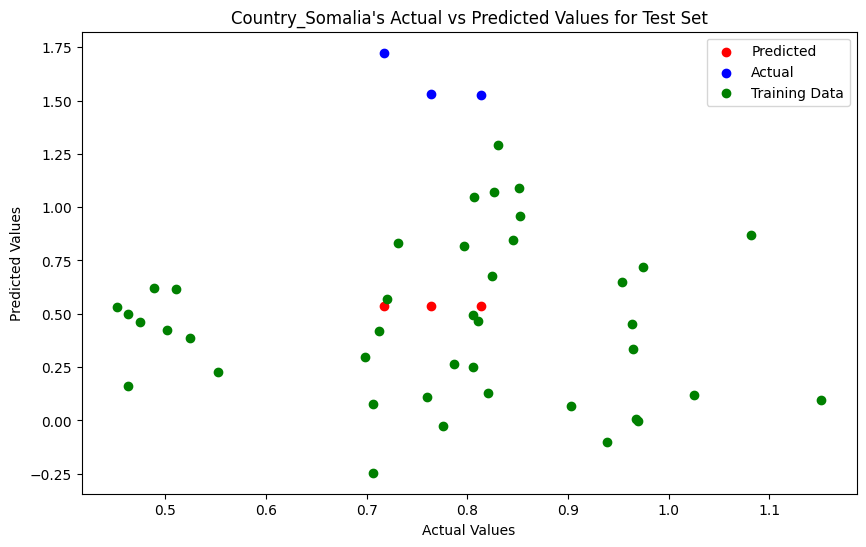

Epoch 1/50
8/8 [==============================] - 4s 99ms/step - loss: 0.0801 - mae: 0.3264 - val_loss: 0.2412 - val_mae: 0.6550
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0783 - mae: 0.3191 - val_loss: 0.2123 - val_mae: 0.6093
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0860 - mae: 0.3373 - val_loss: 0.2537 - val_mae: 0.6738
Epoch 4/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0800 - mae: 0.3240 - val_loss: 0.2391 - val_mae: 0.6518
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0794 - mae: 0.3216 - val_loss: 0.2453 - val_mae: 0.6613
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0874 - mae: 0.3342 - val_loss: 0.1995 - val_mae: 0.5879
Epoch 7/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0747 - mae: 0.3171 - val_loss: 0.3113 - val_mae: 0.7545
Epoch 8/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0792 - mae: 0.3250 - val

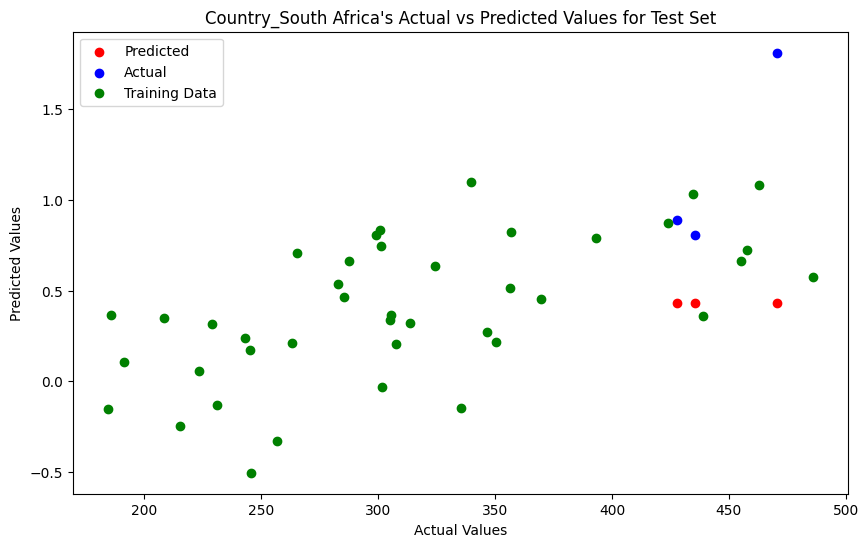

Epoch 1/50
8/8 [==============================] - 3s 80ms/step - loss: 0.0537 - mae: 0.2623 - val_loss: 0.1664 - val_mae: 0.5769
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0535 - mae: 0.2626 - val_loss: 0.1872 - val_mae: 0.6119
Epoch 3/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0505 - mae: 0.2576 - val_loss: 0.1435 - val_mae: 0.5357
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0517 - mae: 0.2566 - val_loss: 0.1443 - val_mae: 0.5373
Epoch 5/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0459 - mae: 0.2416 - val_loss: 0.1821 - val_mae: 0.6035
Epoch 6/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0415 - mae: 0.2236 - val_loss: 0.1095 - val_mae: 0.4680
Epoch 7/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0404 - mae: 0.2256 - val_loss: 0.1066 - val_mae: 0.4617
Epoch 8/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0446 - mae: 0.2329 - val

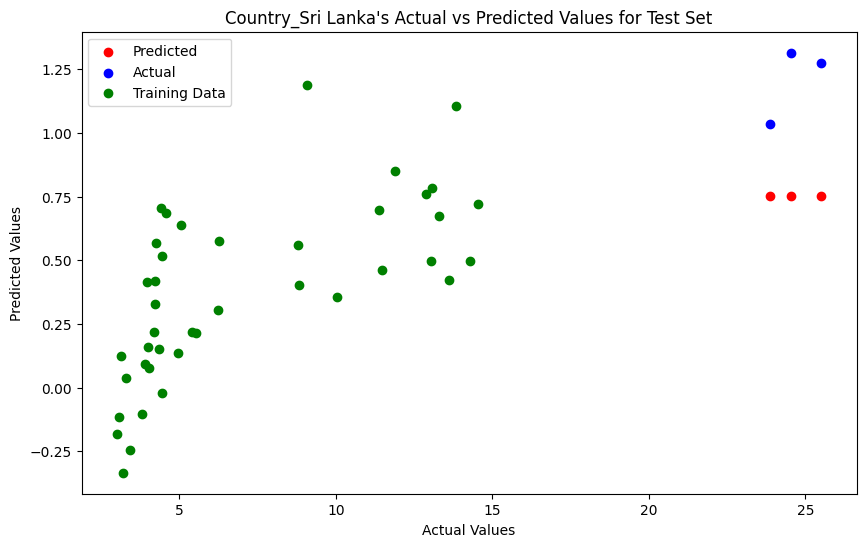

Epoch 1/50
8/8 [==============================] - 3s 77ms/step - loss: 0.0620 - mae: 0.2741 - val_loss: 0.0807 - val_mae: 0.3710
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0705 - mae: 0.2997 - val_loss: 0.0178 - val_mae: 0.1555
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0521 - mae: 0.2631 - val_loss: 0.0126 - val_mae: 0.1483
Epoch 4/50
8/8 [==============================] - 0s 26ms/step - loss: 0.0482 - mae: 0.2410 - val_loss: 0.0122 - val_mae: 0.1488
Epoch 5/50
8/8 [==============================] - 0s 34ms/step - loss: 0.0443 - mae: 0.2381 - val_loss: 0.0141 - val_mae: 0.1489
Epoch 6/50
8/8 [==============================] - 0s 30ms/step - loss: 0.0445 - mae: 0.2416 - val_loss: 0.0111 - val_mae: 0.1478
Epoch 7/50
8/8 [==============================] - 0s 31ms/step - loss: 0.0506 - mae: 0.2535 - val_loss: 0.0145 - val_mae: 0.1451
Epoch 8/50
8/8 [==============================] - 0s 29ms/step - loss: 0.0499 - mae: 0.2401 - val

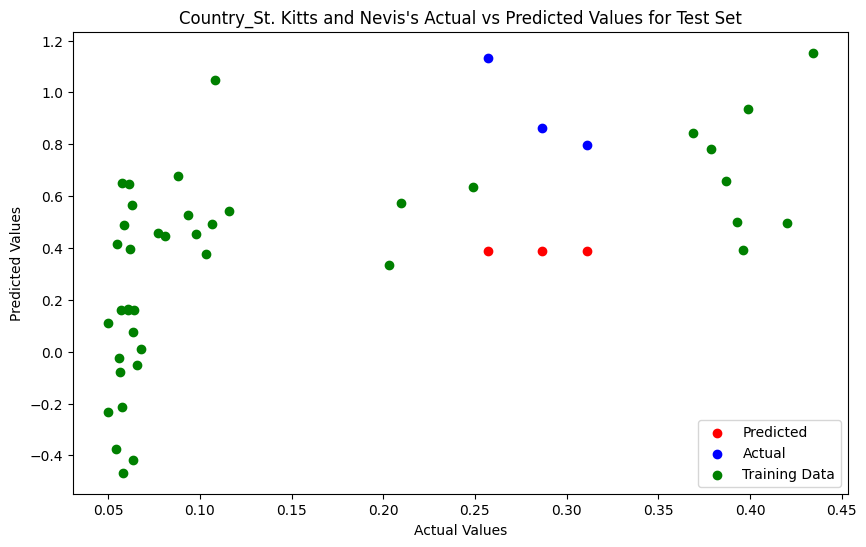

Epoch 1/50
8/8 [==============================] - 3s 76ms/step - loss: 0.0575 - mae: 0.2731 - val_loss: 0.0920 - val_mae: 0.4119
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0533 - mae: 0.2609 - val_loss: 0.0090 - val_mae: 0.1295
Epoch 3/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0398 - mae: 0.2146 - val_loss: 0.0234 - val_mae: 0.1764
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0325 - mae: 0.2201 - val_loss: 0.0139 - val_mae: 0.1220
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0294 - mae: 0.1943 - val_loss: 0.0073 - val_mae: 0.1207
Epoch 6/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0302 - mae: 0.1968 - val_loss: 0.0167 - val_mae: 0.1401
Epoch 7/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0316 - mae: 0.1971 - val_loss: 0.0115 - val_mae: 0.1190
Epoch 8/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0278 - mae: 0.1864 - val

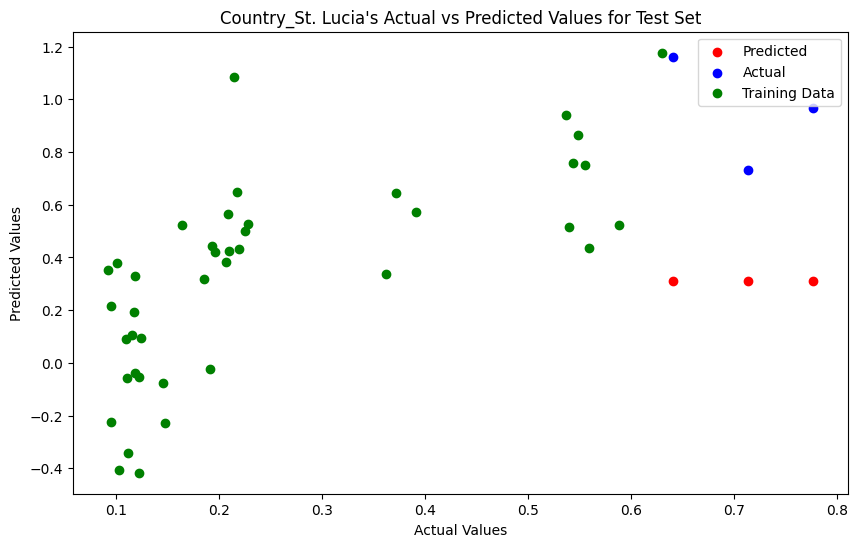

Epoch 1/50
8/8 [==============================] - 3s 78ms/step - loss: 0.0899 - mae: 0.3520 - val_loss: 0.0050 - val_mae: 0.0946
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0433 - mae: 0.2561 - val_loss: 0.0152 - val_mae: 0.1534
Epoch 3/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0353 - mae: 0.2130 - val_loss: 0.0036 - val_mae: 0.0732
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0266 - mae: 0.1985 - val_loss: 0.0213 - val_mae: 0.1894
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0321 - mae: 0.2247 - val_loss: 0.0065 - val_mae: 0.0816
Epoch 6/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0342 - mae: 0.2135 - val_loss: 0.0052 - val_mae: 0.0796
Epoch 7/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0565 - mae: 0.2620 - val_loss: 0.0070 - val_mae: 0.0884
Epoch 8/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0391 - mae: 0.2242 - val

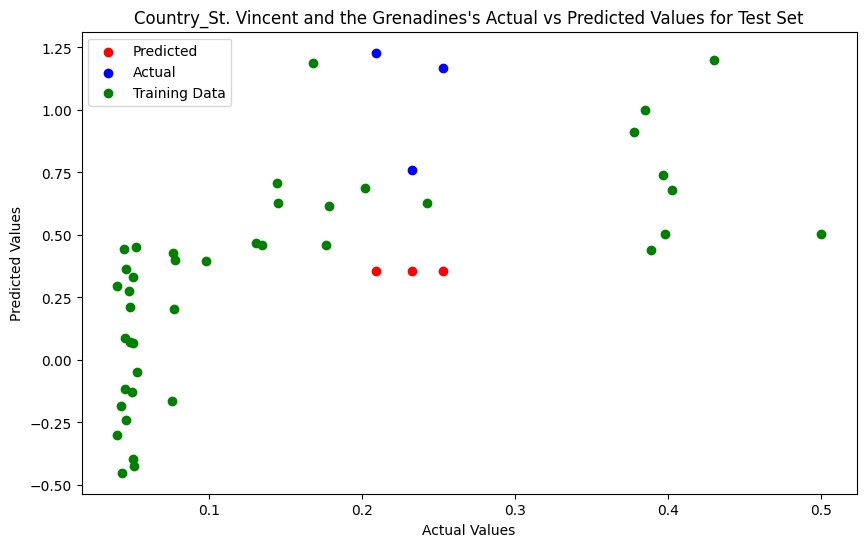

Epoch 1/50
8/8 [==============================] - 3s 114ms/step - loss: 0.1819 - mae: 0.5008 - val_loss: 0.4832 - val_mae: 0.9810
Epoch 2/50
8/8 [==============================] - 0s 27ms/step - loss: 0.1182 - mae: 0.3890 - val_loss: 0.2647 - val_mae: 0.7252
Epoch 3/50
8/8 [==============================] - 0s 25ms/step - loss: 0.1266 - mae: 0.4097 - val_loss: 0.4153 - val_mae: 0.9096
Epoch 4/50
8/8 [==============================] - 0s 26ms/step - loss: 0.1014 - mae: 0.3729 - val_loss: 0.6685 - val_mae: 1.1685
Epoch 5/50
8/8 [==============================] - 0s 29ms/step - loss: 0.1033 - mae: 0.3836 - val_loss: 0.7387 - val_mae: 1.2387
Epoch 6/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1210 - mae: 0.4131 - val_loss: 0.2951 - val_mae: 0.7528
Epoch 7/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1117 - mae: 0.3894 - val_loss: 0.5434 - val_mae: 1.0425
Epoch 8/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1220 - mae: 0.4129 - va

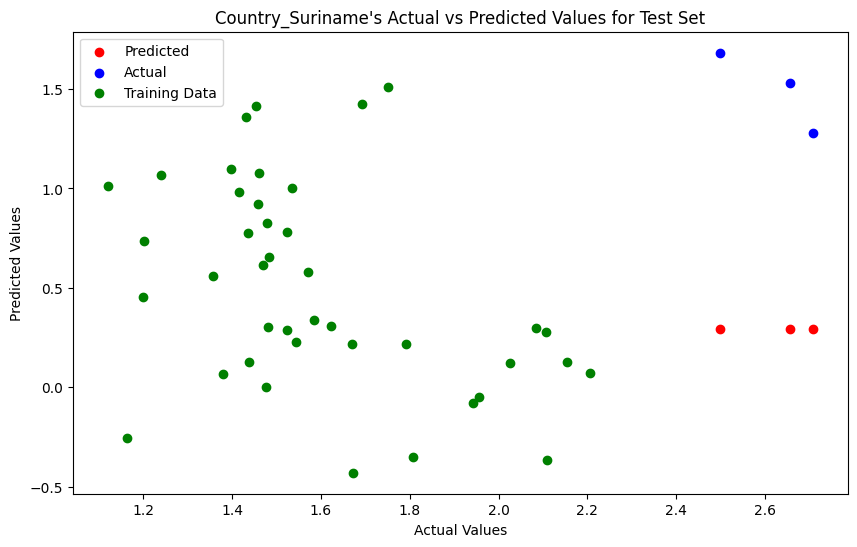

Epoch 1/50
8/8 [==============================] - 3s 76ms/step - loss: 0.4158 - mae: 0.8215 - val_loss: 0.7994 - val_mae: 1.2994
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.4396 - mae: 0.8474 - val_loss: 1.2386 - val_mae: 1.7386
Epoch 3/50
8/8 [==============================] - 0s 21ms/step - loss: 0.3990 - mae: 0.7718 - val_loss: 0.9512 - val_mae: 1.4512
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.3883 - mae: 0.7615 - val_loss: 1.1664 - val_mae: 1.6664
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.3930 - mae: 0.7895 - val_loss: 1.1769 - val_mae: 1.6769
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 0.3917 - mae: 0.7863 - val_loss: 1.0597 - val_mae: 1.5597
Epoch 7/50
8/8 [==============================] - 0s 19ms/step - loss: 0.3949 - mae: 0.7629 - val_loss: 1.0334 - val_mae: 1.5334
Epoch 8/50
8/8 [==============================] - 0s 19ms/step - loss: 0.3975 - mae: 0.7861 - val

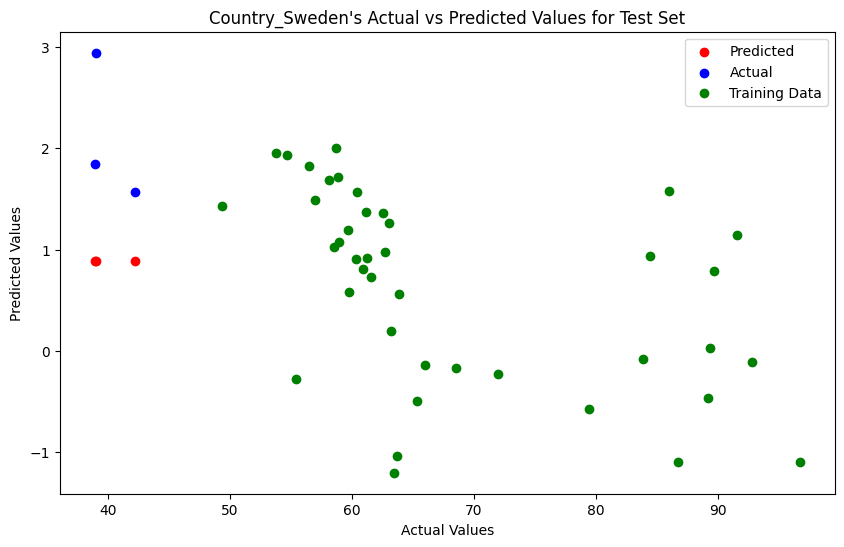

Epoch 1/50
8/8 [==============================] - 3s 77ms/step - loss: 0.0975 - mae: 0.3801 - val_loss: 0.1270 - val_mae: 0.5024
Epoch 2/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0678 - mae: 0.3048 - val_loss: 0.0029 - val_mae: 0.0657
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0349 - mae: 0.2184 - val_loss: 0.0021 - val_mae: 0.0515
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0367 - mae: 0.2229 - val_loss: 0.0014 - val_mae: 0.0405
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0419 - mae: 0.2367 - val_loss: 0.0069 - val_mae: 0.1105
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0373 - mae: 0.2262 - val_loss: 0.0055 - val_mae: 0.0964
Epoch 7/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0395 - mae: 0.2302 - val_loss: 0.0057 - val_mae: 0.0987
Epoch 8/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0375 - mae: 0.2175 - val

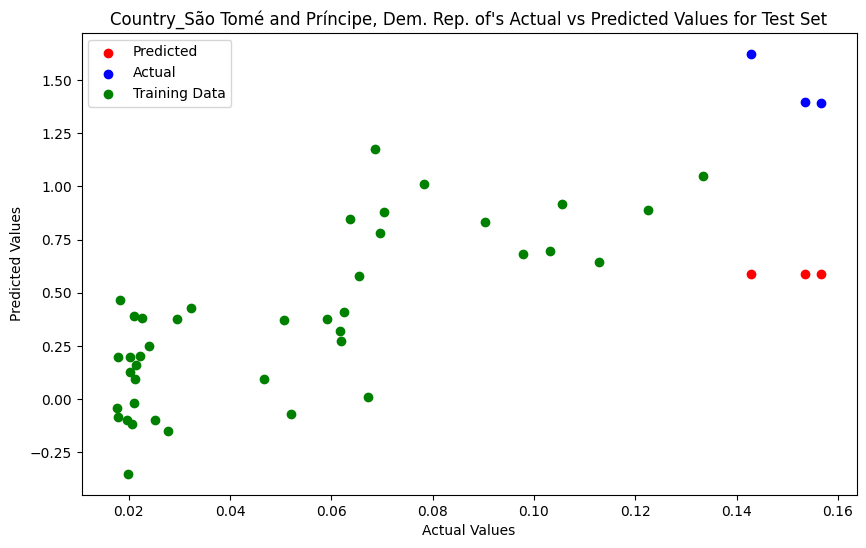

Epoch 1/50
8/8 [==============================] - 3s 76ms/step - loss: 0.0755 - mae: 0.2765 - val_loss: 0.2670 - val_mae: 0.6776
Epoch 2/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0759 - mae: 0.2776 - val_loss: 0.2596 - val_mae: 0.6667
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0741 - mae: 0.2735 - val_loss: 0.2112 - val_mae: 0.5896
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0766 - mae: 0.2842 - val_loss: 0.2159 - val_mae: 0.5975
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0744 - mae: 0.2712 - val_loss: 0.2615 - val_mae: 0.6695
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0746 - mae: 0.2754 - val_loss: 0.2483 - val_mae: 0.6495
Epoch 7/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0764 - mae: 0.2790 - val_loss: 0.2256 - val_mae: 0.6136
Epoch 8/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0770 - mae: 0.2834 - val

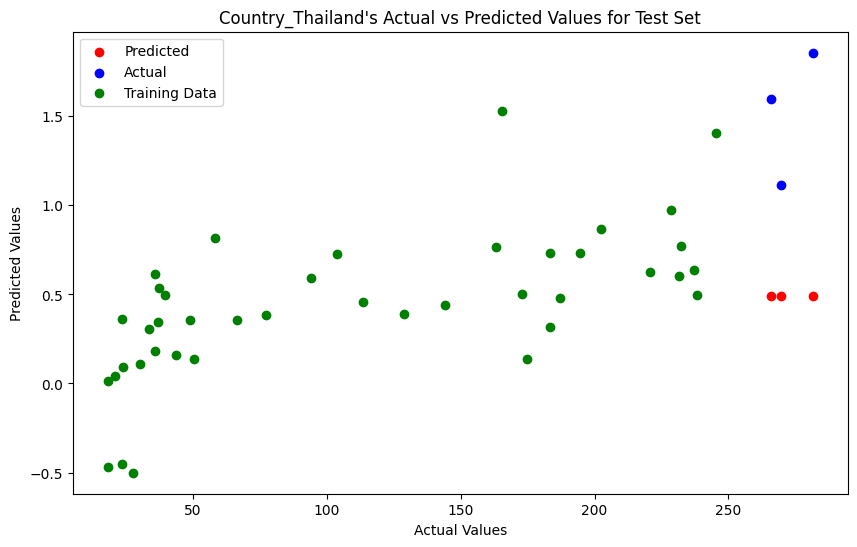

Epoch 1/50
8/8 [==============================] - 3s 75ms/step - loss: 0.0626 - mae: 0.2805 - val_loss: 0.2816 - val_mae: 0.7459
Epoch 2/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0525 - mae: 0.2560 - val_loss: 0.2685 - val_mae: 0.7281
Epoch 3/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0347 - mae: 0.2154 - val_loss: 0.2571 - val_mae: 0.7122
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0323 - mae: 0.2031 - val_loss: 0.2001 - val_mae: 0.6277
Epoch 5/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0392 - mae: 0.2250 - val_loss: 0.1627 - val_mae: 0.5650
Epoch 6/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0358 - mae: 0.2125 - val_loss: 0.1554 - val_mae: 0.5520
Epoch 7/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0323 - mae: 0.1847 - val_loss: 0.1191 - val_mae: 0.4821
Epoch 8/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0330 - mae: 0.1973 - val

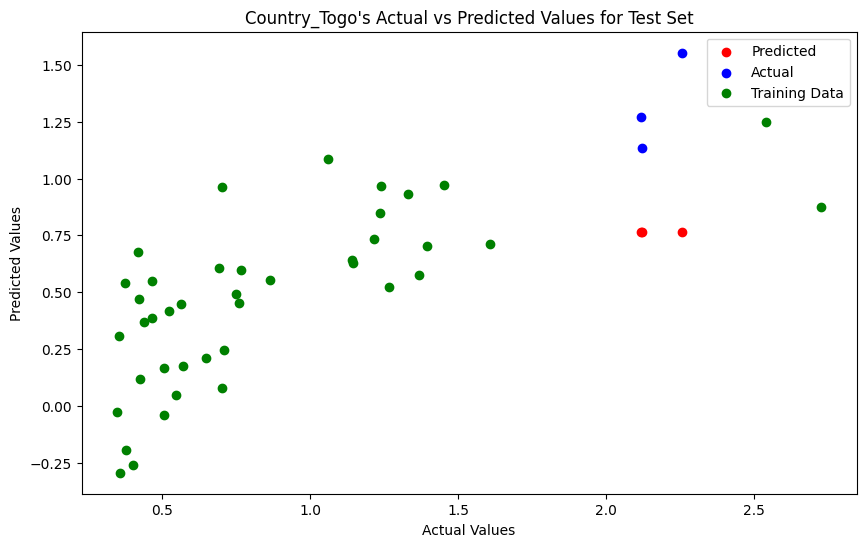

Epoch 1/50
8/8 [==============================] - 3s 93ms/step - loss: 0.0284 - mae: 0.2014 - val_loss: 0.0561 - val_mae: 0.3341
Epoch 2/50
8/8 [==============================] - 0s 35ms/step - loss: 0.0338 - mae: 0.2078 - val_loss: 0.0369 - val_mae: 0.2705
Epoch 3/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0306 - mae: 0.1931 - val_loss: 0.0517 - val_mae: 0.3206
Epoch 4/50
8/8 [==============================] - 0s 33ms/step - loss: 0.0267 - mae: 0.1855 - val_loss: 0.0282 - val_mae: 0.2362
Epoch 5/50
8/8 [==============================] - 0s 29ms/step - loss: 0.0298 - mae: 0.1905 - val_loss: 0.0340 - val_mae: 0.2595
Epoch 6/50
8/8 [==============================] - 0s 27ms/step - loss: 0.0270 - mae: 0.1830 - val_loss: 0.0515 - val_mae: 0.3200
Epoch 7/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0345 - mae: 0.2201 - val_loss: 0.0460 - val_mae: 0.3024
Epoch 8/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0309 - mae: 0.1976 - val

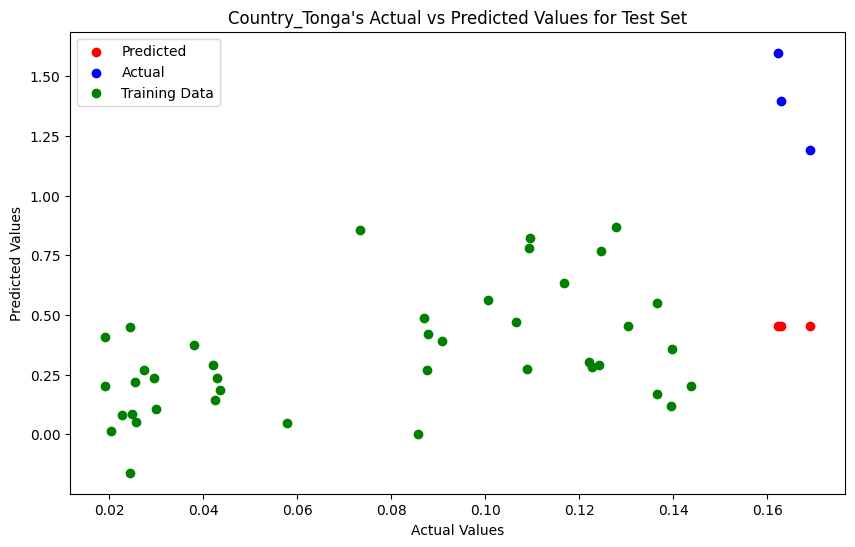

Epoch 1/50
8/8 [==============================] - 3s 75ms/step - loss: 0.0943 - mae: 0.3440 - val_loss: 0.1206 - val_mae: 0.4867
Epoch 2/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0966 - mae: 0.3479 - val_loss: 0.0981 - val_mae: 0.4381
Epoch 3/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0911 - mae: 0.3397 - val_loss: 0.0529 - val_mae: 0.3184
Epoch 4/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0941 - mae: 0.3394 - val_loss: 0.1009 - val_mae: 0.4443
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0917 - mae: 0.3330 - val_loss: 0.1007 - val_mae: 0.4438
Epoch 6/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0880 - mae: 0.3142 - val_loss: 0.0688 - val_mae: 0.3649
Epoch 7/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0771 - mae: 0.2921 - val_loss: 0.0685 - val_mae: 0.3641
Epoch 8/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0684 - mae: 0.2942 - val

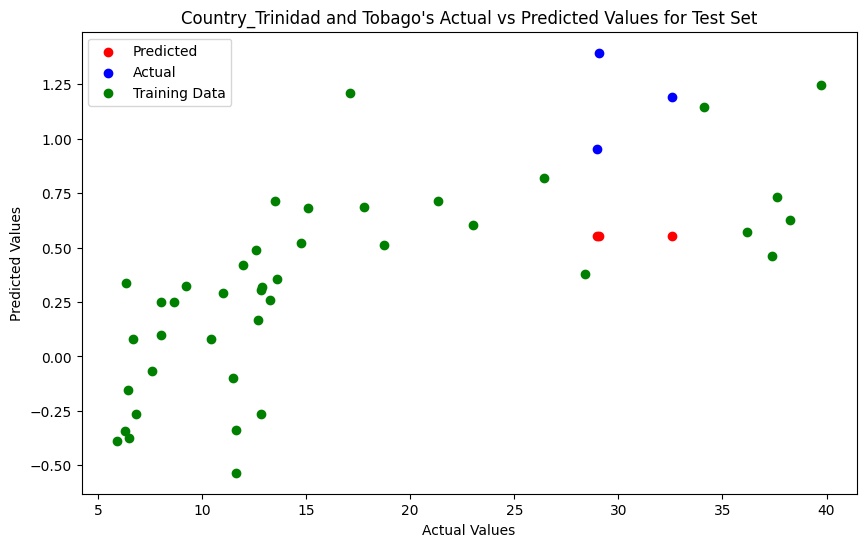

Epoch 1/50
8/8 [==============================] - 3s 79ms/step - loss: 0.1721 - mae: 0.4973 - val_loss: 0.2162 - val_mae: 0.5608
Epoch 2/50
8/8 [==============================] - 0s 22ms/step - loss: 0.1475 - mae: 0.4450 - val_loss: 0.2218 - val_mae: 0.5705
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1248 - mae: 0.3985 - val_loss: 0.0793 - val_mae: 0.3435
Epoch 4/50
8/8 [==============================] - 0s 23ms/step - loss: 0.1449 - mae: 0.4564 - val_loss: 0.9347 - val_mae: 1.4347
Epoch 5/50
8/8 [==============================] - 0s 24ms/step - loss: 0.3103 - mae: 0.7043 - val_loss: 0.2636 - val_mae: 0.6398
Epoch 6/50
8/8 [==============================] - 0s 23ms/step - loss: 0.2640 - mae: 0.6199 - val_loss: 0.3061 - val_mae: 0.7039
Epoch 7/50
8/8 [==============================] - 0s 21ms/step - loss: 0.3004 - mae: 0.6581 - val_loss: 0.4164 - val_mae: 0.8573
Epoch 8/50
8/8 [==============================] - 0s 20ms/step - loss: 0.3243 - mae: 0.6950 - val

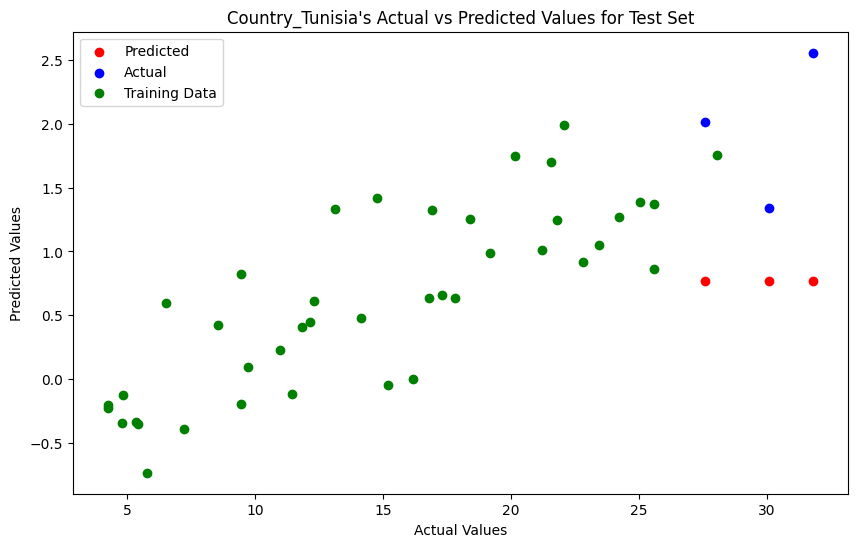

Epoch 1/50
8/8 [==============================] - 4s 106ms/step - loss: 0.0820 - mae: 0.3406 - val_loss: 0.2072 - val_mae: 0.6341
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0739 - mae: 0.3145 - val_loss: 0.0114 - val_mae: 0.1270
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0717 - mae: 0.3095 - val_loss: 0.0430 - val_mae: 0.2670
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0581 - mae: 0.2606 - val_loss: 0.0926 - val_mae: 0.4142
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0591 - mae: 0.2661 - val_loss: 0.1053 - val_mae: 0.4438
Epoch 6/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0636 - mae: 0.2827 - val_loss: 0.0760 - val_mae: 0.3718
Epoch 7/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0609 - mae: 0.2714 - val_loss: 0.1073 - val_mae: 0.4481
Epoch 8/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0623 - mae: 0.2715 - va

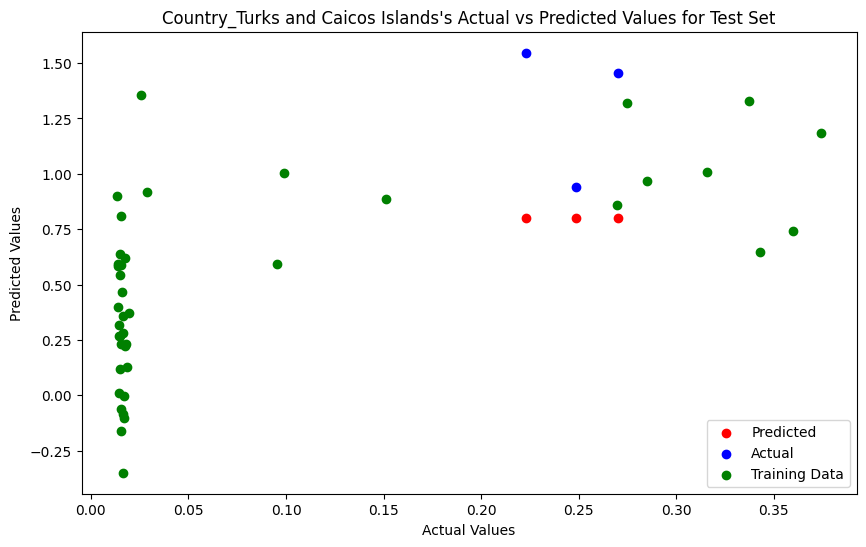

Epoch 1/50
8/8 [==============================] - 3s 79ms/step - loss: 0.0703 - mae: 0.3012 - val_loss: 0.0577 - val_mae: 0.3394
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0622 - mae: 0.3031 - val_loss: 0.0095 - val_mae: 0.1374
Epoch 3/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0388 - mae: 0.2346 - val_loss: 0.0140 - val_mae: 0.1671
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0427 - mae: 0.2423 - val_loss: 0.0058 - val_mae: 0.1072
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0303 - mae: 0.1973 - val_loss: 0.0129 - val_mae: 0.1600
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0295 - mae: 0.1969 - val_loss: 0.0110 - val_mae: 0.1476
Epoch 7/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0323 - mae: 0.2082 - val_loss: 0.0141 - val_mae: 0.1676
Epoch 8/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0280 - mae: 0.1876 - val

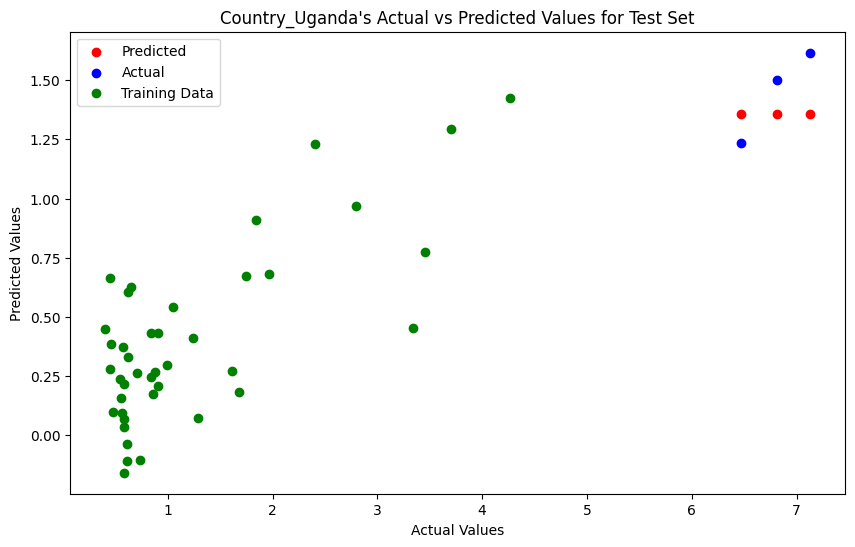

Epoch 1/50
8/8 [==============================] - 4s 118ms/step - loss: 0.3343 - mae: 0.7112 - val_loss: 0.6250 - val_mae: 1.1140
Epoch 2/50
8/8 [==============================] - 0s 26ms/step - loss: 0.2351 - mae: 0.5599 - val_loss: 0.3104 - val_mae: 0.7191
Epoch 3/50
8/8 [==============================] - 0s 27ms/step - loss: 0.2545 - mae: 0.6155 - val_loss: 0.6045 - val_mae: 1.0910
Epoch 4/50
8/8 [==============================] - 0s 27ms/step - loss: 0.2029 - mae: 0.5415 - val_loss: 0.7583 - val_mae: 1.2572
Epoch 5/50
8/8 [==============================] - 0s 37ms/step - loss: 0.2528 - mae: 0.6084 - val_loss: 0.2207 - val_mae: 0.5803
Epoch 6/50
8/8 [==============================] - 0s 19ms/step - loss: 0.2431 - mae: 0.6003 - val_loss: 0.5077 - val_mae: 0.9778
Epoch 7/50
8/8 [==============================] - 0s 20ms/step - loss: 0.2111 - mae: 0.5439 - val_loss: 0.7263 - val_mae: 1.2239
Epoch 8/50
8/8 [==============================] - 0s 23ms/step - loss: 0.2462 - mae: 0.5850 - va

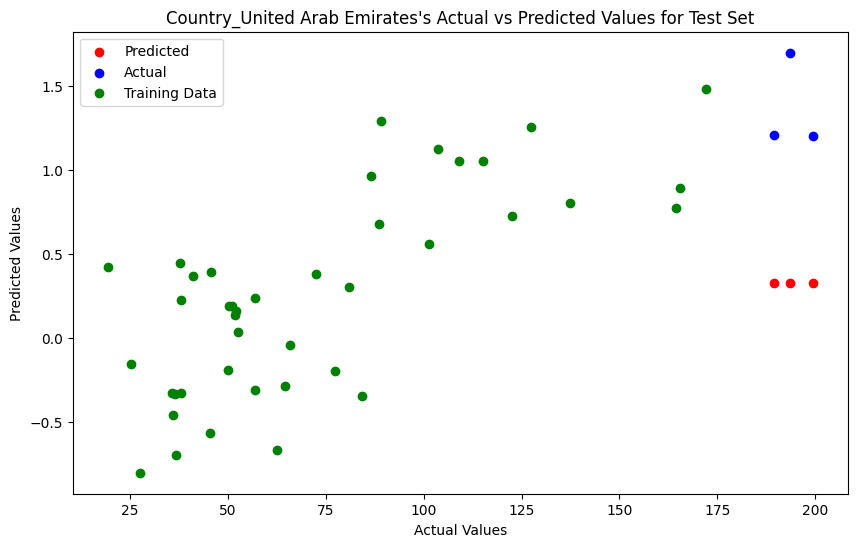

Epoch 1/50
8/8 [==============================] - 3s 75ms/step - loss: 0.1662 - mae: 0.4948 - val_loss: 0.3784 - val_mae: 0.6947
Epoch 2/50
8/8 [==============================] - 0s 21ms/step - loss: 0.1639 - mae: 0.4946 - val_loss: 0.3489 - val_mae: 0.6417
Epoch 3/50
8/8 [==============================] - 0s 23ms/step - loss: 0.1635 - mae: 0.4958 - val_loss: 0.3491 - val_mae: 0.6421
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1625 - mae: 0.4961 - val_loss: 0.4145 - val_mae: 0.7561
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1637 - mae: 0.4977 - val_loss: 0.3676 - val_mae: 0.6756
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1638 - mae: 0.4962 - val_loss: 0.3851 - val_mae: 0.7063
Epoch 7/50
8/8 [==============================] - 0s 21ms/step - loss: 0.1705 - mae: 0.5068 - val_loss: 0.3449 - val_mae: 0.6343
Epoch 8/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1664 - mae: 0.5017 - val

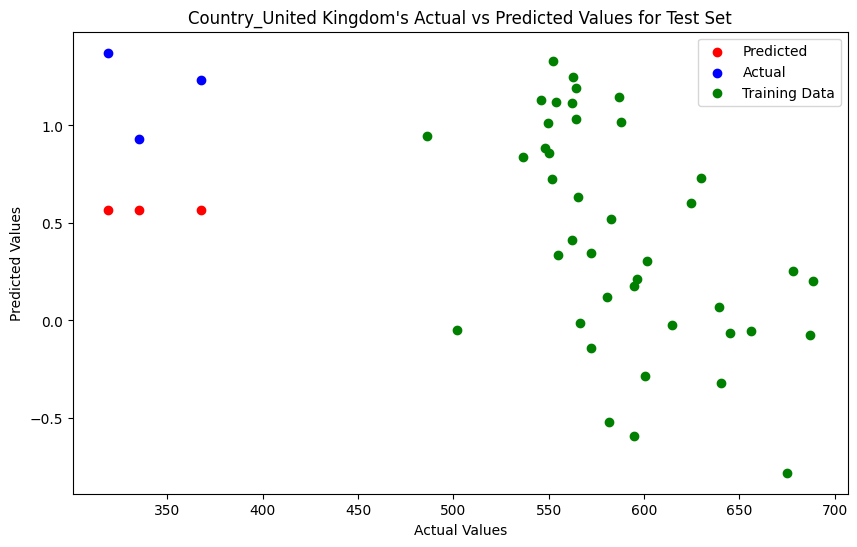

Epoch 1/50
8/8 [==============================] - 3s 78ms/step - loss: 0.1045 - mae: 0.3773 - val_loss: 0.2784 - val_mae: 0.5414
Epoch 2/50
8/8 [==============================] - 0s 27ms/step - loss: 0.1080 - mae: 0.3804 - val_loss: 0.3419 - val_mae: 0.6585
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1017 - mae: 0.3725 - val_loss: 0.2539 - val_mae: 0.5150
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1058 - mae: 0.3788 - val_loss: 0.2477 - val_mae: 0.5150
Epoch 5/50
8/8 [==============================] - 0s 27ms/step - loss: 0.1031 - mae: 0.3742 - val_loss: 0.3218 - val_mae: 0.6229
Epoch 6/50
8/8 [==============================] - 0s 18ms/step - loss: 0.1042 - mae: 0.3780 - val_loss: 0.2898 - val_mae: 0.5634
Epoch 7/50
8/8 [==============================] - 0s 20ms/step - loss: 0.1106 - mae: 0.3845 - val_loss: 0.2604 - val_mae: 0.5150
Epoch 8/50
8/8 [==============================] - 0s 31ms/step - loss: 0.1031 - mae: 0.3765 - val

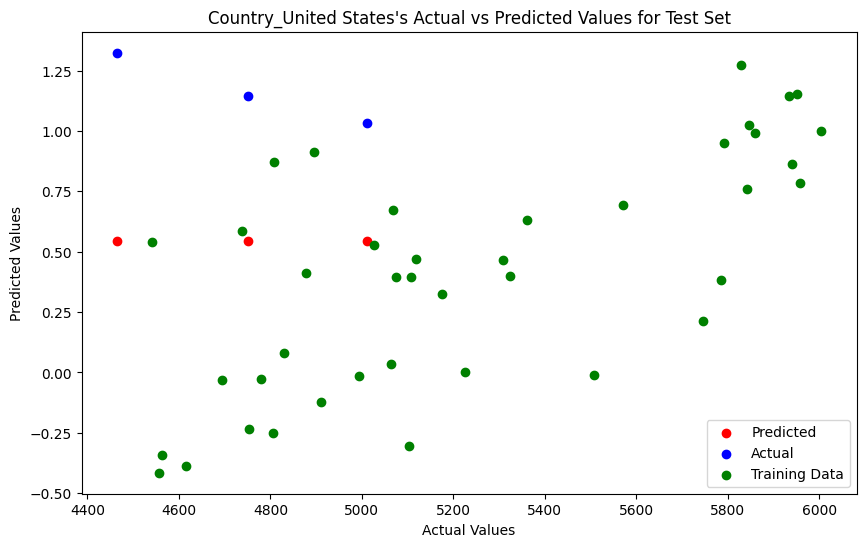

Epoch 1/50
8/8 [==============================] - 4s 78ms/step - loss: 0.0700 - mae: 0.2937 - val_loss: 0.2878 - val_mae: 0.7565
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0711 - mae: 0.3003 - val_loss: 0.3684 - val_mae: 0.8565
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0647 - mae: 0.2837 - val_loss: 0.2246 - val_mae: 0.6677
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0648 - mae: 0.2787 - val_loss: 0.2834 - val_mae: 0.7507
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0648 - mae: 0.2848 - val_loss: 0.2808 - val_mae: 0.7472
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0628 - mae: 0.2819 - val_loss: 0.3252 - val_mae: 0.8045
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0642 - mae: 0.2805 - val_loss: 0.2749 - val_mae: 0.7393
Epoch 8/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0637 - mae: 0.2822 - val

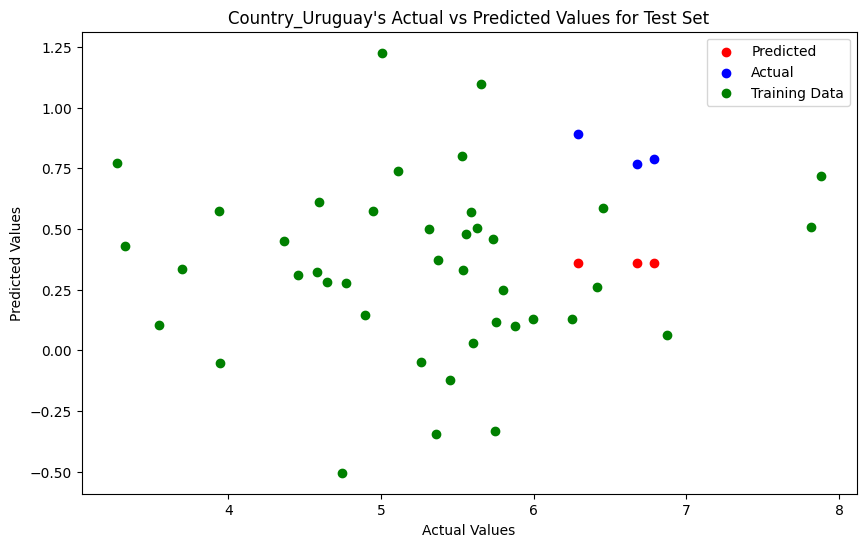

Epoch 1/50
8/8 [==============================] - 3s 81ms/step - loss: 0.0519 - mae: 0.2591 - val_loss: 0.0353 - val_mae: 0.2656
Epoch 2/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0498 - mae: 0.2784 - val_loss: 0.0326 - val_mae: 0.2555
Epoch 3/50
8/8 [==============================] - 0s 25ms/step - loss: 0.0424 - mae: 0.2323 - val_loss: 0.0139 - val_mae: 0.1667
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0407 - mae: 0.2417 - val_loss: 0.0158 - val_mae: 0.1775
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0443 - mae: 0.2446 - val_loss: 0.0044 - val_mae: 0.0939
Epoch 6/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0434 - mae: 0.2456 - val_loss: 0.0061 - val_mae: 0.1100
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0470 - mae: 0.2667 - val_loss: 0.0140 - val_mae: 0.1670
Epoch 8/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0551 - mae: 0.2550 - val

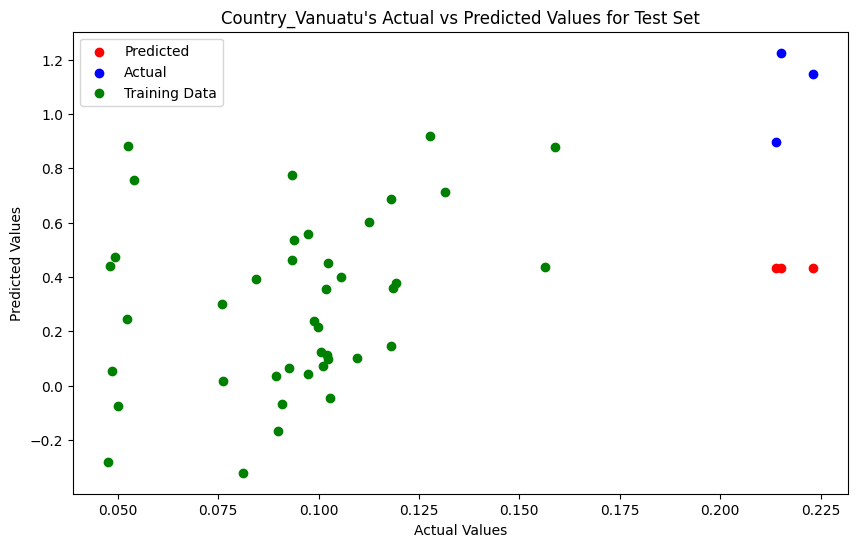

Epoch 1/50
8/8 [==============================] - 3s 103ms/step - loss: 0.0819 - mae: 0.3226 - val_loss: 0.1957 - val_mae: 0.5246
Epoch 2/50
8/8 [==============================] - 0s 35ms/step - loss: 0.0843 - mae: 0.3226 - val_loss: 0.2072 - val_mae: 0.5460
Epoch 3/50
8/8 [==============================] - 0s 26ms/step - loss: 0.0785 - mae: 0.3070 - val_loss: 0.1416 - val_mae: 0.4085
Epoch 4/50
8/8 [==============================] - 0s 25ms/step - loss: 0.0862 - mae: 0.3317 - val_loss: 0.1946 - val_mae: 0.5223
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0817 - mae: 0.3146 - val_loss: 0.2072 - val_mae: 0.5460
Epoch 6/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0814 - mae: 0.3135 - val_loss: 0.1747 - val_mae: 0.4828
Epoch 7/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0819 - mae: 0.3194 - val_loss: 0.1976 - val_mae: 0.5281
Epoch 8/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0810 - mae: 0.3164 - va

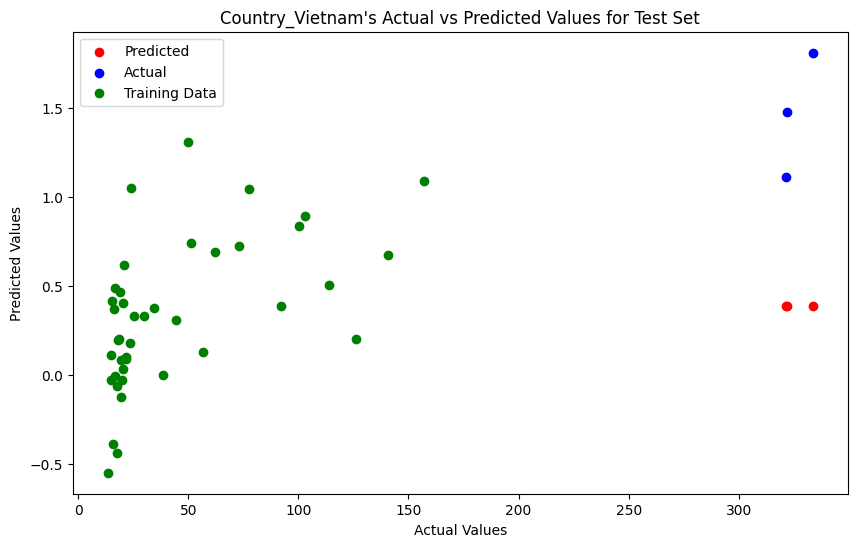

Epoch 1/50
8/8 [==============================] - 7s 79ms/step - loss: 0.1672 - mae: 0.4628 - val_loss: 0.0052 - val_mae: 0.0866
Epoch 2/50
8/8 [==============================] - 0s 21ms/step - loss: 0.1195 - mae: 0.3869 - val_loss: 0.0514 - val_mae: 0.3158
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0885 - mae: 0.3377 - val_loss: 0.0179 - val_mae: 0.1811
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0726 - mae: 0.3217 - val_loss: 0.0111 - val_mae: 0.1390
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0866 - mae: 0.3300 - val_loss: 0.0687 - val_mae: 0.3667
Epoch 6/50
8/8 [==============================] - 0s 17ms/step - loss: 0.1007 - mae: 0.3608 - val_loss: 0.0016 - val_mae: 0.0540
Epoch 7/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0818 - mae: 0.3263 - val_loss: 0.0027 - val_mae: 0.0542
Epoch 8/50
8/8 [==============================] - 0s 26ms/step - loss: 0.0751 - mae: 0.3129 - val

In [ ]:
for country in df.columns[3:]:

  if df[country].sum() == 52:

    country_data = df[df[country] == 1][['Year', 'Temperature', 'Co2']]

    X = country_data[['Co2']].values
    y = country_data['Temperature'].values

    split_index = int(len(X) * 0.8)

    X_train, X_val_test = X[:split_index], X[split_index:]
    y_train, y_val_test = y[:split_index], y[split_index:]


    split_index_val = int(len(X_val_test) * 0.5)

    X_val, X_test = X_val_test[:split_index_val], X_val_test[split_index_val:]
    y_val, y_test = y_val_test[:split_index_val], y_val_test[split_index_val:]


    seq_length = 3
    tf.random.set_seed(42)

    train_ds = tf.keras.utils.timeseries_dataset_from_array(
        X_train,
        targets = y_train[seq_length:],
        sequence_length= seq_length,
        batch_size = 5,
        shuffle = True,
        seed = 42
    )

    valid_ds = tf.keras.utils.timeseries_dataset_from_array(
        X_val,
        targets= y_val[seq_length:],
        sequence_length = seq_length,
        batch_size = 32
    )

    model = fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.05)

    test_predictions = deep_model.predict(test_ds)

    plt.figure(figsize=(10, 6))

    plt.scatter(X_test[seq_length:], test_predictions, color='red', label='Predicted')
    plt.scatter(X_test[seq_length:], y_test[seq_length:], color='blue', label='Actual')
    plt.scatter(X_train, y_train, label='Training Data', color='green')

    plt.title(f"{country}'s Actual vs Predicted Values for Test Set")
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()